# Single GRU optimization
The performance of gradient boosting decision tree and deep neural net models on wildfire risk prediction is underwhelming. The poor performance of these model types may result form their inability to learn from the temporal order of the data. Once can imagine that the weather conditions leading up to a fire are significant causal factor in that fire. Gated recurrent neural networks are designed for time series prediction and may perform better on wildfire risk prediction.

### Goal: 
Optimize and test the performance of a GRU neural network on one California geospatial bin.

### Plan:
1. Prep data from one geospatial bin for input into GRU
2. Generate 'Cassandra' model -> attempt to over fit and 'memorize' the training data. This will prove that the data is feature rich enough and a GRU is complex enough to learn a function which successfully maps input to output.
3. If step 2 is successful, regularize model to increase generalizability.
4. Scale model to predict wilfire risk for all 410 California geospatial bins.

# Notebook setup

In [1]:
import os

import logging
import tensorflow as tf

# Note: tf 2.1.0 give warning about model weight format when
# using class weights. This is the only way to silence without
# updating
tf.get_logger().setLevel(logging.ERROR)
tf.random.set_seed(42)

import numpy as np
np.random.seed(42)

import sys
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn
import joblib

from tensorflow import keras
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras import backend as K
from tensorflow.python.client import device_lib

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns

In [2]:
# Note: sklearn forces depreciation warnings
# This is the only way to silence them without updating
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import confusion_matrix

from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_objective, plot_evaluations
from skopt import gp_minimize

In [3]:
import helper_functions.plotting_functions as plotting_functions
import helper_functions.data_functions as data_functions
import helper_functions.config as config

In [4]:
print(f"Python {sys.version}")
print()
print(f"Pandas {pd.__version__}")
print(f"Tensorflow {tf.__version__}")
print(f"Keras {keras.__version__}")
print(f"SciKit Learn {sklearn.__version__}")
print()

devices = device_lib.list_local_devices()

if 'GPU' in ('').join(str(devices)):
    print("tf accessable GPU found: "+devices[-2].physical_device_desc)

Python 3.7.7 (default, Mar 23 2020, 22:36:06) 
[GCC 7.3.0]

Pandas 1.0.3
Tensorflow 2.2.0
Keras 2.3.0-tf
SciKit Learn 0.23.1

tf accessable GPU found: device: 0, name: GeForce GTX 1070, pci bus id: 0000:02:00.0, compute capability: 6.1


# 1. Data preparation

Let's first load up the data and take a look at what we are working with.

In [5]:
# Load data
data_file = '/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_range_onehot_month_selective_box_cox.parquet'
raw_data = pd.read_parquet(data_file)

# Pick one spatial bin with fires
data = raw_data[(raw_data['raw_lat'] == 39.42233) & (raw_data['raw_lon'] == -120.6546)]

# Also drop unnecessary columns
data.drop([
    'lat',
    'lon',
    'raw_lat',
    'raw_lon',
    'total_fires',
    'veg',
    'January',
    'February',
    'March',
    'April',
    'May',
    'June',
    'July',
    'August',
    'Septermber',
    'October',
    'November',
    'December'], axis=1, inplace=True)

data.reset_index(inplace=True, drop=True)

# calculate class weights and initial output bias from ignition frequency in the data 
class_weight = data_functions.get_class_weights(data)
output_bias = data_functions.get_initial_output_bias(data)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8766 entries, 0 to 8765
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   apcp               8766 non-null   float32       
 1   crain              8766 non-null   int32         
 2   ignition           8766 non-null   int32         
 3   mean_air_2m        8766 non-null   float32       
 4   mean_rhum_2m       8766 non-null   float32       
 5   mean_dpt_2m        8766 non-null   float32       
 6   mean_pres_sfc      8766 non-null   float32       
 7   mean_uwnd_10m      8766 non-null   float32       
 8   mean_vwnd_10m      8766 non-null   float32       
 9   mean_vis           8766 non-null   float32       
 10  mean_cloud_cover   8766 non-null   float32       
 11  date               8766 non-null   datetime64[ns]
 12  range_air_2m       8766 non-null   float32       
 13  range_rhum_2m      8766 non-null   float32       
 14  range_dp

Let's take a look at one of our weather variables and ignition. This way after we do our transformations we can be sure by comparison that we did not deform the data.

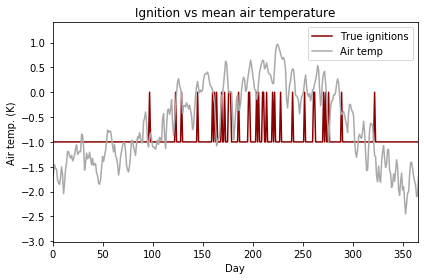

In [6]:
plotting_functions.data_diagnostic_plot(data, 'mean_air_2m', 1, -1)

Looks good, qualitatively, fire season is in late summer and early fall when temperatures are higher.

### Split data into training, validation and testing sets
Note: since temporal order matters here, we cannot simply randomly sample the data - we need to preserve the order. One possible improvement could be to break the data into many smaller ordered chunks and then sample those randomly...

In [7]:
# Split data up into training, testing and validation sets
test_data = data.tail(int(len(data)*0.25))
leftover_data = data.head(int(len(data)*0.75))
validation_data = data.tail(int(len(leftover_data)*0.5))
training_data = data.head(int(len(leftover_data)*0.5))

Let's compare the distributions of each weather variable across the train, validation and test sets just to be sure that our samples are matched to a first approximation.

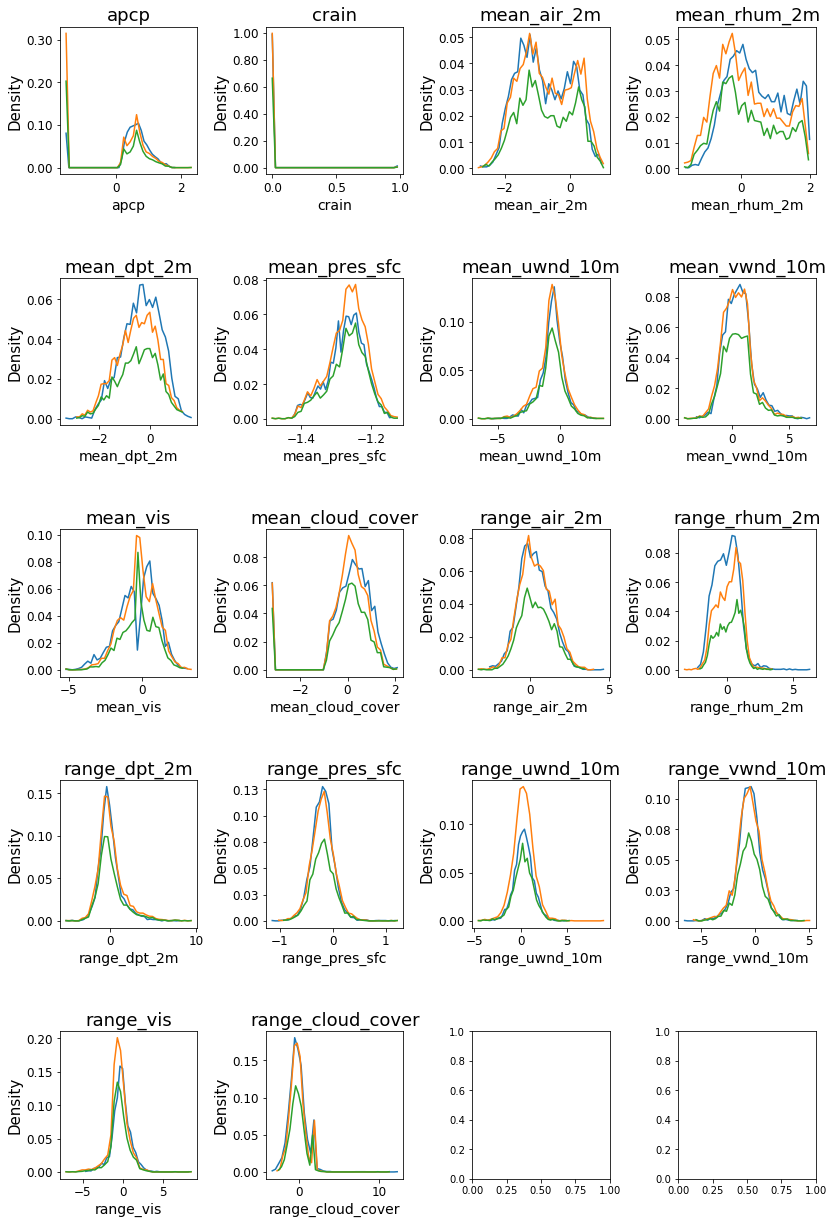

In [8]:
# plot split data distributions
features = [
    'apcp',
    'crain',
#     'veg',
    'mean_air_2m',       
    'mean_rhum_2m', 
    'mean_dpt_2m', 
    'mean_pres_sfc', 
    'mean_uwnd_10m', 
    'mean_vwnd_10m', 
    'mean_vis', 
    'mean_cloud_cover',
    'range_air_2m',
    'range_rhum_2m', 
    'range_dpt_2m',
    'range_pres_sfc',
    'range_uwnd_10m',
    'range_vwnd_10m',
    'range_vis',
    'range_cloud_cover'
]

left = config.left
right = config.right
bottom = config.bottom
top = config.top
wspace = config.wspace
hspace = config.hspace
fig_rows = 5
fig_cols = 4
plot_height = 20
plot_width = config.plot_width

plot_locations = [
    (0,0),(0,1),(0,2),(0,3),
    (1,0),(1,1),(1,2),(1,3),
    (2,0),(2,1),(2,2),(2,3),
    (3,0),(3,1),(3,2),(3,3),
    (4,0),(4,1),(4,2),(4,3)
]

xlabels = features
ylabels = ['Density'] * len(features)

# Make density plots
fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(features)):
    ax[plot_locations[i]] = plotting_functions.three_sample_density_plot(
        ax,
        plot_locations[i], 
        training_data, 
        validation_data, 
        test_data, 
        features[i], 
        features[i], 
        features[i], 
        ylabels[i]
    )
    
plt.show()

Looks pretty good - there are some small differences, but without implementing the time block sampling strategy outlined above there is not much to be done at this point.

Now let's take a quick look at what we have before we build and train our model

In [9]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   apcp               3287 non-null   float32       
 1   crain              3287 non-null   int32         
 2   ignition           3287 non-null   int32         
 3   mean_air_2m        3287 non-null   float32       
 4   mean_rhum_2m       3287 non-null   float32       
 5   mean_dpt_2m        3287 non-null   float32       
 6   mean_pres_sfc      3287 non-null   float32       
 7   mean_uwnd_10m      3287 non-null   float32       
 8   mean_vwnd_10m      3287 non-null   float32       
 9   mean_vis           3287 non-null   float32       
 10  mean_cloud_cover   3287 non-null   float32       
 11  date               3287 non-null   datetime64[ns]
 12  range_air_2m       3287 non-null   float32       
 13  range_rhum_2m      3287 non-null   float32       
 14  range_dp

# 2. GRU optimization - Cassandra model

Goal in this step is to over fit on purpose. This will give us an upper bound on how accurately it is possible to learn this data with an GRU. Then we will regularize the model until it generalizes well.

We will start with 100 GRU units feeding into a 1 unit output layer. We will use binary cross-entropy as our loss function. Since the data is unbalanced we will optimize class weights. Other tunable parameters included in the optimization will be the learning rate and past history size for each sample.

Hyperparameters will be optimized using gaussian process optimization (GPO) on the Matthews correlation coefficient (MCC).

We will also monitor true and false positive and negatives as well as AUC as metrics.

### Set up gaussian process optimization

In [10]:
# metrics to track
metrics = [
    keras.metrics.TruePositives(name='true_positives'),
    keras.metrics.FalsePositives(name='false_positives'),
    keras.metrics.TrueNegatives(name='true_negatives'),
    keras.metrics.FalseNegatives(name='false_negatives'), 
    keras.metrics.AUC(name='auc'),
    data_functions.matthews_correlation,
    data_functions.f1
]

#metrics = config.metrics

# dimensions to include in GPM search space
dim_learning_rate = Real(
    low=0.0001,
    high=0.1, 
    name='learning_rate'
)

dim_past_history = Integer(
    low=4,
    high=28, 
    name='past_history'
)

dim_batch_size = Integer(
    low=512,
    high=2048, 
    name='batch_size'
)

# dim_class_0_weight = Real(
#     low=0.001, 
#     high=10,
#     name='class_0_weight'
# )

# dim_class_1_weight = Real(
#     low=0.01, 
#     high=100,
#     name='class_1_weight'
# )

dimensions = [
    dim_learning_rate,
    dim_past_history,
    dim_batch_size
#     dim_class_0_weight,
#     dim_class_1_weight
]

default_parameters = [0.01, 16, 1024]

# Use early stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'matthews_correlation', 
    patience = 10,
    mode = 'max',
    restore_best_weights = True
)

future_target = 1
step = 1
EPOCHS = 25

# also set initial value for output bias based on fire frequency
# raw_output_bias = np.log([num_fires/(total_observations - num_fires)])
# output_bias = tf.keras.initializers.Constant(raw_output_bias)

path_best_model = './trained_models/first_round_single_LSTM_optimization.keras'
best_matthews_correlation = -1.0

run_num = 1

In [11]:
def make_model(
    input_shape,
    learning_rate
):    
    '''Defines simple one input-one output GRU model'''
    
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.GRU(
        500,
        stateful = False,
        dropout = 0.2
    ))
    
    model.add(tf.keras.layers.Dense(
        1,
        activation = 'sigmoid',
        bias_initializer = output_bias)
    )

    model.compile(
        optimizer = tf.keras.optimizers.Adam(lr = learning_rate), 
        loss = keras.losses.BinaryCrossentropy(),
        metrics = metrics
    )

    return model

@use_named_args(dimensions=dimensions)
def fitness(
    learning_rate,
    past_history,
    batch_size
#     class_0_weight,
#     class_1_weight
):
    '''Takes set of tuneable parameter and search space dimensions
    runs GPO on model, returns model fitness, metrics and hyperparameter
    setting for each itteration'''
    
    # calculate batch, and steps from data size and past history
    #batch_size = int((len(training_data) * 0.99) // past_history)
    steps_per_epoch = int(len(training_data) // batch_size)
    validation_steps = int(len(validation_data) // batch_size)
    
    dataset_len = len(training_data)
    ignition_count = sum(training_data['ignition'])
    no_ignition_count = dataset_len - ignition_count
    
    weight_for_0 = (1 / no_ignition_count)*(dataset_len)/2.0 
    weight_for_1 = (1 / ignition_count)*(dataset_len)/2.0

    class_weight = {0: weight_for_0, 1: weight_for_1}
    
    # create training and vaildation data 
    x_train, y_train = data_functions.multivariate_data(
        training_data,
        past_history,
        future_target, 
        step
    )
    
    x_validation, y_validation = data_functions.multivariate_data(
        validation_data,
        past_history,
        future_target, 
        step
    )
    
    
    # trim datasets so they are whole number multiples of the batch
    # size (needed for statefull LSTM)
    start_index = (x_train.shape[0] - (x_train.shape[0] % batch_size))
    end_index = x_train.shape[0]
    
    x_train = np.delete(x_train, range(start_index, end_index), axis=0)
    y_train = np.delete(y_train, range(start_index, end_index), axis=0)
    
    start_index = (x_validation.shape[0] - (x_validation.shape[0] % batch_size))
    end_index = x_validation.shape[0]
    
    x_validation = np.delete(x_validation, range(start_index, end_index), axis=0)
    y_validation = np.delete(y_validation, range(start_index, end_index), axis=0)
    
    input_dim = x_train.shape[-2:]
    input_shape = (batch_size, input_dim[0], input_dim[1])
    
    # Create the neural network with these hyper-parameters.
    model = make_model(
        input_shape,
        learning_rate
    )
    
    # Create a callback-function for Keras which will be
    # run after each epoch has ended during training.
    # This saves the log-files for TensorBoard.
    # Note that there are complications when histogram_freq=1.
    # It might give strange errors and it also does not properly
    # support Keras data-generators for the validation-set.
    global run_num
    
    # Set up tensorboard logging callback
    log_dir = f'./LSTM_logs/single_statefull_gp_min_run{run_num}/'
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
   
    # Use Keras to train the model.
    history = model.fit(
        x_train,
        y_train,
        epochs = EPOCHS,
        batch_size = batch_size,
        steps_per_epoch = steps_per_epoch,
        callbacks = [early_stopping_callback],
        validation_data = (x_validation, y_validation),
        validation_steps = validation_steps,
        class_weight = class_weight,
        workers = 8,
        verbose = 1
    )

    # Get MCC for training run
    matthews_correlation = history.history['matthews_correlation'][-1]

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_matthews_correlation

    # If the MCC of the saved model is improved ...
    if matthews_correlation > best_matthews_correlation:
        # Save the new model to harddisk.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_matthews_correlation = matthews_correlation
        
    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    
    run_num += 1
    
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST MCC, we need to 
    # negate this number so it can be minimized.
    return -matthews_correlation

### Run gaussian process optimization

In [12]:
%%time

# do the optimization run
search_result = gp_minimize(
    func=fitness,
    dimensions=dimensions,
    acq_func='EI', # Expected Improvement.
    n_calls=100,
    x0=default_parameters
)

Epoch 1/25
3/3 [==============================] - 1s 371ms/step - loss: 1.4068 - true_positives: 43.0000 - false_positives: 738.0000 - true_negatives: 2205.0000 - false_negatives: 86.0000 - auc: 0.5652 - matthews_correlation: 0.0456 - f1: 0.0582 - val_loss: 0.2949 - val_true_positives: 21.0000 - val_false_positives: 219.0000 - val_true_negatives: 2732.0000 - val_false_negatives: 100.0000 - val_auc: 0.6123 - val_matthews_correlation: 0.0741 - val_f1: 0.1152
Epoch 2/25
3/3 [==============================] - 0s 67ms/step - loss: 1.2470 - true_positives: 65.0000 - false_positives: 1335.0000 - true_negatives: 1608.0000 - false_negatives: 64.0000 - auc: 0.5745 - matthews_correlation: 0.0275 - f1: 0.0839 - val_loss: 0.8361 - val_true_positives: 61.0000 - val_false_positives: 1213.0000 - val_true_negatives: 1738.0000 - val_false_negatives: 60.0000 - val_auc: 0.5609 - val_matthews_correlation: 0.0364 - val_f1: 0.0876
Epoch 3/25
3/3 [==============================] - 0s 67ms/step - loss: 0.8947 

Epoch 19/25
3/3 [==============================] - 0s 64ms/step - loss: 0.6267 - true_positives: 90.0000 - false_positives: 1236.0000 - true_negatives: 1707.0000 - false_negatives: 39.0000 - auc: 0.7056 - matthews_correlation: 0.1159 - f1: 0.1243 - val_loss: 0.5030 - val_true_positives: 79.0000 - val_false_positives: 771.0000 - val_true_negatives: 2180.0000 - val_false_negatives: 42.0000 - val_auc: 0.7388 - val_matthews_correlation: 0.1732 - val_f1: 0.1626
Epoch 20/25
3/3 [==============================] - 0s 65ms/step - loss: 0.6000 - true_positives: 94.0000 - false_positives: 900.0000 - true_negatives: 2043.0000 - false_negatives: 35.0000 - auc: 0.7490 - matthews_correlation: 0.1830 - f1: 0.1688 - val_loss: 0.5443 - val_true_positives: 83.0000 - val_false_positives: 870.0000 - val_true_negatives: 2081.0000 - val_false_negatives: 38.0000 - val_auc: 0.7406 - val_matthews_correlation: 0.1674 - val_f1: 0.1553
Epoch 21/25
3/3 [==============================] - 0s 67ms/step - loss: 0.5735 

Epoch 12/25
6/6 [==============================] - 0s 61ms/step - loss: 0.7295 - true_positives: 95.0000 - false_positives: 1118.0000 - true_negatives: 1831.0000 - false_negatives: 34.0000 - auc: 0.7362 - matthews_correlation: 0.1640 - f1: 0.1454 - val_loss: 0.9515 - val_true_positives: 101.0000 - val_false_positives: 1142.0000 - val_true_negatives: 1815.0000 - val_false_negatives: 20.0000 - val_auc: 0.7662 - val_matthews_correlation: 0.1695 - val_f1: 0.1419
Epoch 13/25
6/6 [==============================] - 0s 63ms/step - loss: 0.6373 - true_positives: 94.0000 - false_positives: 870.0000 - true_negatives: 2079.0000 - false_negatives: 35.0000 - auc: 0.7768 - matthews_correlation: 0.1925 - f1: 0.1759 - val_loss: 0.6002 - val_true_positives: 78.0000 - val_false_positives: 830.0000 - val_true_negatives: 2127.0000 - val_false_negatives: 43.0000 - val_auc: 0.7703 - val_matthews_correlation: 0.1490 - val_f1: 0.1457
Epoch 14/25
6/6 [==============================] - 0s 61ms/step - loss: 0.599

Epoch 5/25
1/1 [==============================] - 0s 73ms/step - loss: 1.2340 - true_positives: 69.0000 - false_positives: 969.0000 - true_negatives: 960.0000 - false_negatives: 24.0000 - auc: 0.6853 - matthews_correlation: 0.1004 - f1: 0.1220 - val_loss: 3.3306 - val_true_positives: 66.0000 - val_false_positives: 1257.0000 - val_true_negatives: 693.0000 - val_false_negatives: 6.0000 - val_auc: 0.6548 - val_matthews_correlation: 0.1060 - val_f1: 0.0946
Epoch 6/25
1/1 [==============================] - 0s 70ms/step - loss: 1.5404 - true_positives: 78.0000 - false_positives: 1142.0000 - true_negatives: 787.0000 - false_negatives: 15.0000 - auc: 0.6923 - matthews_correlation: 0.1056 - f1: 0.1188 - val_loss: 2.9927 - val_true_positives: 63.0000 - val_false_positives: 1035.0000 - val_true_negatives: 915.0000 - val_false_negatives: 9.0000 - val_auc: 0.6912 - val_matthews_correlation: 0.1281 - val_f1: 0.1077
Epoch 7/25
1/1 [==============================] - 0s 68ms/step - loss: 1.5739 - true_

Epoch 23/25
1/1 [==============================] - 0s 62ms/step - loss: 0.6335 - true_positives: 86.0000 - false_positives: 963.0000 - true_negatives: 966.0000 - false_negatives: 7.0000 - auc: 0.7672 - matthews_correlation: 0.1784 - f1: 0.1506 - val_loss: 0.8814 - val_true_positives: 57.0000 - val_false_positives: 929.0000 - val_true_negatives: 1021.0000 - val_false_negatives: 15.0000 - val_auc: 0.7270 - val_matthews_correlation: 0.1169 - val_f1: 0.1078
Epoch 24/25
1/1 [==============================] - 0s 69ms/step - loss: 0.5616 - true_positives: 84.0000 - false_positives: 788.0000 - true_negatives: 1141.0000 - false_negatives: 9.0000 - auc: 0.8021 - matthews_correlation: 0.2092 - f1: 0.1741 - val_loss: 0.6339 - val_true_positives: 44.0000 - val_false_positives: 554.0000 - val_true_negatives: 1396.0000 - val_false_negatives: 28.0000 - val_auc: 0.7124 - val_matthews_correlation: 0.1328 - val_f1: 0.1313
Epoch 25/25
1/1 [==============================] - 0s 64ms/step - loss: 0.6660 - tr

Epoch 16/25
4/4 [==============================] - 0s 49ms/step - loss: 0.7579 - true_positives: 75.0000 - false_positives: 604.0000 - true_negatives: 2070.0000 - false_negatives: 47.0000 - auc: 0.7877 - matthews_correlation: 0.1836 - f1: 0.1805 - val_loss: 1.1980 - val_true_positives: 104.0000 - val_false_positives: 1127.0000 - val_true_negatives: 1551.0000 - val_false_negatives: 14.0000 - val_auc: 0.7760 - val_matthews_correlation: 0.1887 - val_f1: 0.1540
Epoch 17/25
4/4 [==============================] - 0s 50ms/step - loss: 0.6533 - true_positives: 83.0000 - false_positives: 626.0000 - true_negatives: 2048.0000 - false_negatives: 39.0000 - auc: 0.8052 - matthews_correlation: 0.2158 - f1: 0.2073 - val_loss: 0.7478 - val_true_positives: 101.0000 - val_false_positives: 949.0000 - val_true_negatives: 1729.0000 - val_false_negatives: 17.0000 - val_auc: 0.7987 - val_matthews_correlation: 0.2091 - val_f1: 0.1725
Epoch 18/25
4/4 [==============================] - 0s 51ms/step - loss: 0.538

Epoch 9/25
1/1 [==============================] - 0s 66ms/step - loss: 0.9011 - true_positives: 71.0000 - false_positives: 672.0000 - true_negatives: 1172.0000 - false_negatives: 20.0000 - auc: 0.7574 - matthews_correlation: 0.1810 - f1: 0.1703 - val_loss: 0.7916 - val_true_positives: 50.0000 - val_false_positives: 452.0000 - val_true_negatives: 1414.0000 - val_false_negatives: 19.0000 - val_auc: 0.7807 - val_matthews_correlation: 0.2041 - val_f1: 0.1751
Epoch 10/25
1/1 [==============================] - 0s 71ms/step - loss: 0.8865 - true_positives: 54.0000 - false_positives: 411.0000 - true_negatives: 1433.0000 - false_negatives: 37.0000 - auc: 0.7757 - matthews_correlation: 0.1836 - f1: 0.1942 - val_loss: 0.5392 - val_true_positives: 41.0000 - val_false_positives: 365.0000 - val_true_negatives: 1501.0000 - val_false_negatives: 28.0000 - val_auc: 0.7968 - val_matthews_correlation: 0.1815 - val_f1: 0.1726
Epoch 11/25
1/1 [==============================] - 0s 64ms/step - loss: 0.9544 - 

Epoch 3/25
1/1 [==============================] - 0s 77ms/step - loss: 2.3447 - true_positives: 24.0000 - false_positives: 132.0000 - true_negatives: 1771.0000 - false_negatives: 68.0000 - auc: 0.6965 - matthews_correlation: 0.1496 - f1: 0.1935 - val_loss: 0.5314 - val_true_positives: 8.0000 - val_false_positives: 214.0000 - val_true_negatives: 1711.0000 - val_false_negatives: 62.0000 - val_auc: 0.4619 - val_matthews_correlation: 0.0018 - val_f1: 0.0548
Epoch 4/25
1/1 [==============================] - 0s 76ms/step - loss: 3.7058 - true_positives: 11.0000 - false_positives: 227.0000 - true_negatives: 1676.0000 - false_negatives: 81.0000 - auc: 0.4749 - matthews_correlation: 1.8110e-04 - f1: 0.0667 - val_loss: 1.6623 - val_true_positives: 11.0000 - val_false_positives: 500.0000 - val_true_negatives: 1425.0000 - val_false_negatives: 59.0000 - val_auc: 0.4322 - val_matthews_correlation: -0.0432 - val_f1: 0.0379
Epoch 5/25
1/1 [==============================] - 0s 403ms/step - loss: 4.6508

Epoch 21/25
1/1 [==============================] - 0s 71ms/step - loss: 1.1661 - true_positives: 73.0000 - false_positives: 739.0000 - true_negatives: 1164.0000 - false_negatives: 19.0000 - auc: 0.7520 - matthews_correlation: 0.1730 - f1: 0.1615 - val_loss: 1.4191 - val_true_positives: 54.0000 - val_false_positives: 700.0000 - val_true_negatives: 1225.0000 - val_false_negatives: 16.0000 - val_auc: 0.7529 - val_matthews_correlation: 0.1548 - val_f1: 0.1311
Epoch 22/25
1/1 [==============================] - 0s 76ms/step - loss: 0.9780 - true_positives: 74.0000 - false_positives: 647.0000 - true_negatives: 1256.0000 - false_negatives: 18.0000 - auc: 0.7668 - matthews_correlation: 0.2027 - f1: 0.1820 - val_loss: 0.9456 - val_true_positives: 50.0000 - val_false_positives: 645.0000 - val_true_negatives: 1280.0000 - val_false_negatives: 20.0000 - val_auc: 0.7515 - val_matthews_correlation: 0.1465 - val_f1: 0.1307
Epoch 23/25
1/1 [==============================] - 0s 70ms/step - loss: 0.8999 -

Epoch 14/25
3/3 [==============================] - 0s 38ms/step - loss: 0.5440 - true_positives: 106.0000 - false_positives: 936.0000 - true_negatives: 2112.0000 - false_negatives: 35.0000 - auc: 0.8299 - matthews_correlation: 0.1936 - f1: 0.1774 - val_loss: 0.3425 - val_true_positives: 60.0000 - val_false_positives: 494.0000 - val_true_negatives: 2560.0000 - val_false_negatives: 75.0000 - val_auc: 0.7838 - val_matthews_correlation: 0.1523 - val_f1: 0.1743
Epoch 15/25
3/3 [==============================] - 0s 36ms/step - loss: 0.6003 - true_positives: 108.0000 - false_positives: 956.0000 - true_negatives: 2092.0000 - false_negatives: 33.0000 - auc: 0.8174 - matthews_correlation: 0.2133 - f1: 0.1916 - val_loss: 0.6896 - val_true_positives: 106.0000 - val_false_positives: 1013.0000 - val_true_negatives: 2041.0000 - val_false_negatives: 29.0000 - val_auc: 0.7806 - val_matthews_correlation: 0.1913 - val_f1: 0.1686
Epoch 16/25
3/3 [==============================] - 0s 37ms/step - loss: 0.49

Epoch 7/25
1/1 [==============================] - 0s 61ms/step - loss: 1.8107 - true_positives: 73.0000 - false_positives: 740.0000 - true_negatives: 1172.0000 - false_negatives: 20.0000 - auc: 0.7385 - matthews_correlation: 0.1704 - f1: 0.1611 - val_loss: 4.3957 - val_true_positives: 63.0000 - val_false_positives: 1235.0000 - val_true_negatives: 700.0000 - val_false_negatives: 7.0000 - val_auc: 0.7716 - val_matthews_correlation: 0.1006 - val_f1: 0.0921
Epoch 8/25
1/1 [==============================] - 0s 63ms/step - loss: 2.1522 - true_positives: 79.0000 - false_positives: 1167.0000 - true_negatives: 745.0000 - false_negatives: 14.0000 - auc: 0.7133 - matthews_correlation: 0.1037 - f1: 0.1180 - val_loss: 4.2062 - val_true_positives: 63.0000 - val_false_positives: 1179.0000 - val_true_negatives: 756.0000 - val_false_negatives: 7.0000 - val_auc: 0.7700 - val_matthews_correlation: 0.1099 - val_f1: 0.0960
Epoch 9/25
1/1 [==============================] - 0s 62ms/step - loss: 1.9868 - true

Epoch 4/25
2/2 [==============================] - 0s 56ms/step - loss: 2.8080 - true_positives: 112.0000 - false_positives: 2469.0000 - true_negatives: 5.0000 - false_negatives: 0.0000e+00 - auc: 0.5508 - matthews_correlation: 0.0094 - f1: 0.0831 - val_loss: 2.8248 - val_true_positives: 100.0000 - val_false_positives: 2121.0000 - val_true_negatives: 362.0000 - val_false_negatives: 3.0000 - val_auc: 0.7252 - val_matthews_correlation: 0.0649 - val_f1: 0.0859
Epoch 5/25
2/2 [==============================] - 0s 60ms/step - loss: 1.2067 - true_positives: 90.0000 - false_positives: 1198.0000 - true_negatives: 1276.0000 - false_negatives: 22.0000 - auc: 0.7272 - matthews_correlation: 0.1456 - f1: 0.1480 - val_loss: 1.3963 - val_true_positives: 79.0000 - val_false_positives: 731.0000 - val_true_negatives: 1752.0000 - val_false_negatives: 24.0000 - val_auc: 0.7559 - val_matthews_correlation: 0.1985 - val_f1: 0.1726
Epoch 6/25
2/2 [==============================] - 0s 63ms/step - loss: 1.3270 -

Epoch 5/25
3/3 [==============================] - 0s 53ms/step - loss: 0.5553 - true_positives: 91.0000 - false_positives: 844.0000 - true_negatives: 1588.0000 - false_negatives: 21.0000 - auc: 0.7870 - matthews_correlation: 0.1999 - f1: 0.1738 - val_loss: 0.8607 - val_true_positives: 92.0000 - val_false_positives: 1060.0000 - val_true_negatives: 1382.0000 - val_false_negatives: 10.0000 - val_auc: 0.7839 - val_matthews_correlation: 0.1845 - val_f1: 0.1463
Epoch 6/25
3/3 [==============================] - 0s 58ms/step - loss: 0.5350 - true_positives: 98.0000 - false_positives: 908.0000 - true_negatives: 1524.0000 - false_negatives: 14.0000 - auc: 0.7969 - matthews_correlation: 0.2107 - f1: 0.1753 - val_loss: 0.5636 - val_true_positives: 86.0000 - val_false_positives: 895.0000 - val_true_negatives: 1547.0000 - val_false_negatives: 16.0000 - val_auc: 0.7826 - val_matthews_correlation: 0.1923 - val_f1: 0.1585
Epoch 7/25
3/3 [==============================] - 0s 54ms/step - loss: 0.5235 - t

Epoch 23/25
3/3 [==============================] - 0s 57ms/step - loss: 0.3847 - true_positives: 103.0000 - false_positives: 620.0000 - true_negatives: 1812.0000 - false_negatives: 9.0000 - auc: 0.8938 - matthews_correlation: 0.3021 - f1: 0.2468 - val_loss: 0.5499 - val_true_positives: 81.0000 - val_false_positives: 899.0000 - val_true_negatives: 1543.0000 - val_false_negatives: 21.0000 - val_auc: 0.7516 - val_matthews_correlation: 0.1726 - val_f1: 0.1491
Epoch 24/25
3/3 [==============================] - 0s 57ms/step - loss: 0.4189 - true_positives: 104.0000 - false_positives: 783.0000 - true_negatives: 1649.0000 - false_negatives: 8.0000 - auc: 0.8791 - matthews_correlation: 0.2608 - f1: 0.2078 - val_loss: 0.6333 - val_true_positives: 87.0000 - val_false_positives: 982.0000 - val_true_negatives: 1460.0000 - val_false_negatives: 15.0000 - val_auc: 0.7487 - val_matthews_correlation: 0.1798 - val_f1: 0.1479
Epoch 25/25
3/3 [==============================] - 0s 55ms/step - loss: 0.4016 -

3/3 [==============================] - 0s 53ms/step - loss: 0.5706 - true_positives: 85.0000 - false_positives: 675.0000 - true_negatives: 2138.0000 - false_negatives: 42.0000 - auc: 0.7779 - matthews_correlation: 0.1908 - f1: 0.1860 - val_loss: 0.4623 - val_true_positives: 73.0000 - val_false_positives: 633.0000 - val_true_negatives: 2187.0000 - val_false_negatives: 47.0000 - val_auc: 0.7561 - val_matthews_correlation: 0.1800 - val_f1: 0.1762
Epoch 16/25
3/3 [==============================] - 0s 54ms/step - loss: 0.5734 - true_positives: 81.0000 - false_positives: 681.0000 - true_negatives: 2132.0000 - false_negatives: 46.0000 - auc: 0.7757 - matthews_correlation: 0.1842 - f1: 0.1825 - val_loss: 0.4687 - val_true_positives: 75.0000 - val_false_positives: 652.0000 - val_true_negatives: 2168.0000 - val_false_negatives: 45.0000 - val_auc: 0.7586 - val_matthews_correlation: 0.1817 - val_f1: 0.1760
Epoch 17/25
3/3 [==============================] - 0s 54ms/step - loss: 0.5664 - true_positi

Epoch 9/25
3/3 [==============================] - 0s 38ms/step - loss: 0.6165 - true_positives: 82.0000 - false_positives: 572.0000 - true_negatives: 2476.0000 - false_negatives: 59.0000 - auc: 0.8115 - matthews_correlation: 0.2025 - f1: 0.2074 - val_loss: 1.0502 - val_true_positives: 121.0000 - val_false_positives: 1496.0000 - val_true_negatives: 1558.0000 - val_false_negatives: 14.0000 - val_auc: 0.7722 - val_matthews_correlation: 0.1631 - val_f1: 0.1378
Epoch 10/25
3/3 [==============================] - 0s 36ms/step - loss: 0.6093 - true_positives: 129.0000 - false_positives: 1343.0000 - true_negatives: 1705.0000 - false_negatives: 12.0000 - auc: 0.8137 - matthews_correlation: 0.1947 - f1: 0.1589 - val_loss: 0.3432 - val_true_positives: 53.0000 - val_false_positives: 461.0000 - val_true_negatives: 2593.0000 - val_false_negatives: 82.0000 - val_auc: 0.7648 - val_matthews_correlation: 0.1278 - val_f1: 0.1600
Epoch 11/25
3/3 [==============================] - 0s 37ms/step - loss: 0.619

Epoch 2/25
3/3 [==============================] - 0s 46ms/step - loss: 3.0352 - true_positives: 40.0000 - false_positives: 555.0000 - true_negatives: 2493.0000 - false_negatives: 101.0000 - auc: 0.6102 - matthews_correlation: 0.0496 - f1: 0.1045 - val_loss: 4.1546 - val_true_positives: 111.0000 - val_false_positives: 1525.0000 - val_true_negatives: 1529.0000 - val_false_negatives: 24.0000 - val_auc: 0.6997 - val_matthews_correlation: 0.1302 - val_f1: 0.1250
Epoch 3/25
3/3 [==============================] - 0s 47ms/step - loss: 2.5859 - true_positives: 119.0000 - false_positives: 1693.0000 - true_negatives: 1355.0000 - false_negatives: 22.0000 - auc: 0.7091 - matthews_correlation: 0.1206 - f1: 0.1244 - val_loss: 4.0750 - val_true_positives: 126.0000 - val_false_positives: 2225.0000 - val_true_negatives: 829.0000 - val_false_negatives: 9.0000 - val_auc: 0.6949 - val_matthews_correlation: 0.0928 - val_f1: 0.1008
Epoch 4/25
3/3 [==============================] - 0s 47ms/step - loss: 1.4205

Epoch 20/25
3/3 [==============================] - 0s 45ms/step - loss: 0.5106 - true_positives: 125.0000 - false_positives: 1075.0000 - true_negatives: 1973.0000 - false_negatives: 16.0000 - auc: 0.8110 - matthews_correlation: 0.2286 - f1: 0.1889 - val_loss: 0.4835 - val_true_positives: 93.0000 - val_false_positives: 889.0000 - val_true_negatives: 2165.0000 - val_false_negatives: 42.0000 - val_auc: 0.7705 - val_matthews_correlation: 0.1735 - val_f1: 0.1666
Epoch 21/25
3/3 [==============================] - 0s 45ms/step - loss: 0.5414 - true_positives: 115.0000 - false_positives: 1061.0000 - true_negatives: 1987.0000 - false_negatives: 26.0000 - auc: 0.8068 - matthews_correlation: 0.2096 - f1: 0.1794 - val_loss: 0.4229 - val_true_positives: 62.0000 - val_false_positives: 619.0000 - val_true_negatives: 2435.0000 - val_false_negatives: 73.0000 - val_auc: 0.7456 - val_matthews_correlation: 0.1248 - val_f1: 0.1514
Epoch 22/25
3/3 [==============================] - 0s 44ms/step - loss: 0.51

Epoch 13/25
3/3 [==============================] - 0s 55ms/step - loss: 0.5434 - true_positives: 90.0000 - false_positives: 780.0000 - true_negatives: 1649.0000 - false_negatives: 22.0000 - auc: 0.7919 - matthews_correlation: 0.2090 - f1: 0.1829 - val_loss: 0.6912 - val_true_positives: 88.0000 - val_false_positives: 959.0000 - val_true_negatives: 1480.0000 - val_false_negatives: 14.0000 - val_auc: 0.7611 - val_matthews_correlation: 0.1866 - val_f1: 0.1525
Epoch 14/25
3/3 [==============================] - 0s 53ms/step - loss: 0.5229 - true_positives: 93.0000 - false_positives: 816.0000 - true_negatives: 1613.0000 - false_negatives: 19.0000 - auc: 0.8053 - matthews_correlation: 0.2096 - f1: 0.1806 - val_loss: 0.6318 - val_true_positives: 86.0000 - val_false_positives: 901.0000 - val_true_negatives: 1538.0000 - val_false_negatives: 16.0000 - val_auc: 0.7623 - val_matthews_correlation: 0.1899 - val_f1: 0.1572
Epoch 15/25
3/3 [==============================] - 0s 56ms/step - loss: 0.5261 -

Epoch 6/25
3/3 [==============================] - 0s 30ms/step - loss: 0.7457 - true_positives: 103.0000 - false_positives: 1346.0000 - true_negatives: 1702.0000 - false_negatives: 38.0000 - auc: 0.7227 - matthews_correlation: 0.1383 - f1: 0.1412 - val_loss: 0.7476 - val_true_positives: 106.0000 - val_false_positives: 993.0000 - val_true_negatives: 2061.0000 - val_false_negatives: 29.0000 - val_auc: 0.7650 - val_matthews_correlation: 0.1942 - val_f1: 0.1714
Epoch 7/25
3/3 [==============================] - 0s 34ms/step - loss: 0.7799 - true_positives: 74.0000 - false_positives: 594.0000 - true_negatives: 2454.0000 - false_negatives: 67.0000 - auc: 0.7866 - matthews_correlation: 0.1728 - f1: 0.1807 - val_loss: 0.9518 - val_true_positives: 118.0000 - val_false_positives: 1379.0000 - val_true_negatives: 1675.0000 - val_false_negatives: 17.0000 - val_auc: 0.7571 - val_matthews_correlation: 0.1698 - val_f1: 0.1441
Epoch 8/25
3/3 [==============================] - 0s 31ms/step - loss: 0.6953

Epoch 24/25
3/3 [==============================] - 0s 30ms/step - loss: 0.4507 - true_positives: 113.0000 - false_positives: 736.0000 - true_negatives: 2312.0000 - false_negatives: 28.0000 - auc: 0.8632 - matthews_correlation: 0.2665 - f1: 0.2349 - val_loss: 0.8557 - val_true_positives: 106.0000 - val_false_positives: 1218.0000 - val_true_negatives: 1836.0000 - val_false_negatives: 29.0000 - val_auc: 0.7364 - val_matthews_correlation: 0.1566 - val_f1: 0.1448
Epoch 25/25
3/3 [==============================] - 0s 33ms/step - loss: 0.4732 - true_positives: 114.0000 - false_positives: 678.0000 - true_negatives: 2370.0000 - false_negatives: 27.0000 - auc: 0.8604 - matthews_correlation: 0.3062 - f1: 0.2705 - val_loss: 0.7642 - val_true_positives: 103.0000 - val_false_positives: 1059.0000 - val_true_negatives: 1995.0000 - val_false_negatives: 32.0000 - val_auc: 0.7362 - val_matthews_correlation: 0.1732 - val_f1: 0.1588
Epoch 1/25
3/3 [==============================] - 1s 302ms/step - loss: 4.

Epoch 17/25
3/3 [==============================] - 0s 30ms/step - loss: 0.5009 - true_positives: 119.0000 - false_positives: 948.0000 - true_negatives: 2100.0000 - false_negatives: 22.0000 - auc: 0.8421 - matthews_correlation: 0.2323 - f1: 0.1975 - val_loss: 0.5298 - val_true_positives: 95.0000 - val_false_positives: 885.0000 - val_true_negatives: 2169.0000 - val_false_negatives: 40.0000 - val_auc: 0.7745 - val_matthews_correlation: 0.1810 - val_f1: 0.1701
Epoch 18/25
3/3 [==============================] - 0s 32ms/step - loss: 0.4864 - true_positives: 110.0000 - false_positives: 772.0000 - true_negatives: 2276.0000 - false_negatives: 31.0000 - auc: 0.8408 - matthews_correlation: 0.2419 - f1: 0.2178 - val_loss: 0.6935 - val_true_positives: 103.0000 - val_false_positives: 1202.0000 - val_true_negatives: 1852.0000 - val_false_negatives: 32.0000 - val_auc: 0.7460 - val_matthews_correlation: 0.1494 - val_f1: 0.1417
Epoch 19/25
3/3 [==============================] - 0s 29ms/step - loss: 0.58

Epoch 10/25
3/3 [==============================] - 0s 40ms/step - loss: 0.5671 - true_positives: 100.0000 - false_positives: 811.0000 - true_negatives: 2237.0000 - false_negatives: 41.0000 - auc: 0.8133 - matthews_correlation: 0.2070 - f1: 0.1923 - val_loss: 0.6986 - val_true_positives: 108.0000 - val_false_positives: 1070.0000 - val_true_negatives: 1984.0000 - val_false_negatives: 27.0000 - val_auc: 0.7713 - val_matthews_correlation: 0.1876 - val_f1: 0.1639
Epoch 11/25
3/3 [==============================] - 0s 42ms/step - loss: 0.5382 - true_positives: 117.0000 - false_positives: 893.0000 - true_negatives: 2155.0000 - false_negatives: 24.0000 - auc: 0.8192 - matthews_correlation: 0.2374 - f1: 0.2041 - val_loss: 0.4707 - val_true_positives: 88.0000 - val_false_positives: 767.0000 - val_true_negatives: 2287.0000 - val_false_negatives: 47.0000 - val_auc: 0.7633 - val_matthews_correlation: 0.1808 - val_f1: 0.1766
Epoch 12/25
3/3 [==============================] - 0s 39ms/step - loss: 0.50

Epoch 3/25
3/3 [==============================] - 0s 38ms/step - loss: 2.1070 - true_positives: 121.0000 - false_positives: 1593.0000 - true_negatives: 1455.0000 - false_negatives: 20.0000 - auc: 0.7474 - matthews_correlation: 0.1451 - f1: 0.1350 - val_loss: 4.1155 - val_true_positives: 126.0000 - val_false_positives: 2050.0000 - val_true_negatives: 1004.0000 - val_false_negatives: 9.0000 - val_auc: 0.7438 - val_matthews_correlation: 0.1127 - val_f1: 0.1091
Epoch 4/25
3/3 [==============================] - 0s 38ms/step - loss: 1.2689 - true_positives: 114.0000 - false_positives: 1224.0000 - true_negatives: 1824.0000 - false_negatives: 27.0000 - auc: 0.7506 - matthews_correlation: 0.1637 - f1: 0.1525 - val_loss: 0.2984 - val_true_positives: 6.0000 - val_false_positives: 130.0000 - val_true_negatives: 2924.0000 - val_false_negatives: 129.0000 - val_auc: 0.4204 - val_matthews_correlation: -8.7393e-04 - val_f1: 0.0415
Epoch 5/25
3/3 [==============================] - 0s 37ms/step - loss: 1

Epoch 21/25
3/3 [==============================] - 0s 36ms/step - loss: 0.5274 - true_positives: 122.0000 - false_positives: 992.0000 - true_negatives: 2056.0000 - false_negatives: 19.0000 - auc: 0.8268 - matthews_correlation: 0.2388 - f1: 0.2005 - val_loss: 0.6870 - val_true_positives: 112.0000 - val_false_positives: 1061.0000 - val_true_negatives: 1993.0000 - val_false_negatives: 23.0000 - val_auc: 0.7855 - val_matthews_correlation: 0.1985 - val_f1: 0.1697
Epoch 22/25
3/3 [==============================] - 0s 36ms/step - loss: 0.4698 - true_positives: 102.0000 - false_positives: 643.0000 - true_negatives: 2405.0000 - false_negatives: 39.0000 - auc: 0.8599 - matthews_correlation: 0.2481 - f1: 0.2294 - val_loss: 0.6011 - val_true_positives: 85.0000 - val_false_positives: 890.0000 - val_true_negatives: 2164.0000 - val_false_negatives: 50.0000 - val_auc: 0.7501 - val_matthews_correlation: 0.1439 - val_f1: 0.1506
Epoch 23/25
3/3 [==============================] - 0s 34ms/step - loss: 0.49

Epoch 14/25
3/3 [==============================] - 0s 41ms/step - loss: 0.5114 - true_positives: 131.0000 - false_positives: 1160.0000 - true_negatives: 1888.0000 - false_negatives: 10.0000 - auc: 0.8050 - matthews_correlation: 0.2346 - f1: 0.1893 - val_loss: 0.2967 - val_true_positives: 61.0000 - val_false_positives: 408.0000 - val_true_negatives: 2646.0000 - val_false_negatives: 74.0000 - val_auc: 0.7937 - val_matthews_correlation: 0.1805 - val_f1: 0.2018
Epoch 15/25
3/3 [==============================] - 0s 42ms/step - loss: 0.5616 - true_positives: 110.0000 - false_positives: 901.0000 - true_negatives: 2147.0000 - false_negatives: 31.0000 - auc: 0.7963 - matthews_correlation: 0.2213 - f1: 0.1983 - val_loss: 0.6553 - val_true_positives: 110.0000 - val_false_positives: 1100.0000 - val_true_negatives: 1954.0000 - val_false_negatives: 25.0000 - val_auc: 0.7952 - val_matthews_correlation: 0.1886 - val_f1: 0.1633
Epoch 16/25
3/3 [==============================] - 0s 39ms/step - loss: 0.5

Epoch 7/25
3/3 [==============================] - 0s 31ms/step - loss: 0.7044 - true_positives: 99.0000 - false_positives: 755.0000 - true_negatives: 2293.0000 - false_negatives: 42.0000 - auc: 0.8024 - matthews_correlation: 0.2112 - f1: 0.2004 - val_loss: 1.5041 - val_true_positives: 124.0000 - val_false_positives: 2022.0000 - val_true_negatives: 1032.0000 - val_false_negatives: 11.0000 - val_auc: 0.6591 - val_matthews_correlation: 0.1083 - val_f1: 0.1082
Epoch 8/25
3/3 [==============================] - 0s 29ms/step - loss: 0.8611 - true_positives: 83.0000 - false_positives: 1099.0000 - true_negatives: 1949.0000 - false_negatives: 58.0000 - auc: 0.6725 - matthews_correlation: 0.1336 - f1: 0.1305 - val_loss: 0.6709 - val_true_positives: 112.0000 - val_false_positives: 1035.0000 - val_true_negatives: 2019.0000 - val_false_negatives: 23.0000 - val_auc: 0.7827 - val_matthews_correlation: 0.2052 - val_f1: 0.1743
Epoch 9/25
3/3 [==============================] - 0s 31ms/step - loss: 0.7354

Epoch 25/25
3/3 [==============================] - 0s 28ms/step - loss: 0.5170 - true_positives: 116.0000 - false_positives: 878.0000 - true_negatives: 2170.0000 - false_negatives: 25.0000 - auc: 0.8396 - matthews_correlation: 0.2541 - f1: 0.2168 - val_loss: 0.6503 - val_true_positives: 98.0000 - val_false_positives: 1081.0000 - val_true_negatives: 1973.0000 - val_false_negatives: 37.0000 - val_auc: 0.7481 - val_matthews_correlation: 0.1545 - val_f1: 0.1486
Epoch 1/25
3/3 [==============================] - 1s 298ms/step - loss: 4.3906 - true_positives: 178.0000 - false_positives: 2566.0000 - true_negatives: 3536.0000 - false_negatives: 98.0000 - auc: 0.6231 - matthews_correlation: 0.0206 - f1: 0.0630 - val_loss: 0.6570 - val_true_positives: 2.0000 - val_false_positives: 22.0000 - val_true_negatives: 3032.0000 - val_false_negatives: 133.0000 - val_auc: 0.5082 - val_matthews_correlation: 0.0263 - val_f1: 0.0245
Epoch 2/25
3/3 [==============================] - 0s 32ms/step - loss: 4.4604

Epoch 18/25
3/3 [==============================] - 0s 30ms/step - loss: 0.5641 - true_positives: 96.0000 - false_positives: 564.0000 - true_negatives: 2484.0000 - false_negatives: 45.0000 - auc: 0.8376 - matthews_correlation: 0.2567 - f1: 0.2467 - val_loss: 1.6739 - val_true_positives: 123.0000 - val_false_positives: 1756.0000 - val_true_negatives: 1298.0000 - val_false_negatives: 12.0000 - val_auc: 0.7601 - val_matthews_correlation: 0.1376 - val_f1: 0.1218
Epoch 19/25
3/3 [==============================] - 0s 29ms/step - loss: 0.7031 - true_positives: 116.0000 - false_positives: 1121.0000 - true_negatives: 1927.0000 - false_negatives: 25.0000 - auc: 0.7938 - matthews_correlation: 0.2088 - f1: 0.1865 - val_loss: 0.3303 - val_true_positives: 39.0000 - val_false_positives: 409.0000 - val_true_negatives: 2645.0000 - val_false_negatives: 96.0000 - val_auc: 0.7510 - val_matthews_correlation: 0.0901 - val_f1: 0.1332
Epoch 20/25
3/3 [==============================] - 0s 32ms/step - loss: 0.66

Epoch 11/25
6/6 [==============================] - 0s 64ms/step - loss: 0.5057 - true_positives: 108.0000 - false_positives: 769.0000 - true_negatives: 2200.0000 - false_negatives: 25.0000 - auc: 0.8324 - matthews_correlation: 0.2506 - f1: 0.2175 - val_loss: 0.5630 - val_true_positives: 81.0000 - val_false_positives: 797.0000 - val_true_negatives: 2179.0000 - val_false_negatives: 45.0000 - val_auc: 0.7605 - val_matthews_correlation: 0.1615 - val_f1: 0.1573
Epoch 12/25
6/6 [==============================] - 0s 63ms/step - loss: 0.5115 - true_positives: 101.0000 - false_positives: 840.0000 - true_negatives: 2129.0000 - false_negatives: 32.0000 - auc: 0.8212 - matthews_correlation: 0.2134 - f1: 0.1902 - val_loss: 0.4731 - val_true_positives: 75.0000 - val_false_positives: 632.0000 - val_true_negatives: 2344.0000 - val_false_negatives: 51.0000 - val_auc: 0.7590 - val_matthews_correlation: 0.1768 - val_f1: 0.1764
Epoch 13/25
6/6 [==============================] - 0s 65ms/step - loss: 0.5105

Epoch 8/25
3/3 [==============================] - 0s 37ms/step - loss: 1.0677 - true_positives: 95.0000 - false_positives: 1260.0000 - true_negatives: 1788.0000 - false_negatives: 46.0000 - auc: 0.6539 - matthews_correlation: 0.1133 - f1: 0.1282 - val_loss: 1.2421 - val_true_positives: 101.0000 - val_false_positives: 959.0000 - val_true_negatives: 2095.0000 - val_false_negatives: 34.0000 - val_auc: 0.7608 - val_matthews_correlation: 0.1860 - val_f1: 0.1687
Epoch 9/25
3/3 [==============================] - 0s 39ms/step - loss: 0.9562 - true_positives: 102.0000 - false_positives: 1099.0000 - true_negatives: 1949.0000 - false_negatives: 39.0000 - auc: 0.7389 - matthews_correlation: 0.1543 - f1: 0.1519 - val_loss: 1.5864 - val_true_positives: 125.0000 - val_false_positives: 2102.0000 - val_true_negatives: 952.0000 - val_false_negatives: 10.0000 - val_auc: 0.6710 - val_matthews_correlation: 0.1032 - val_f1: 0.1059
Epoch 10/25
3/3 [==============================] - 0s 35ms/step - loss: 0.749

Epoch 1/25
3/3 [==============================] - 1s 315ms/step - loss: 1.4033 - true_positives: 105.0000 - false_positives: 1073.0000 - true_negatives: 4425.0000 - false_negatives: 142.0000 - auc: 0.7126 - matthews_correlation: 0.0858 - f1: 0.0952 - val_loss: 1.5355 - val_true_positives: 50.0000 - val_false_positives: 1218.0000 - val_true_negatives: 1236.0000 - val_false_negatives: 52.0000 - val_auc: 0.5168 - val_matthews_correlation: -0.0036 - val_f1: 0.0732
Epoch 2/25
3/3 [==============================] - 0s 55ms/step - loss: 1.0550 - true_positives: 73.0000 - false_positives: 790.0000 - true_negatives: 1654.0000 - false_negatives: 39.0000 - auc: 0.6722 - matthews_correlation: 0.1465 - f1: 0.1551 - val_loss: 0.3440 - val_true_positives: 48.0000 - val_false_positives: 417.0000 - val_true_negatives: 2037.0000 - val_false_negatives: 54.0000 - val_auc: 0.7860 - val_matthews_correlation: 0.1546 - val_f1: 0.1705
Epoch 3/25
3/3 [==============================] - 0s 54ms/step - loss: 0.570

Epoch 19/25
3/3 [==============================] - 0s 51ms/step - loss: 0.4389 - true_positives: 109.0000 - false_positives: 925.0000 - true_negatives: 1519.0000 - false_negatives: 3.0000 - auc: 0.8649 - matthews_correlation: 0.2491 - f1: 0.1913 - val_loss: 0.4977 - val_true_positives: 83.0000 - val_false_positives: 848.0000 - val_true_negatives: 1606.0000 - val_false_negatives: 19.0000 - val_auc: 0.7756 - val_matthews_correlation: 0.1897 - val_f1: 0.1602
Epoch 20/25
3/3 [==============================] - 0s 53ms/step - loss: 0.4970 - true_positives: 95.0000 - false_positives: 652.0000 - true_negatives: 1792.0000 - false_negatives: 17.0000 - auc: 0.8527 - matthews_correlation: 0.2636 - f1: 0.2215 - val_loss: 0.4704 - val_true_positives: 76.0000 - val_false_positives: 746.0000 - val_true_negatives: 1708.0000 - val_false_negatives: 26.0000 - val_auc: 0.7662 - val_matthews_correlation: 0.1860 - val_f1: 0.1651
Epoch 21/25
3/3 [==============================] - 0s 52ms/step - loss: 0.6322 -

Epoch 12/25
3/3 [==============================] - 0s 54ms/step - loss: 0.7376 - true_positives: 94.0000 - false_positives: 1112.0000 - true_negatives: 1936.0000 - false_negatives: 47.0000 - auc: 0.7040 - matthews_correlation: 0.1565 - f1: 0.1649 - val_loss: 0.6883 - val_true_positives: 102.0000 - val_false_positives: 1003.0000 - val_true_negatives: 2051.0000 - val_false_negatives: 33.0000 - val_auc: 0.7584 - val_matthews_correlation: 0.1802 - val_f1: 0.1640
Epoch 13/25
3/3 [==============================] - 0s 50ms/step - loss: 0.7237 - true_positives: 90.0000 - false_positives: 950.0000 - true_negatives: 2098.0000 - false_negatives: 51.0000 - auc: 0.7169 - matthews_correlation: 0.1437 - f1: 0.1507 - val_loss: 1.1591 - val_true_positives: 123.0000 - val_false_positives: 1834.0000 - val_true_negatives: 1220.0000 - val_false_negatives: 12.0000 - val_auc: 0.7504 - val_matthews_correlation: 0.1269 - val_f1: 0.1169
Epoch 14/25
3/3 [==============================] - 0s 52ms/step - loss: 0.7

Epoch 5/25
3/3 [==============================] - 0s 45ms/step - loss: 1.2153 - true_positives: 89.0000 - false_positives: 1157.0000 - true_negatives: 1880.0000 - false_negatives: 51.0000 - auc: 0.6781 - matthews_correlation: 0.1008 - f1: 0.1089 - val_loss: 3.2374 - val_true_positives: 128.0000 - val_false_positives: 2727.0000 - val_true_negatives: 317.0000 - val_false_negatives: 5.0000 - val_auc: 0.7225 - val_matthews_correlation: 0.0416 - val_f1: 0.0854
Epoch 6/25
3/3 [==============================] - 0s 45ms/step - loss: 1.0662 - true_positives: 106.0000 - false_positives: 1389.0000 - true_negatives: 1648.0000 - false_negatives: 34.0000 - auc: 0.6980 - matthews_correlation: 0.1243 - f1: 0.1364 - val_loss: 0.2463 - val_true_positives: 13.0000 - val_false_positives: 161.0000 - val_true_negatives: 2883.0000 - val_false_negatives: 120.0000 - val_auc: 0.7148 - val_matthews_correlation: 0.0413 - val_f1: 0.0854
Epoch 7/25
3/3 [==============================] - 0s 45ms/step - loss: 1.3486 

Epoch 23/25
3/3 [==============================] - 0s 46ms/step - loss: 0.5140 - true_positives: 112.0000 - false_positives: 1002.0000 - true_negatives: 2035.0000 - false_negatives: 28.0000 - auc: 0.8018 - matthews_correlation: 0.2022 - f1: 0.1788 - val_loss: 0.5739 - val_true_positives: 107.0000 - val_false_positives: 1093.0000 - val_true_negatives: 1951.0000 - val_false_negatives: 26.0000 - val_auc: 0.7648 - val_matthews_correlation: 0.1838 - val_f1: 0.1602
Epoch 24/25
3/3 [==============================] - 0s 46ms/step - loss: 0.5331 - true_positives: 118.0000 - false_positives: 1126.0000 - true_negatives: 1911.0000 - false_negatives: 22.0000 - auc: 0.7868 - matthews_correlation: 0.1978 - f1: 0.1699 - val_loss: 0.4511 - val_true_positives: 81.0000 - val_false_positives: 836.0000 - val_true_negatives: 2208.0000 - val_false_negatives: 52.0000 - val_auc: 0.7665 - val_matthews_correlation: 0.1470 - val_f1: 0.1534
Epoch 25/25
3/3 [==============================] - 0s 45ms/step - loss: 0.

Epoch 16/25
3/3 [==============================] - 0s 82ms/step - loss: 0.7193 - true_positives: 108.0000 - false_positives: 1055.0000 - true_negatives: 2008.0000 - false_negatives: 36.0000 - auc: 0.7680 - matthews_correlation: 0.1726 - f1: 0.1637 - val_loss: 0.5027 - val_true_positives: 83.0000 - val_false_positives: 788.0000 - val_true_negatives: 2282.0000 - val_false_negatives: 54.0000 - val_auc: 0.7577 - val_matthews_correlation: 0.1588 - val_f1: 0.1642
Epoch 17/25
3/3 [==============================] - 0s 82ms/step - loss: 0.7097 - true_positives: 103.0000 - false_positives: 1023.0000 - true_negatives: 2040.0000 - false_negatives: 41.0000 - auc: 0.7431 - matthews_correlation: 0.1646 - f1: 0.1593 - val_loss: 1.0022 - val_true_positives: 122.0000 - val_false_positives: 1426.0000 - val_true_negatives: 1644.0000 - val_false_negatives: 15.0000 - val_auc: 0.7487 - val_matthews_correlation: 0.1697 - val_f1: 0.1433
Epoch 18/25
3/3 [==============================] - 0s 81ms/step - loss: 0.

Epoch 9/25
6/6 [==============================] - 0s 23ms/step - loss: 0.5689 - true_positives: 90.0000 - false_positives: 812.0000 - true_negatives: 2133.0000 - false_negatives: 37.0000 - auc: 0.8113 - matthews_correlation: 0.1942 - f1: 0.1753 - val_loss: 1.5464 - val_true_positives: 103.0000 - val_false_positives: 1439.0000 - val_true_negatives: 1512.0000 - val_false_negatives: 18.0000 - val_auc: 0.7424 - val_matthews_correlation: 0.1350 - val_f1: 0.1192
Epoch 10/25
6/6 [==============================] - 0s 23ms/step - loss: 0.6067 - true_positives: 93.0000 - false_positives: 781.0000 - true_negatives: 2164.0000 - false_negatives: 34.0000 - auc: 0.8185 - matthews_correlation: 0.2125 - f1: 0.1915 - val_loss: 0.6569 - val_true_positives: 78.0000 - val_false_positives: 866.0000 - val_true_negatives: 2085.0000 - val_false_negatives: 43.0000 - val_auc: 0.7483 - val_matthews_correlation: 0.1450 - val_f1: 0.1440
Epoch 11/25
6/6 [==============================] - 0s 23ms/step - loss: 0.5429 

Epoch 5/25
6/6 [==============================] - 0s 24ms/step - loss: 0.6908 - true_positives: 79.0000 - false_positives: 798.0000 - true_negatives: 2147.0000 - false_negatives: 48.0000 - auc: 0.7553 - matthews_correlation: 0.1700 - f1: 0.1700 - val_loss: 0.7358 - val_true_positives: 95.0000 - val_false_positives: 909.0000 - val_true_negatives: 2042.0000 - val_false_negatives: 26.0000 - val_auc: 0.7756 - val_matthews_correlation: 0.1911 - val_f1: 0.1621
Epoch 6/25
6/6 [==============================] - 0s 26ms/step - loss: 0.6011 - true_positives: 92.0000 - false_positives: 829.0000 - true_negatives: 2116.0000 - false_negatives: 35.0000 - auc: 0.8036 - matthews_correlation: 0.1918 - f1: 0.1744 - val_loss: 0.7572 - val_true_positives: 94.0000 - val_false_positives: 1072.0000 - val_true_negatives: 1879.0000 - val_false_negatives: 27.0000 - val_auc: 0.7565 - val_matthews_correlation: 0.1572 - val_f1: 0.1404
Epoch 7/25
6/6 [==============================] - 0s 24ms/step - loss: 0.6189 - t

Epoch 23/25
6/6 [==============================] - 0s 22ms/step - loss: 0.5649 - true_positives: 104.0000 - false_positives: 821.0000 - true_negatives: 2124.0000 - false_negatives: 23.0000 - auc: 0.8532 - matthews_correlation: 0.2643 - f1: 0.2289 - val_loss: 0.6821 - val_true_positives: 81.0000 - val_false_positives: 809.0000 - val_true_negatives: 2142.0000 - val_false_negatives: 40.0000 - val_auc: 0.7450 - val_matthews_correlation: 0.1600 - val_f1: 0.1529
Epoch 24/25
6/6 [==============================] - 0s 22ms/step - loss: 0.4309 - true_positives: 100.0000 - false_positives: 571.0000 - true_negatives: 2374.0000 - false_negatives: 27.0000 - auc: 0.8908 - matthews_correlation: 0.2910 - f1: 0.2580 - val_loss: 0.6919 - val_true_positives: 70.0000 - val_false_positives: 848.0000 - val_true_negatives: 2103.0000 - val_false_negatives: 51.0000 - val_auc: 0.7119 - val_matthews_correlation: 0.1092 - val_f1: 0.1266
Epoch 25/25
6/6 [==============================] - 0s 24ms/step - loss: 0.3742

Epoch 16/25
6/6 [==============================] - 0s 24ms/step - loss: 0.6118 - true_positives: 86.0000 - false_positives: 654.0000 - true_negatives: 2291.0000 - false_negatives: 41.0000 - auc: 0.8307 - matthews_correlation: 0.2161 - f1: 0.1989 - val_loss: 0.6254 - val_true_positives: 66.0000 - val_false_positives: 750.0000 - val_true_negatives: 2201.0000 - val_false_negatives: 55.0000 - val_auc: 0.7437 - val_matthews_correlation: 0.1108 - val_f1: 0.1284
Epoch 17/25
6/6 [==============================] - 0s 24ms/step - loss: 0.5462 - true_positives: 95.0000 - false_positives: 711.0000 - true_negatives: 2234.0000 - false_negatives: 32.0000 - auc: 0.8368 - matthews_correlation: 0.2287 - f1: 0.2009 - val_loss: 1.5296 - val_true_positives: 106.0000 - val_false_positives: 1315.0000 - val_true_negatives: 1636.0000 - val_false_negatives: 15.0000 - val_auc: 0.7677 - val_matthews_correlation: 0.1595 - val_f1: 0.1313
Epoch 18/25
6/6 [==============================] - 0s 22ms/step - loss: 0.6510

Epoch 9/25
6/6 [==============================] - 0s 24ms/step - loss: 0.4632 - true_positives: 107.0000 - false_positives: 722.0000 - true_negatives: 2223.0000 - false_negatives: 20.0000 - auc: 0.8531 - matthews_correlation: 0.2618 - f1: 0.2201 - val_loss: 0.5669 - val_true_positives: 69.0000 - val_false_positives: 704.0000 - val_true_negatives: 2247.0000 - val_false_negatives: 52.0000 - val_auc: 0.7542 - val_matthews_correlation: 0.1499 - val_f1: 0.1510
Epoch 10/25
6/6 [==============================] - 0s 24ms/step - loss: 0.5974 - true_positives: 85.0000 - false_positives: 656.0000 - true_negatives: 2289.0000 - false_negatives: 42.0000 - auc: 0.8234 - matthews_correlation: 0.2173 - f1: 0.1987 - val_loss: 0.6377 - val_true_positives: 72.0000 - val_false_positives: 860.0000 - val_true_negatives: 2091.0000 - val_false_negatives: 49.0000 - val_auc: 0.7107 - val_matthews_correlation: 0.1234 - val_f1: 0.1318
Epoch 11/25
6/6 [==============================] - 0s 24ms/step - loss: 0.5616 -

Epoch 2/25
6/6 [==============================] - 0s 24ms/step - loss: 1.1073 - true_positives: 81.0000 - false_positives: 1027.0000 - true_negatives: 1918.0000 - false_negatives: 46.0000 - auc: 0.6866 - matthews_correlation: 0.1295 - f1: 0.1475 - val_loss: 0.9145 - val_true_positives: 75.0000 - val_false_positives: 1127.0000 - val_true_negatives: 1824.0000 - val_false_negatives: 46.0000 - val_auc: 0.6675 - val_matthews_correlation: 0.0923 - val_f1: 0.1100
Epoch 3/25
6/6 [==============================] - 0s 23ms/step - loss: 0.9306 - true_positives: 84.0000 - false_positives: 1193.0000 - true_negatives: 1752.0000 - false_negatives: 43.0000 - auc: 0.6873 - matthews_correlation: 0.1165 - f1: 0.1317 - val_loss: 0.7433 - val_true_positives: 83.0000 - val_false_positives: 831.0000 - val_true_negatives: 2120.0000 - val_false_negatives: 38.0000 - val_auc: 0.7762 - val_matthews_correlation: 0.1653 - val_f1: 0.1536
Epoch 4/25
6/6 [==============================] - 0s 24ms/step - loss: 0.6612 -

Epoch 20/25
6/6 [==============================] - 0s 25ms/step - loss: 0.4631 - true_positives: 107.0000 - false_positives: 660.0000 - true_negatives: 2285.0000 - false_negatives: 20.0000 - auc: 0.8857 - matthews_correlation: 0.2891 - f1: 0.2488 - val_loss: 0.6751 - val_true_positives: 66.0000 - val_false_positives: 810.0000 - val_true_negatives: 2141.0000 - val_false_negatives: 55.0000 - val_auc: 0.6860 - val_matthews_correlation: 0.1094 - val_f1: 0.1268
Epoch 21/25
6/6 [==============================] - 0s 23ms/step - loss: 0.5769 - true_positives: 102.0000 - false_positives: 812.0000 - true_negatives: 2133.0000 - false_negatives: 25.0000 - auc: 0.8429 - matthews_correlation: 0.2639 - f1: 0.2344 - val_loss: 0.3199 - val_true_positives: 31.0000 - val_false_positives: 316.0000 - val_true_negatives: 2635.0000 - val_false_negatives: 90.0000 - val_auc: 0.7331 - val_matthews_correlation: 0.0790 - val_f1: 0.1210
Epoch 22/25
6/6 [==============================] - 0s 22ms/step - loss: 0.6272

Epoch 13/25
6/6 [==============================] - 0s 23ms/step - loss: 0.6276 - true_positives: 79.0000 - false_positives: 755.0000 - true_negatives: 2190.0000 - false_negatives: 48.0000 - auc: 0.7841 - matthews_correlation: 0.2093 - f1: 0.1973 - val_loss: 0.7616 - val_true_positives: 97.0000 - val_false_positives: 965.0000 - val_true_negatives: 1986.0000 - val_false_negatives: 24.0000 - val_auc: 0.7853 - val_matthews_correlation: 0.1916 - val_f1: 0.1608
Epoch 14/25
6/6 [==============================] - 0s 25ms/step - loss: 0.5357 - true_positives: 100.0000 - false_positives: 786.0000 - true_negatives: 2159.0000 - false_negatives: 27.0000 - auc: 0.8365 - matthews_correlation: 0.2537 - f1: 0.2211 - val_loss: 0.9103 - val_true_positives: 96.0000 - val_false_positives: 1178.0000 - val_true_negatives: 1773.0000 - val_false_negatives: 25.0000 - val_auc: 0.7397 - val_matthews_correlation: 0.1521 - val_f1: 0.1333
Epoch 15/25
6/6 [==============================] - 0s 25ms/step - loss: 0.4891

Epoch 6/25
6/6 [==============================] - 0s 23ms/step - loss: 0.6017 - true_positives: 91.0000 - false_positives: 839.0000 - true_negatives: 2106.0000 - false_negatives: 36.0000 - auc: 0.8166 - matthews_correlation: 0.1897 - f1: 0.1703 - val_loss: 0.4780 - val_true_positives: 68.0000 - val_false_positives: 624.0000 - val_true_negatives: 2327.0000 - val_false_negatives: 53.0000 - val_auc: 0.7751 - val_matthews_correlation: 0.1647 - val_f1: 0.1650
Epoch 7/25
6/6 [==============================] - 0s 24ms/step - loss: 0.6362 - true_positives: 86.0000 - false_positives: 799.0000 - true_negatives: 2146.0000 - false_negatives: 41.0000 - auc: 0.7940 - matthews_correlation: 0.1907 - f1: 0.1799 - val_loss: 1.0470 - val_true_positives: 104.0000 - val_false_positives: 1220.0000 - val_true_negatives: 1731.0000 - val_false_negatives: 17.0000 - val_auc: 0.7674 - val_matthews_correlation: 0.1661 - val_f1: 0.1375
Epoch 8/25
6/6 [==============================] - 0s 24ms/step - loss: 0.6193 - 

Epoch 24/25
6/6 [==============================] - 0s 24ms/step - loss: 0.8544 - true_positives: 80.0000 - false_positives: 686.0000 - true_negatives: 2259.0000 - false_negatives: 47.0000 - auc: 0.8075 - matthews_correlation: 0.2295 - f1: 0.2100 - val_loss: 0.7578 - val_true_positives: 70.0000 - val_false_positives: 812.0000 - val_true_negatives: 2139.0000 - val_false_negatives: 51.0000 - val_auc: 0.7322 - val_matthews_correlation: 0.1195 - val_f1: 0.1318
Epoch 25/25
6/6 [==============================] - 0s 25ms/step - loss: 0.5347 - true_positives: 98.0000 - false_positives: 641.0000 - true_negatives: 2304.0000 - false_negatives: 29.0000 - auc: 0.8724 - matthews_correlation: 0.2709 - f1: 0.2416 - val_loss: 1.3535 - val_true_positives: 98.0000 - val_false_positives: 1318.0000 - val_true_negatives: 1633.0000 - val_false_negatives: 23.0000 - val_auc: 0.7171 - val_matthews_correlation: 0.1352 - val_f1: 0.1228
Epoch 1/25
6/6 [==============================] - 1s 157ms/step - loss: 4.5476 

Epoch 17/25
6/6 [==============================] - 0s 23ms/step - loss: 0.4563 - true_positives: 100.0000 - false_positives: 673.0000 - true_negatives: 2272.0000 - false_negatives: 27.0000 - auc: 0.8630 - matthews_correlation: 0.2583 - f1: 0.2215 - val_loss: 0.8824 - val_true_positives: 90.0000 - val_false_positives: 1203.0000 - val_true_negatives: 1748.0000 - val_false_negatives: 31.0000 - val_auc: 0.7085 - val_matthews_correlation: 0.1216 - val_f1: 0.1202
Epoch 18/25
6/6 [==============================] - 0s 25ms/step - loss: 0.6052 - true_positives: 88.0000 - false_positives: 737.0000 - true_negatives: 2208.0000 - false_negatives: 39.0000 - auc: 0.8075 - matthews_correlation: 0.2351 - f1: 0.2190 - val_loss: 0.7500 - val_true_positives: 87.0000 - val_false_positives: 1027.0000 - val_true_negatives: 1924.0000 - val_false_negatives: 34.0000 - val_auc: 0.7209 - val_matthews_correlation: 0.1451 - val_f1: 0.1365
Epoch 19/25
6/6 [==============================] - 0s 24ms/step - loss: 0.496

Epoch 10/25
6/6 [==============================] - 0s 24ms/step - loss: 0.6874 - true_positives: 90.0000 - false_positives: 727.0000 - true_negatives: 2218.0000 - false_negatives: 37.0000 - auc: 0.7931 - matthews_correlation: 0.2156 - f1: 0.1869 - val_loss: 0.4125 - val_true_positives: 28.0000 - val_false_positives: 428.0000 - val_true_negatives: 2523.0000 - val_false_negatives: 93.0000 - val_auc: 0.6086 - val_matthews_correlation: 0.0422 - val_f1: 0.0924
Epoch 11/25
6/6 [==============================] - 0s 23ms/step - loss: 0.6541 - true_positives: 88.0000 - false_positives: 806.0000 - true_negatives: 2139.0000 - false_negatives: 39.0000 - auc: 0.7787 - matthews_correlation: 0.1889 - f1: 0.1774 - val_loss: 1.1075 - val_true_positives: 85.0000 - val_false_positives: 1606.0000 - val_true_negatives: 1345.0000 - val_false_negatives: 36.0000 - val_auc: 0.6123 - val_matthews_correlation: 0.0566 - val_f1: 0.0913
Epoch 12/25
6/6 [==============================] - 0s 23ms/step - loss: 0.6745 

Epoch 3/25
6/6 [==============================] - 0s 24ms/step - loss: 0.8214 - true_positives: 84.0000 - false_positives: 1089.0000 - true_negatives: 1856.0000 - false_negatives: 43.0000 - auc: 0.6991 - matthews_correlation: 0.1441 - f1: 0.1440 - val_loss: 0.6489 - val_true_positives: 95.0000 - val_false_positives: 1064.0000 - val_true_negatives: 1887.0000 - val_false_negatives: 26.0000 - val_auc: 0.7399 - val_matthews_correlation: 0.1626 - val_f1: 0.1416
Epoch 4/25
6/6 [==============================] - 0s 24ms/step - loss: 0.5986 - true_positives: 93.0000 - false_positives: 836.0000 - true_negatives: 2109.0000 - false_negatives: 34.0000 - auc: 0.7786 - matthews_correlation: 0.1964 - f1: 0.1778 - val_loss: 1.1403 - val_true_positives: 108.0000 - val_false_positives: 1376.0000 - val_true_negatives: 1575.0000 - val_false_negatives: 13.0000 - val_auc: 0.7618 - val_matthews_correlation: 0.1586 - val_f1: 0.1292
Epoch 5/25
6/6 [==============================] - 0s 24ms/step - loss: 0.6390 

Epoch 21/25
6/6 [==============================] - 0s 22ms/step - loss: 0.5575 - true_positives: 101.0000 - false_positives: 740.0000 - true_negatives: 2205.0000 - false_negatives: 26.0000 - auc: 0.8525 - matthews_correlation: 0.2511 - f1: 0.2145 - val_loss: 0.7175 - val_true_positives: 78.0000 - val_false_positives: 950.0000 - val_true_negatives: 2001.0000 - val_false_negatives: 43.0000 - val_auc: 0.7260 - val_matthews_correlation: 0.1244 - val_f1: 0.1295
Epoch 22/25
6/6 [==============================] - 0s 25ms/step - loss: 0.5387 - true_positives: 101.0000 - false_positives: 718.0000 - true_negatives: 2227.0000 - false_negatives: 26.0000 - auc: 0.8486 - matthews_correlation: 0.2474 - f1: 0.2121 - val_loss: 0.5573 - val_true_positives: 66.0000 - val_false_positives: 787.0000 - val_true_negatives: 2164.0000 - val_false_negatives: 55.0000 - val_auc: 0.7328 - val_matthews_correlation: 0.1168 - val_f1: 0.1302
Epoch 23/25
6/6 [==============================] - 0s 24ms/step - loss: 0.4981

Epoch 14/25
6/6 [==============================] - 0s 26ms/step - loss: 0.4585 - true_positives: 108.0000 - false_positives: 810.0000 - true_negatives: 2135.0000 - false_negatives: 19.0000 - auc: 0.8578 - matthews_correlation: 0.2585 - f1: 0.2179 - val_loss: 0.5375 - val_true_positives: 58.0000 - val_false_positives: 794.0000 - val_true_negatives: 2157.0000 - val_false_negatives: 63.0000 - val_auc: 0.6939 - val_matthews_correlation: 0.0928 - val_f1: 0.1166
Epoch 15/25
6/6 [==============================] - 0s 23ms/step - loss: 0.5227 - true_positives: 102.0000 - false_positives: 774.0000 - true_negatives: 2171.0000 - false_negatives: 25.0000 - auc: 0.8420 - matthews_correlation: 0.2452 - f1: 0.2072 - val_loss: 0.3030 - val_true_positives: 28.0000 - val_false_positives: 334.0000 - val_true_negatives: 2617.0000 - val_false_negatives: 93.0000 - val_auc: 0.7421 - val_matthews_correlation: 0.0639 - val_f1: 0.1067
Epoch 16/25
6/6 [==============================] - 0s 24ms/step - loss: 0.5572

Epoch 7/25
6/6 [==============================] - 0s 23ms/step - loss: 0.7735 - true_positives: 86.0000 - false_positives: 806.0000 - true_negatives: 2139.0000 - false_negatives: 41.0000 - auc: 0.7939 - matthews_correlation: 0.1985 - f1: 0.1865 - val_loss: 2.4382 - val_true_positives: 111.0000 - val_false_positives: 1698.0000 - val_true_negatives: 1253.0000 - val_false_negatives: 10.0000 - val_auc: 0.7332 - val_matthews_correlation: 0.1278 - val_f1: 0.1109
Epoch 8/25
6/6 [==============================] - 0s 24ms/step - loss: 0.8276 - true_positives: 90.0000 - false_positives: 871.0000 - true_negatives: 2074.0000 - false_negatives: 37.0000 - auc: 0.7940 - matthews_correlation: 0.1742 - f1: 0.1620 - val_loss: 1.5116 - val_true_positives: 98.0000 - val_false_positives: 1382.0000 - val_true_negatives: 1569.0000 - val_false_negatives: 23.0000 - val_auc: 0.7100 - val_matthews_correlation: 0.1281 - val_f1: 0.1181
Epoch 9/25
6/6 [==============================] - 0s 24ms/step - loss: 0.7056 -

Epoch 25/25
6/6 [==============================] - 0s 24ms/step - loss: 0.5218 - true_positives: 102.0000 - false_positives: 694.0000 - true_negatives: 2251.0000 - false_negatives: 25.0000 - auc: 0.8699 - matthews_correlation: 0.2619 - f1: 0.2234 - val_loss: 0.8516 - val_true_positives: 79.0000 - val_false_positives: 998.0000 - val_true_negatives: 1953.0000 - val_false_negatives: 42.0000 - val_auc: 0.7110 - val_matthews_correlation: 0.1273 - val_f1: 0.1294
Epoch 1/25
6/6 [==============================] - 1s 156ms/step - loss: 4.6394 - true_positives: 126.0000 - false_positives: 1922.0000 - true_negatives: 3974.0000 - false_negatives: 122.0000 - auc: 0.6105 - matthews_correlation: 0.0634 - f1: 0.0773 - val_loss: 4.2259 - val_true_positives: 98.0000 - val_false_positives: 1314.0000 - val_true_negatives: 1637.0000 - val_false_negatives: 23.0000 - val_auc: 0.6929 - val_matthews_correlation: 0.1358 - val_f1: 0.1225
Epoch 2/25
6/6 [==============================] - 0s 23ms/step - loss: 1.56

Epoch 18/25
6/6 [==============================] - 0s 24ms/step - loss: 0.4866 - true_positives: 108.0000 - false_positives: 722.0000 - true_negatives: 2223.0000 - false_negatives: 19.0000 - auc: 0.8686 - matthews_correlation: 0.2832 - f1: 0.2387 - val_loss: 0.6654 - val_true_positives: 78.0000 - val_false_positives: 853.0000 - val_true_negatives: 2098.0000 - val_false_negatives: 43.0000 - val_auc: 0.7474 - val_matthews_correlation: 0.1447 - val_f1: 0.1419
Epoch 19/25
6/6 [==============================] - 0s 24ms/step - loss: 0.5512 - true_positives: 97.0000 - false_positives: 692.0000 - true_negatives: 2253.0000 - false_negatives: 30.0000 - auc: 0.8494 - matthews_correlation: 0.2558 - f1: 0.2232 - val_loss: 0.3454 - val_true_positives: 37.0000 - val_false_positives: 393.0000 - val_true_negatives: 2558.0000 - val_false_negatives: 84.0000 - val_auc: 0.7052 - val_matthews_correlation: 0.0901 - val_f1: 0.1289
Epoch 20/25
6/6 [==============================] - 0s 24ms/step - loss: 0.4374 

Epoch 11/25
6/6 [==============================] - 0s 23ms/step - loss: 1.1593 - true_positives: 86.0000 - false_positives: 965.0000 - true_negatives: 1980.0000 - false_negatives: 41.0000 - auc: 0.7599 - matthews_correlation: 0.1519 - f1: 0.1454 - val_loss: 2.6086 - val_true_positives: 101.0000 - val_false_positives: 1186.0000 - val_true_negatives: 1765.0000 - val_false_negatives: 20.0000 - val_auc: 0.7527 - val_matthews_correlation: 0.1607 - val_f1: 0.1362
Epoch 12/25
6/6 [==============================] - 0s 22ms/step - loss: 0.9088 - true_positives: 91.0000 - false_positives: 847.0000 - true_negatives: 2098.0000 - false_negatives: 36.0000 - auc: 0.7763 - matthews_correlation: 0.1870 - f1: 0.1683 - val_loss: 1.5012 - val_true_positives: 99.0000 - val_false_positives: 1188.0000 - val_true_negatives: 1763.0000 - val_false_negatives: 22.0000 - val_auc: 0.7586 - val_matthews_correlation: 0.1551 - val_f1: 0.1339
Epoch 13/25
6/6 [==============================] - 0s 21ms/step - loss: 0.696

Epoch 4/25
6/6 [==============================] - 0s 24ms/step - loss: 0.9138 - true_positives: 80.0000 - false_positives: 860.0000 - true_negatives: 2085.0000 - false_negatives: 47.0000 - auc: 0.7433 - matthews_correlation: 0.1650 - f1: 0.1638 - val_loss: 1.2683 - val_true_positives: 100.0000 - val_false_positives: 1547.0000 - val_true_negatives: 1404.0000 - val_false_negatives: 21.0000 - val_auc: 0.7099 - val_matthews_correlation: 0.1159 - val_f1: 0.1102
Epoch 5/25
6/6 [==============================] - 0s 25ms/step - loss: 0.6784 - true_positives: 96.0000 - false_positives: 1009.0000 - true_negatives: 1936.0000 - false_negatives: 31.0000 - auc: 0.7759 - matthews_correlation: 0.1784 - f1: 0.1629 - val_loss: 0.9666 - val_true_positives: 95.0000 - val_false_positives: 1137.0000 - val_true_negatives: 1814.0000 - val_false_negatives: 26.0000 - val_auc: 0.7406 - val_matthews_correlation: 0.1567 - val_f1: 0.1363
Epoch 6/25
6/6 [==============================] - 0s 24ms/step - loss: 0.6014 

Epoch 22/25
6/6 [==============================] - 0s 22ms/step - loss: 0.6329 - true_positives: 91.0000 - false_positives: 616.0000 - true_negatives: 2329.0000 - false_negatives: 36.0000 - auc: 0.8463 - matthews_correlation: 0.2601 - f1: 0.2349 - val_loss: 0.3496 - val_true_positives: 29.0000 - val_false_positives: 320.0000 - val_true_negatives: 2631.0000 - val_false_negatives: 92.0000 - val_auc: 0.6693 - val_matthews_correlation: 0.0557 - val_f1: 0.1020
Epoch 23/25
6/6 [==============================] - 0s 23ms/step - loss: 0.6267 - true_positives: 90.0000 - false_positives: 637.0000 - true_negatives: 2308.0000 - false_negatives: 37.0000 - auc: 0.8440 - matthews_correlation: 0.2249 - f1: 0.2041 - val_loss: 0.7054 - val_true_positives: 72.0000 - val_false_positives: 814.0000 - val_true_negatives: 2137.0000 - val_false_negatives: 49.0000 - val_auc: 0.7263 - val_matthews_correlation: 0.1349 - val_f1: 0.1385
Epoch 24/25
6/6 [==============================] - 0s 22ms/step - loss: 0.6238 -

Epoch 15/25
6/6 [==============================] - 0s 24ms/step - loss: 0.5321 - true_positives: 94.0000 - false_positives: 774.0000 - true_negatives: 2171.0000 - false_negatives: 33.0000 - auc: 0.8276 - matthews_correlation: 0.2525 - f1: 0.2288 - val_loss: 0.4805 - val_true_positives: 59.0000 - val_false_positives: 638.0000 - val_true_negatives: 2313.0000 - val_false_negatives: 62.0000 - val_auc: 0.7320 - val_matthews_correlation: 0.1225 - val_f1: 0.1394
Epoch 16/25
6/6 [==============================] - 0s 23ms/step - loss: 0.4687 - true_positives: 93.0000 - false_positives: 536.0000 - true_negatives: 2409.0000 - false_negatives: 34.0000 - auc: 0.8674 - matthews_correlation: 0.2826 - f1: 0.2559 - val_loss: 0.9347 - val_true_positives: 94.0000 - val_false_positives: 1085.0000 - val_true_negatives: 1866.0000 - val_false_negatives: 27.0000 - val_auc: 0.7509 - val_matthews_correlation: 0.1596 - val_f1: 0.1396
Epoch 17/25
6/6 [==============================] - 0s 23ms/step - loss: 0.5071 

Epoch 8/25
6/6 [==============================] - 0s 24ms/step - loss: 0.6435 - true_positives: 93.0000 - false_positives: 752.0000 - true_negatives: 2193.0000 - false_negatives: 34.0000 - auc: 0.8088 - matthews_correlation: 0.2179 - f1: 0.1955 - val_loss: 0.6057 - val_true_positives: 64.0000 - val_false_positives: 860.0000 - val_true_negatives: 2091.0000 - val_false_negatives: 57.0000 - val_auc: 0.7335 - val_matthews_correlation: 0.0928 - val_f1: 0.1167
Epoch 9/25
6/6 [==============================] - 0s 24ms/step - loss: 0.5142 - true_positives: 105.0000 - false_positives: 807.0000 - true_negatives: 2138.0000 - false_negatives: 22.0000 - auc: 0.8367 - matthews_correlation: 0.2387 - f1: 0.2011 - val_loss: 0.8415 - val_true_positives: 90.0000 - val_false_positives: 1049.0000 - val_true_negatives: 1902.0000 - val_false_negatives: 31.0000 - val_auc: 0.7276 - val_matthews_correlation: 0.1526 - val_f1: 0.1386
Epoch 10/25
6/6 [==============================] - 0s 23ms/step - loss: 0.5791 -

Epoch 1/25
6/6 [==============================] - 1s 155ms/step - loss: 4.2288 - true_positives: 93.0000 - false_positives: 1600.0000 - true_negatives: 4296.0000 - false_negatives: 155.0000 - auc: 0.6010 - matthews_correlation: 0.0368 - f1: 0.0633 - val_loss: 2.6007 - val_true_positives: 95.0000 - val_false_positives: 2178.0000 - val_true_negatives: 773.0000 - val_false_negatives: 26.0000 - val_auc: 0.5640 - val_matthews_correlation: 0.0222 - val_f1: 0.0786
Epoch 2/25
6/6 [==============================] - 0s 25ms/step - loss: 1.4521 - true_positives: 74.0000 - false_positives: 1072.0000 - true_negatives: 1873.0000 - false_negatives: 53.0000 - auc: 0.6518 - matthews_correlation: 0.0947 - f1: 0.1211 - val_loss: 1.2307 - val_true_positives: 80.0000 - val_false_positives: 1328.0000 - val_true_negatives: 1623.0000 - val_false_negatives: 41.0000 - val_auc: 0.6651 - val_matthews_correlation: 0.0807 - val_f1: 0.1016
Epoch 3/25
6/6 [==============================] - 0s 25ms/step - loss: 1.3179

Epoch 19/25
6/6 [==============================] - 0s 22ms/step - loss: 0.4846 - true_positives: 100.0000 - false_positives: 612.0000 - true_negatives: 2333.0000 - false_negatives: 27.0000 - auc: 0.8658 - matthews_correlation: 0.2791 - f1: 0.2476 - val_loss: 1.3283 - val_true_positives: 106.0000 - val_false_positives: 1291.0000 - val_true_negatives: 1660.0000 - val_false_negatives: 15.0000 - val_auc: 0.7505 - val_matthews_correlation: 0.1647 - val_f1: 0.1340
Epoch 20/25
6/6 [==============================] - 0s 23ms/step - loss: 0.5198 - true_positives: 102.0000 - false_positives: 779.0000 - true_negatives: 2166.0000 - false_negatives: 25.0000 - auc: 0.8625 - matthews_correlation: 0.2430 - f1: 0.2111 - val_loss: 0.3857 - val_true_positives: 35.0000 - val_false_positives: 468.0000 - val_true_negatives: 2483.0000 - val_false_negatives: 86.0000 - val_auc: 0.7075 - val_matthews_correlation: 0.0611 - val_f1: 0.1048
Epoch 21/25
6/6 [==============================] - 0s 24ms/step - loss: 0.62

Epoch 12/25
6/6 [==============================] - 0s 23ms/step - loss: 0.6340 - true_positives: 90.0000 - false_positives: 777.0000 - true_negatives: 2168.0000 - false_negatives: 37.0000 - auc: 0.8053 - matthews_correlation: 0.2018 - f1: 0.1856 - val_loss: 0.8024 - val_true_positives: 58.0000 - val_false_positives: 915.0000 - val_true_negatives: 2036.0000 - val_false_negatives: 63.0000 - val_auc: 0.6483 - val_matthews_correlation: 0.0653 - val_f1: 0.1013
Epoch 13/25
6/6 [==============================] - 0s 24ms/step - loss: 0.6222 - true_positives: 98.0000 - false_positives: 754.0000 - true_negatives: 2191.0000 - false_negatives: 29.0000 - auc: 0.8180 - matthews_correlation: 0.2327 - f1: 0.2041 - val_loss: 0.9219 - val_true_positives: 79.0000 - val_false_positives: 1136.0000 - val_true_negatives: 1815.0000 - val_false_negatives: 42.0000 - val_auc: 0.7015 - val_matthews_correlation: 0.0932 - val_f1: 0.1106
Epoch 14/25
6/6 [==============================] - 0s 24ms/step - loss: 0.6373 

Epoch 5/25
6/6 [==============================] - 0s 25ms/step - loss: 0.6605 - true_positives: 92.0000 - false_positives: 902.0000 - true_negatives: 2043.0000 - false_negatives: 35.0000 - auc: 0.7784 - matthews_correlation: 0.1804 - f1: 0.1662 - val_loss: 0.9706 - val_true_positives: 80.0000 - val_false_positives: 1060.0000 - val_true_negatives: 1891.0000 - val_false_negatives: 41.0000 - val_auc: 0.7056 - val_matthews_correlation: 0.1149 - val_f1: 0.1210
Epoch 6/25
6/6 [==============================] - 0s 23ms/step - loss: 0.6392 - true_positives: 89.0000 - false_positives: 779.0000 - true_negatives: 2166.0000 - false_negatives: 38.0000 - auc: 0.7926 - matthews_correlation: 0.1910 - f1: 0.1799 - val_loss: 0.5414 - val_true_positives: 76.0000 - val_false_positives: 775.0000 - val_true_negatives: 2176.0000 - val_false_negatives: 45.0000 - val_auc: 0.7526 - val_matthews_correlation: 0.1523 - val_f1: 0.1496
Epoch 7/25
6/6 [==============================] - 0s 24ms/step - loss: 0.6588 - t

Epoch 23/25
6/6 [==============================] - 0s 24ms/step - loss: 0.8139 - true_positives: 91.0000 - false_positives: 769.0000 - true_negatives: 2176.0000 - false_negatives: 36.0000 - auc: 0.8092 - matthews_correlation: 0.2357 - f1: 0.2098 - val_loss: 0.8147 - val_true_positives: 66.0000 - val_false_positives: 681.0000 - val_true_negatives: 2270.0000 - val_false_negatives: 55.0000 - val_auc: 0.7148 - val_matthews_correlation: 0.1319 - val_f1: 0.1406
Epoch 24/25
6/6 [==============================] - 0s 23ms/step - loss: 0.7778 - true_positives: 85.0000 - false_positives: 722.0000 - true_negatives: 2223.0000 - false_negatives: 42.0000 - auc: 0.8152 - matthews_correlation: 0.1974 - f1: 0.1858 - val_loss: 0.4604 - val_true_positives: 48.0000 - val_false_positives: 487.0000 - val_true_negatives: 2464.0000 - val_false_negatives: 73.0000 - val_auc: 0.7512 - val_matthews_correlation: 0.1156 - val_f1: 0.1423
Epoch 25/25
6/6 [==============================] - 0s 24ms/step - loss: 0.4955 -

Epoch 16/25
6/6 [==============================] - 0s 24ms/step - loss: 0.7977 - true_positives: 83.0000 - false_positives: 742.0000 - true_negatives: 2203.0000 - false_negatives: 44.0000 - auc: 0.7861 - matthews_correlation: 0.2216 - f1: 0.2137 - val_loss: 0.2937 - val_true_positives: 28.0000 - val_false_positives: 290.0000 - val_true_negatives: 2661.0000 - val_false_negatives: 93.0000 - val_auc: 0.7111 - val_matthews_correlation: 0.0793 - val_f1: 0.1201
Epoch 17/25
6/6 [==============================] - 0s 24ms/step - loss: 0.6172 - true_positives: 93.0000 - false_positives: 649.0000 - true_negatives: 2296.0000 - false_negatives: 34.0000 - auc: 0.8277 - matthews_correlation: 0.2624 - f1: 0.2387 - val_loss: 1.0357 - val_true_positives: 82.0000 - val_false_positives: 1090.0000 - val_true_negatives: 1861.0000 - val_false_negatives: 39.0000 - val_auc: 0.6967 - val_matthews_correlation: 0.1187 - val_f1: 0.1214
Epoch 18/25
6/6 [==============================] - 0s 23ms/step - loss: 0.5610 

Epoch 9/25
6/6 [==============================] - 0s 24ms/step - loss: 0.7988 - true_positives: 92.0000 - false_positives: 728.0000 - true_negatives: 2217.0000 - false_negatives: 35.0000 - auc: 0.8118 - matthews_correlation: 0.2169 - f1: 0.2009 - val_loss: 0.8358 - val_true_positives: 57.0000 - val_false_positives: 906.0000 - val_true_negatives: 2045.0000 - val_false_negatives: 64.0000 - val_auc: 0.6365 - val_matthews_correlation: 0.0669 - val_f1: 0.1029
Epoch 10/25
6/6 [==============================] - 0s 24ms/step - loss: 0.7660 - true_positives: 90.0000 - false_positives: 829.0000 - true_negatives: 2116.0000 - false_negatives: 37.0000 - auc: 0.8027 - matthews_correlation: 0.1964 - f1: 0.1750 - val_loss: 0.3797 - val_true_positives: 30.0000 - val_false_positives: 377.0000 - val_true_negatives: 2574.0000 - val_false_negatives: 91.0000 - val_auc: 0.7008 - val_matthews_correlation: 0.0659 - val_f1: 0.1096
Epoch 11/25
6/6 [==============================] - 0s 23ms/step - loss: 0.7469 - 

Epoch 2/25
6/6 [==============================] - 0s 24ms/step - loss: 1.8650 - true_positives: 75.0000 - false_positives: 954.0000 - true_negatives: 1991.0000 - false_negatives: 52.0000 - auc: 0.6477 - matthews_correlation: 0.1150 - f1: 0.1318 - val_loss: 2.4283 - val_true_positives: 87.0000 - val_false_positives: 1292.0000 - val_true_negatives: 1659.0000 - val_false_negatives: 34.0000 - val_auc: 0.6743 - val_matthews_correlation: 0.1057 - val_f1: 0.1117
Epoch 3/25
6/6 [==============================] - 0s 24ms/step - loss: 1.3586 - true_positives: 86.0000 - false_positives: 1074.0000 - true_negatives: 1871.0000 - false_negatives: 41.0000 - auc: 0.7111 - matthews_correlation: 0.1361 - f1: 0.1429 - val_loss: 1.5132 - val_true_positives: 81.0000 - val_false_positives: 1150.0000 - val_true_negatives: 1801.0000 - val_false_negatives: 40.0000 - val_auc: 0.6652 - val_matthews_correlation: 0.1078 - val_f1: 0.1156
Epoch 4/25
6/6 [==============================] - 0s 24ms/step - loss: 1.1236 -

Epoch 20/25
6/6 [==============================] - 0s 24ms/step - loss: 0.6161 - true_positives: 97.0000 - false_positives: 753.0000 - true_negatives: 2192.0000 - false_negatives: 30.0000 - auc: 0.8461 - matthews_correlation: 0.2280 - f1: 0.2049 - val_loss: 0.8573 - val_true_positives: 77.0000 - val_false_positives: 1001.0000 - val_true_negatives: 1950.0000 - val_false_negatives: 44.0000 - val_auc: 0.7150 - val_matthews_correlation: 0.1188 - val_f1: 0.1241
Epoch 21/25
6/6 [==============================] - 0s 23ms/step - loss: 0.5170 - true_positives: 107.0000 - false_positives: 774.0000 - true_negatives: 2171.0000 - false_negatives: 20.0000 - auc: 0.8639 - matthews_correlation: 0.2517 - f1: 0.2105 - val_loss: 0.3376 - val_true_positives: 32.0000 - val_false_positives: 354.0000 - val_true_negatives: 2597.0000 - val_false_negatives: 89.0000 - val_auc: 0.7397 - val_matthews_correlation: 0.0799 - val_f1: 0.1213
Epoch 22/25
6/6 [==============================] - 0s 25ms/step - loss: 0.5893

Epoch 15/25
6/6 [==============================] - 0s 24ms/step - loss: 0.6020 - true_positives: 91.0000 - false_positives: 836.0000 - true_negatives: 2109.0000 - false_negatives: 36.0000 - auc: 0.8026 - matthews_correlation: 0.1964 - f1: 0.1758 - val_loss: 0.7211 - val_true_positives: 68.0000 - val_false_positives: 835.0000 - val_true_negatives: 2116.0000 - val_false_negatives: 53.0000 - val_auc: 0.7013 - val_matthews_correlation: 0.1217 - val_f1: 0.1314
Epoch 16/25
6/6 [==============================] - 0s 23ms/step - loss: 0.6247 - true_positives: 88.0000 - false_positives: 689.0000 - true_negatives: 2256.0000 - false_negatives: 39.0000 - auc: 0.8118 - matthews_correlation: 0.2136 - f1: 0.1984 - val_loss: 1.1873 - val_true_positives: 95.0000 - val_false_positives: 1371.0000 - val_true_negatives: 1580.0000 - val_false_negatives: 26.0000 - val_auc: 0.7207 - val_matthews_correlation: 0.1197 - val_f1: 0.1154
Epoch 17/25
6/6 [==============================] - 0s 24ms/step - loss: 0.6584 

Epoch 8/25
6/6 [==============================] - 0s 24ms/step - loss: 0.6197 - true_positives: 91.0000 - false_positives: 808.0000 - true_negatives: 2137.0000 - false_negatives: 36.0000 - auc: 0.7918 - matthews_correlation: 0.1922 - f1: 0.1782 - val_loss: 1.2082 - val_true_positives: 105.0000 - val_false_positives: 1390.0000 - val_true_negatives: 1561.0000 - val_false_negatives: 16.0000 - val_auc: 0.7239 - val_matthews_correlation: 0.1471 - val_f1: 0.1249
Epoch 9/25
6/6 [==============================] - 0s 24ms/step - loss: 0.6803 - true_positives: 93.0000 - false_positives: 946.0000 - true_negatives: 1999.0000 - false_negatives: 34.0000 - auc: 0.7613 - matthews_correlation: 0.1818 - f1: 0.1671 - val_loss: 1.1989 - val_true_positives: 103.0000 - val_false_positives: 1478.0000 - val_true_negatives: 1473.0000 - val_false_negatives: 18.0000 - val_auc: 0.7401 - val_matthews_correlation: 0.1275 - val_f1: 0.1157
Epoch 10/25
6/6 [==============================] - 0s 24ms/step - loss: 0.6699

Epoch 1/25
6/6 [==============================] - 1s 157ms/step - loss: 3.4584 - true_positives: 134.0000 - false_positives: 1746.0000 - true_negatives: 4150.0000 - false_negatives: 114.0000 - auc: 0.6656 - matthews_correlation: 0.0802 - f1: 0.0899 - val_loss: 0.9965 - val_true_positives: 76.0000 - val_false_positives: 1390.0000 - val_true_negatives: 1561.0000 - val_false_negatives: 45.0000 - val_auc: 0.6034 - val_matthews_correlation: 0.0604 - val_f1: 0.0937
Epoch 2/25
6/6 [==============================] - 0s 24ms/step - loss: 0.9791 - true_positives: 80.0000 - false_positives: 970.0000 - true_negatives: 1975.0000 - false_negatives: 47.0000 - auc: 0.6922 - matthews_correlation: 0.1279 - f1: 0.1359 - val_loss: 2.1047 - val_true_positives: 94.0000 - val_false_positives: 2374.0000 - val_true_negatives: 577.0000 - val_false_negatives: 27.0000 - val_auc: 0.5512 - val_matthews_correlation: -0.0211 - val_f1: 0.0722
Epoch 3/25
6/6 [==============================] - 0s 25ms/step - loss: 1.384

Epoch 19/25
6/6 [==============================] - 0s 26ms/step - loss: 0.6292 - true_positives: 95.0000 - false_positives: 671.0000 - true_negatives: 2274.0000 - false_negatives: 32.0000 - auc: 0.8380 - matthews_correlation: 0.2498 - f1: 0.2261 - val_loss: 0.6666 - val_true_positives: 62.0000 - val_false_positives: 819.0000 - val_true_negatives: 2132.0000 - val_false_negatives: 59.0000 - val_auc: 0.6613 - val_matthews_correlation: 0.0970 - val_f1: 0.1199
Epoch 20/25
6/6 [==============================] - 0s 23ms/step - loss: 0.5942 - true_positives: 96.0000 - false_positives: 712.0000 - true_negatives: 2233.0000 - false_negatives: 31.0000 - auc: 0.8327 - matthews_correlation: 0.2338 - f1: 0.2070 - val_loss: 0.9774 - val_true_positives: 95.0000 - val_false_positives: 1122.0000 - val_true_negatives: 1829.0000 - val_false_negatives: 26.0000 - val_auc: 0.7461 - val_matthews_correlation: 0.1510 - val_f1: 0.1351
Epoch 21/25
6/6 [==============================] - 0s 23ms/step - loss: 0.7336 

Epoch 12/25
6/6 [==============================] - 0s 23ms/step - loss: 0.4858 - true_positives: 104.0000 - false_positives: 715.0000 - true_negatives: 2230.0000 - false_negatives: 23.0000 - auc: 0.8474 - matthews_correlation: 0.2599 - f1: 0.2219 - val_loss: 0.7965 - val_true_positives: 91.0000 - val_false_positives: 1028.0000 - val_true_negatives: 1923.0000 - val_false_negatives: 30.0000 - val_auc: 0.7479 - val_matthews_correlation: 0.1626 - val_f1: 0.1432
Epoch 13/25
6/6 [==============================] - 0s 24ms/step - loss: 0.4662 - true_positives: 104.0000 - false_positives: 755.0000 - true_negatives: 2190.0000 - false_negatives: 23.0000 - auc: 0.8551 - matthews_correlation: 0.2644 - f1: 0.2288 - val_loss: 0.7315 - val_true_positives: 89.0000 - val_false_positives: 989.0000 - val_true_negatives: 1962.0000 - val_false_negatives: 32.0000 - val_auc: 0.7503 - val_matthews_correlation: 0.1615 - val_f1: 0.1446
Epoch 14/25
6/6 [==============================] - 0s 24ms/step - loss: 0.475

Epoch 5/25
6/6 [==============================] - 0s 24ms/step - loss: 0.8578 - true_positives: 83.0000 - false_positives: 672.0000 - true_negatives: 2273.0000 - false_negatives: 44.0000 - auc: 0.7870 - matthews_correlation: 0.2149 - f1: 0.2054 - val_loss: 2.2392 - val_true_positives: 106.0000 - val_false_positives: 1668.0000 - val_true_negatives: 1283.0000 - val_false_negatives: 15.0000 - val_auc: 0.7283 - val_matthews_correlation: 0.1135 - val_f1: 0.1068
Epoch 6/25
6/6 [==============================] - 0s 24ms/step - loss: 0.8988 - true_positives: 94.0000 - false_positives: 952.0000 - true_negatives: 1993.0000 - false_negatives: 33.0000 - auc: 0.7825 - matthews_correlation: 0.1748 - f1: 0.1594 - val_loss: 1.6228 - val_true_positives: 95.0000 - val_false_positives: 1162.0000 - val_true_negatives: 1789.0000 - val_false_negatives: 26.0000 - val_auc: 0.7276 - val_matthews_correlation: 0.1503 - val_f1: 0.1336
Epoch 7/25
6/6 [==============================] - 0s 23ms/step - loss: 0.8517 -

Epoch 23/25
6/6 [==============================] - 0s 24ms/step - loss: 0.4678 - true_positives: 103.0000 - false_positives: 654.0000 - true_negatives: 2291.0000 - false_negatives: 24.0000 - auc: 0.8736 - matthews_correlation: 0.2735 - f1: 0.2352 - val_loss: 0.5899 - val_true_positives: 59.0000 - val_false_positives: 701.0000 - val_true_negatives: 2250.0000 - val_false_negatives: 62.0000 - val_auc: 0.7026 - val_matthews_correlation: 0.1030 - val_f1: 0.1269
Epoch 24/25
6/6 [==============================] - 0s 25ms/step - loss: 0.4522 - true_positives: 104.0000 - false_positives: 664.0000 - true_negatives: 2281.0000 - false_negatives: 23.0000 - auc: 0.8786 - matthews_correlation: 0.2792 - f1: 0.2392 - val_loss: 1.1000 - val_true_positives: 83.0000 - val_false_positives: 1136.0000 - val_true_negatives: 1815.0000 - val_false_negatives: 38.0000 - val_auc: 0.6880 - val_matthews_correlation: 0.1068 - val_f1: 0.1167
Epoch 25/25
6/6 [==============================] - 0s 24ms/step - loss: 0.607

Epoch 16/25
6/6 [==============================] - 0s 23ms/step - loss: 0.7203 - true_positives: 94.0000 - false_positives: 740.0000 - true_negatives: 2205.0000 - false_negatives: 33.0000 - auc: 0.8164 - matthews_correlation: 0.2455 - f1: 0.2218 - val_loss: 0.2476 - val_true_positives: 15.0000 - val_false_positives: 151.0000 - val_true_negatives: 2800.0000 - val_false_negatives: 106.0000 - val_auc: 0.6929 - val_matthews_correlation: 0.0446 - val_f1: 0.0863
Epoch 17/25
6/6 [==============================] - 0s 24ms/step - loss: 0.6918 - true_positives: 88.0000 - false_positives: 701.0000 - true_negatives: 2244.0000 - false_negatives: 39.0000 - auc: 0.8273 - matthews_correlation: 0.2100 - f1: 0.1937 - val_loss: 0.3494 - val_true_positives: 35.0000 - val_false_positives: 362.0000 - val_true_negatives: 2589.0000 - val_false_negatives: 86.0000 - val_auc: 0.7408 - val_matthews_correlation: 0.0826 - val_f1: 0.1223
Epoch 18/25
6/6 [==============================] - 0s 24ms/step - loss: 0.5504 

Epoch 9/25
6/6 [==============================] - 0s 25ms/step - loss: 0.6000 - true_positives: 95.0000 - false_positives: 744.0000 - true_negatives: 2201.0000 - false_negatives: 32.0000 - auc: 0.8290 - matthews_correlation: 0.2228 - f1: 0.2009 - val_loss: 0.5441 - val_true_positives: 63.0000 - val_false_positives: 710.0000 - val_true_negatives: 2241.0000 - val_false_negatives: 58.0000 - val_auc: 0.7282 - val_matthews_correlation: 0.1221 - val_f1: 0.1362
Epoch 10/25
6/6 [==============================] - 0s 23ms/step - loss: 0.6928 - true_positives: 86.0000 - false_positives: 812.0000 - true_negatives: 2133.0000 - false_negatives: 41.0000 - auc: 0.7907 - matthews_correlation: 0.1932 - f1: 0.1821 - val_loss: 0.3528 - val_true_positives: 45.0000 - val_false_positives: 428.0000 - val_true_negatives: 2523.0000 - val_false_negatives: 76.0000 - val_auc: 0.7421 - val_matthews_correlation: 0.1233 - val_f1: 0.1506
Epoch 11/25
6/6 [==============================] - 0s 24ms/step - loss: 0.4946 - 

Epoch 2/25
6/6 [==============================] - 0s 25ms/step - loss: 3.1109 - true_positives: 104.0000 - false_positives: 1319.0000 - true_negatives: 1626.0000 - false_negatives: 23.0000 - auc: 0.7301 - matthews_correlation: 0.1519 - f1: 0.1397 - val_loss: 1.1456 - val_true_positives: 19.0000 - val_false_positives: 1151.0000 - val_true_negatives: 1800.0000 - val_false_negatives: 102.0000 - val_auc: 0.3262 - val_matthews_correlation: -0.0835 - val_f1: 0.0292
Epoch 3/25
6/6 [==============================] - 0s 23ms/step - loss: 2.1591 - true_positives: 67.0000 - false_positives: 908.0000 - true_negatives: 2037.0000 - false_negatives: 60.0000 - auc: 0.6377 - matthews_correlation: 0.0781 - f1: 0.0949 - val_loss: 3.6485 - val_true_positives: 93.0000 - val_false_positives: 1031.0000 - val_true_negatives: 1920.0000 - val_false_negatives: 28.0000 - val_auc: 0.7582 - val_matthews_correlation: 0.1633 - val_f1: 0.1433
Epoch 4/25
6/6 [==============================] - 0s 24ms/step - loss: 1.429

Epoch 20/25
6/6 [==============================] - 0s 23ms/step - loss: 0.5016 - true_positives: 96.0000 - false_positives: 643.0000 - true_negatives: 2302.0000 - false_negatives: 31.0000 - auc: 0.8616 - matthews_correlation: 0.2527 - f1: 0.2253 - val_loss: 1.0156 - val_true_positives: 91.0000 - val_false_positives: 1238.0000 - val_true_negatives: 1713.0000 - val_false_negatives: 30.0000 - val_auc: 0.7179 - val_matthews_correlation: 0.1254 - val_f1: 0.1207
Epoch 21/25
6/6 [==============================] - 0s 23ms/step - loss: 0.7983 - true_positives: 102.0000 - false_positives: 1064.0000 - true_negatives: 1881.0000 - false_negatives: 25.0000 - auc: 0.7699 - matthews_correlation: 0.2201 - f1: 0.1893 - val_loss: 0.6805 - val_true_positives: 68.0000 - val_false_positives: 702.0000 - val_true_negatives: 2249.0000 - val_false_negatives: 53.0000 - val_auc: 0.7511 - val_matthews_correlation: 0.1384 - val_f1: 0.1461
Epoch 22/25
6/6 [==============================] - 0s 22ms/step - loss: 0.901

Epoch 13/25
6/6 [==============================] - 0s 23ms/step - loss: 0.5083 - true_positives: 91.0000 - false_positives: 695.0000 - true_negatives: 2250.0000 - false_negatives: 36.0000 - auc: 0.8417 - matthews_correlation: 0.2268 - f1: 0.2049 - val_loss: 1.2440 - val_true_positives: 102.0000 - val_false_positives: 1279.0000 - val_true_negatives: 1672.0000 - val_false_negatives: 19.0000 - val_auc: 0.7519 - val_matthews_correlation: 0.1550 - val_f1: 0.1311
Epoch 14/25
6/6 [==============================] - 0s 25ms/step - loss: 0.5025 - true_positives: 106.0000 - false_positives: 786.0000 - true_negatives: 2159.0000 - false_negatives: 21.0000 - auc: 0.8584 - matthews_correlation: 0.2551 - f1: 0.2181 - val_loss: 0.3144 - val_true_positives: 29.0000 - val_false_positives: 369.0000 - val_true_negatives: 2582.0000 - val_false_negatives: 92.0000 - val_auc: 0.7180 - val_matthews_correlation: 0.0495 - val_f1: 0.0946
Epoch 15/25
6/6 [==============================] - 0s 25ms/step - loss: 0.475

Epoch 6/25
6/6 [==============================] - 0s 24ms/step - loss: 0.6059 - true_positives: 98.0000 - false_positives: 970.0000 - true_negatives: 1975.0000 - false_negatives: 29.0000 - auc: 0.7942 - matthews_correlation: 0.1839 - f1: 0.1649 - val_loss: 0.2605 - val_true_positives: 12.0000 - val_false_positives: 202.0000 - val_true_negatives: 2749.0000 - val_false_negatives: 109.0000 - val_auc: 0.7195 - val_matthews_correlation: 0.0107 - val_f1: 0.0580
Epoch 7/25
6/6 [==============================] - 0s 23ms/step - loss: 0.7661 - true_positives: 79.0000 - false_positives: 771.0000 - true_negatives: 2174.0000 - false_negatives: 48.0000 - auc: 0.7884 - matthews_correlation: 0.1905 - f1: 0.1809 - val_loss: 1.9458 - val_true_positives: 105.0000 - val_false_positives: 1680.0000 - val_true_negatives: 1271.0000 - val_false_negatives: 16.0000 - val_auc: 0.7256 - val_matthews_correlation: 0.1113 - val_f1: 0.1062
Epoch 8/25
6/6 [==============================] - 0s 23ms/step - loss: 0.7042 -

Epoch 24/25
6/6 [==============================] - 0s 24ms/step - loss: 0.4326 - true_positives: 111.0000 - false_positives: 697.0000 - true_negatives: 2248.0000 - false_negatives: 16.0000 - auc: 0.8848 - matthews_correlation: 0.2936 - f1: 0.2468 - val_loss: 0.4006 - val_true_positives: 42.0000 - val_false_positives: 482.0000 - val_true_negatives: 2469.0000 - val_false_negatives: 79.0000 - val_auc: 0.7306 - val_matthews_correlation: 0.0932 - val_f1: 0.1259
Epoch 25/25
6/6 [==============================] - 0s 24ms/step - loss: 0.4223 - true_positives: 103.0000 - false_positives: 547.0000 - true_negatives: 2398.0000 - false_negatives: 24.0000 - auc: 0.8850 - matthews_correlation: 0.3083 - f1: 0.2697 - val_loss: 1.1294 - val_true_positives: 96.0000 - val_false_positives: 1253.0000 - val_true_negatives: 1698.0000 - val_false_negatives: 25.0000 - val_auc: 0.7341 - val_matthews_correlation: 0.1403 - val_f1: 0.1261
Epoch 1/25
6/6 [==============================] - 1s 155ms/step - loss: 4.985

Epoch 17/25
6/6 [==============================] - 0s 24ms/step - loss: 0.4034 - true_positives: 104.0000 - false_positives: 604.0000 - true_negatives: 2341.0000 - false_negatives: 23.0000 - auc: 0.8911 - matthews_correlation: 0.2908 - f1: 0.2501 - val_loss: 0.4404 - val_true_positives: 56.0000 - val_false_positives: 603.0000 - val_true_negatives: 2348.0000 - val_false_negatives: 65.0000 - val_auc: 0.7294 - val_matthews_correlation: 0.1131 - val_f1: 0.1348
Epoch 18/25
6/6 [==============================] - 0s 23ms/step - loss: 0.3916 - true_positives: 101.0000 - false_positives: 604.0000 - true_negatives: 2341.0000 - false_negatives: 26.0000 - auc: 0.8976 - matthews_correlation: 0.2910 - f1: 0.2526 - val_loss: 0.5647 - val_true_positives: 61.0000 - val_false_positives: 780.0000 - val_true_negatives: 2171.0000 - val_false_negatives: 60.0000 - val_auc: 0.6867 - val_matthews_correlation: 0.0961 - val_f1: 0.1189
Epoch 19/25
6/6 [==============================] - 0s 24ms/step - loss: 0.4896

Epoch 10/25
6/6 [==============================] - 0s 22ms/step - loss: 0.9830 - true_positives: 87.0000 - false_positives: 899.0000 - true_negatives: 2046.0000 - false_negatives: 40.0000 - auc: 0.7393 - matthews_correlation: 0.1633 - f1: 0.1588 - val_loss: 0.7300 - val_true_positives: 77.0000 - val_false_positives: 884.0000 - val_true_negatives: 2067.0000 - val_false_negatives: 44.0000 - val_auc: 0.7387 - val_matthews_correlation: 0.1332 - val_f1: 0.1365
Epoch 11/25
6/6 [==============================] - 0s 25ms/step - loss: 0.6141 - true_positives: 97.0000 - false_positives: 800.0000 - true_negatives: 2145.0000 - false_negatives: 30.0000 - auc: 0.8271 - matthews_correlation: 0.2168 - f1: 0.1908 - val_loss: 0.5806 - val_true_positives: 75.0000 - val_false_positives: 780.0000 - val_true_negatives: 2171.0000 - val_false_negatives: 46.0000 - val_auc: 0.7441 - val_matthews_correlation: 0.1543 - val_f1: 0.1507
Epoch 12/25
6/6 [==============================] - 0s 22ms/step - loss: 0.5721 -

Epoch 3/25
6/6 [==============================] - 0s 25ms/step - loss: 1.0201 - true_positives: 79.0000 - false_positives: 977.0000 - true_negatives: 1968.0000 - false_negatives: 48.0000 - auc: 0.7067 - matthews_correlation: 0.1173 - f1: 0.1267 - val_loss: 0.9090 - val_true_positives: 94.0000 - val_false_positives: 951.0000 - val_true_negatives: 2000.0000 - val_false_negatives: 27.0000 - val_auc: 0.7684 - val_matthews_correlation: 0.1813 - val_f1: 0.1551
Epoch 4/25
6/6 [==============================] - 0s 25ms/step - loss: 0.7461 - true_positives: 84.0000 - false_positives: 865.0000 - true_negatives: 2080.0000 - false_negatives: 43.0000 - auc: 0.7675 - matthews_correlation: 0.1632 - f1: 0.1601 - val_loss: 0.5934 - val_true_positives: 72.0000 - val_false_positives: 751.0000 - val_true_negatives: 2200.0000 - val_false_negatives: 49.0000 - val_auc: 0.7567 - val_matthews_correlation: 0.1489 - val_f1: 0.1488
Epoch 5/25
6/6 [==============================] - 0s 25ms/step - loss: 0.7085 - tr

Epoch 21/25
6/6 [==============================] - 0s 23ms/step - loss: 0.6860 - true_positives: 101.0000 - false_positives: 924.0000 - true_negatives: 2021.0000 - false_negatives: 26.0000 - auc: 0.8228 - matthews_correlation: 0.2445 - f1: 0.1898 - val_loss: 1.0936 - val_true_positives: 87.0000 - val_false_positives: 1050.0000 - val_true_negatives: 1901.0000 - val_false_negatives: 34.0000 - val_auc: 0.7377 - val_matthews_correlation: 0.1423 - val_f1: 0.1333
Epoch 22/25
6/6 [==============================] - 0s 24ms/step - loss: 0.5195 - true_positives: 103.0000 - false_positives: 656.0000 - true_negatives: 2289.0000 - false_negatives: 24.0000 - auc: 0.8647 - matthews_correlation: 0.2895 - f1: 0.2520 - val_loss: 0.4255 - val_true_positives: 44.0000 - val_false_positives: 468.0000 - val_true_negatives: 2483.0000 - val_false_negatives: 77.0000 - val_auc: 0.7229 - val_matthews_correlation: 0.0932 - val_f1: 0.1282
Epoch 23/25
6/6 [==============================] - 0s 24ms/step - loss: 0.625

Epoch 14/25
6/6 [==============================] - 0s 23ms/step - loss: 0.4824 - true_positives: 106.0000 - false_positives: 792.0000 - true_negatives: 2153.0000 - false_negatives: 21.0000 - auc: 0.8490 - matthews_correlation: 0.2522 - f1: 0.2114 - val_loss: 0.5272 - val_true_positives: 83.0000 - val_false_positives: 769.0000 - val_true_negatives: 2182.0000 - val_false_negatives: 38.0000 - val_auc: 0.7582 - val_matthews_correlation: 0.1815 - val_f1: 0.1655
Epoch 15/25
6/6 [==============================] - 0s 24ms/step - loss: 0.4291 - true_positives: 105.0000 - false_positives: 712.0000 - true_negatives: 2233.0000 - false_negatives: 22.0000 - auc: 0.8670 - matthews_correlation: 0.2656 - f1: 0.2256 - val_loss: 0.4516 - val_true_positives: 65.0000 - val_false_positives: 641.0000 - val_true_negatives: 2310.0000 - val_false_negatives: 56.0000 - val_auc: 0.7441 - val_matthews_correlation: 0.1388 - val_f1: 0.1487
Epoch 16/25
6/6 [==============================] - 0s 24ms/step - loss: 0.4947

Epoch 7/25
6/6 [==============================] - 0s 24ms/step - loss: 0.5591 - true_positives: 95.0000 - false_positives: 799.0000 - true_negatives: 2146.0000 - false_negatives: 32.0000 - auc: 0.8047 - matthews_correlation: 0.2138 - f1: 0.1899 - val_loss: 0.9582 - val_true_positives: 97.0000 - val_false_positives: 1222.0000 - val_true_negatives: 1729.0000 - val_false_negatives: 24.0000 - val_auc: 0.7073 - val_matthews_correlation: 0.1469 - val_f1: 0.1297
Epoch 8/25
6/6 [==============================] - 0s 24ms/step - loss: 0.5515 - true_positives: 100.0000 - false_positives: 855.0000 - true_negatives: 2090.0000 - false_negatives: 27.0000 - auc: 0.8136 - matthews_correlation: 0.2276 - f1: 0.2015 - val_loss: 0.5014 - val_true_positives: 48.0000 - val_false_positives: 639.0000 - val_true_negatives: 2312.0000 - val_false_negatives: 73.0000 - val_auc: 0.6978 - val_matthews_correlation: 0.0729 - val_f1: 0.1103
Epoch 9/25
6/6 [==============================] - 0s 25ms/step - loss: 0.5289 - 

Epoch 25/25
6/6 [==============================] - 0s 23ms/step - loss: 0.6609 - true_positives: 98.0000 - false_positives: 746.0000 - true_negatives: 2199.0000 - false_negatives: 29.0000 - auc: 0.8442 - matthews_correlation: 0.2443 - f1: 0.2172 - val_loss: 1.5930 - val_true_positives: 76.0000 - val_false_positives: 1405.0000 - val_true_negatives: 1546.0000 - val_false_negatives: 45.0000 - val_auc: 0.6049 - val_matthews_correlation: 0.0541 - val_f1: 0.0908
Epoch 1/25
6/6 [==============================] - 1s 156ms/step - loss: 6.0363 - true_positives: 114.0000 - false_positives: 2366.0000 - true_negatives: 3530.0000 - false_negatives: 134.0000 - auc: 0.5291 - matthews_correlation: 0.0114 - f1: 0.0379 - val_loss: 6.3569 - val_true_positives: 105.0000 - val_false_positives: 1765.0000 - val_true_negatives: 1186.0000 - val_false_negatives: 16.0000 - val_auc: 0.6995 - val_matthews_correlation: 0.1017 - val_f1: 0.1018
Epoch 2/25
6/6 [==============================] - 0s 25ms/step - loss: 2.4

Epoch 18/25
6/6 [==============================] - 0s 24ms/step - loss: 0.5123 - true_positives: 100.0000 - false_positives: 792.0000 - true_negatives: 2153.0000 - false_negatives: 27.0000 - auc: 0.8333 - matthews_correlation: 0.2307 - f1: 0.1978 - val_loss: 0.9009 - val_true_positives: 87.0000 - val_false_positives: 1220.0000 - val_true_negatives: 1731.0000 - val_false_negatives: 34.0000 - val_auc: 0.6966 - val_matthews_correlation: 0.1136 - val_f1: 0.1167
Epoch 19/25
6/6 [==============================] - 0s 22ms/step - loss: 0.6179 - true_positives: 101.0000 - false_positives: 796.0000 - true_negatives: 2149.0000 - false_negatives: 26.0000 - auc: 0.8156 - matthews_correlation: 0.2558 - f1: 0.2233 - val_loss: 0.4081 - val_true_positives: 45.0000 - val_false_positives: 544.0000 - val_true_negatives: 2407.0000 - val_false_negatives: 76.0000 - val_auc: 0.7296 - val_matthews_correlation: 0.0991 - val_f1: 0.1288
Epoch 20/25
6/6 [==============================] - 0s 23ms/step - loss: 0.519

Epoch 11/25
6/6 [==============================] - 0s 24ms/step - loss: 0.5514 - true_positives: 98.0000 - false_positives: 680.0000 - true_negatives: 2265.0000 - false_negatives: 29.0000 - auc: 0.8371 - matthews_correlation: 0.2586 - f1: 0.2291 - val_loss: 1.4072 - val_true_positives: 98.0000 - val_false_positives: 1513.0000 - val_true_negatives: 1438.0000 - val_false_negatives: 23.0000 - val_auc: 0.7013 - val_matthews_correlation: 0.1082 - val_f1: 0.1079
Epoch 12/25
6/6 [==============================] - 0s 24ms/step - loss: 0.6034 - true_positives: 103.0000 - false_positives: 872.0000 - true_negatives: 2073.0000 - false_negatives: 24.0000 - auc: 0.8399 - matthews_correlation: 0.2373 - f1: 0.2066 - val_loss: 0.8980 - val_true_positives: 72.0000 - val_false_positives: 962.0000 - val_true_negatives: 1989.0000 - val_false_negatives: 49.0000 - val_auc: 0.6991 - val_matthews_correlation: 0.1069 - val_f1: 0.1197
Epoch 13/25
6/6 [==============================] - 0s 24ms/step - loss: 0.5360

Epoch 4/25
6/6 [==============================] - 0s 23ms/step - loss: 0.9239 - true_positives: 75.0000 - false_positives: 818.0000 - true_negatives: 2127.0000 - false_negatives: 52.0000 - auc: 0.7212 - matthews_correlation: 0.1523 - f1: 0.1551 - val_loss: 1.0306 - val_true_positives: 104.0000 - val_false_positives: 1070.0000 - val_true_negatives: 1881.0000 - val_false_negatives: 17.0000 - val_auc: 0.7784 - val_matthews_correlation: 0.1917 - val_f1: 0.1539
Epoch 5/25
6/6 [==============================] - 0s 25ms/step - loss: 0.8276 - true_positives: 88.0000 - false_positives: 943.0000 - true_negatives: 2002.0000 - false_negatives: 39.0000 - auc: 0.7609 - matthews_correlation: 0.1686 - f1: 0.1571 - val_loss: 2.1479 - val_true_positives: 112.0000 - val_false_positives: 1869.0000 - val_true_negatives: 1082.0000 - val_false_negatives: 9.0000 - val_auc: 0.7508 - val_matthews_correlation: 0.1117 - val_f1: 0.1030
Epoch 6/25
6/6 [==============================] - 0s 24ms/step - loss: 0.7935 -

Epoch 22/25
6/6 [==============================] - 0s 24ms/step - loss: 0.5732 - true_positives: 95.0000 - false_positives: 690.0000 - true_negatives: 2255.0000 - false_negatives: 32.0000 - auc: 0.8553 - matthews_correlation: 0.2530 - f1: 0.2254 - val_loss: 0.3971 - val_true_positives: 31.0000 - val_false_positives: 370.0000 - val_true_negatives: 2581.0000 - val_false_negatives: 90.0000 - val_auc: 0.6904 - val_matthews_correlation: 0.0581 - val_f1: 0.1060
Epoch 23/25
6/6 [==============================] - 0s 22ms/step - loss: 0.6210 - true_positives: 90.0000 - false_positives: 639.0000 - true_negatives: 2306.0000 - false_negatives: 37.0000 - auc: 0.8388 - matthews_correlation: 0.2714 - f1: 0.2542 - val_loss: 0.5063 - val_true_positives: 49.0000 - val_false_positives: 562.0000 - val_true_negatives: 2389.0000 - val_false_negatives: 72.0000 - val_auc: 0.7134 - val_matthews_correlation: 0.0956 - val_f1: 0.1244
Epoch 24/25
6/6 [==============================] - 0s 23ms/step - loss: 0.6540 -

Epoch 15/25
6/6 [==============================] - 0s 23ms/step - loss: 0.6873 - true_positives: 94.0000 - false_positives: 811.0000 - true_negatives: 2134.0000 - false_negatives: 33.0000 - auc: 0.8151 - matthews_correlation: 0.2213 - f1: 0.1978 - val_loss: 1.2700 - val_true_positives: 98.0000 - val_false_positives: 1280.0000 - val_true_negatives: 1671.0000 - val_false_negatives: 23.0000 - val_auc: 0.7311 - val_matthews_correlation: 0.1391 - val_f1: 0.1246
Epoch 16/25
6/6 [==============================] - 0s 25ms/step - loss: 0.4938 - true_positives: 100.0000 - false_positives: 747.0000 - true_negatives: 2198.0000 - false_negatives: 27.0000 - auc: 0.8544 - matthews_correlation: 0.2478 - f1: 0.2173 - val_loss: 0.8593 - val_true_positives: 80.0000 - val_false_positives: 932.0000 - val_true_negatives: 2019.0000 - val_false_negatives: 41.0000 - val_auc: 0.7246 - val_matthews_correlation: 0.1357 - val_f1: 0.1347
Epoch 17/25
6/6 [==============================] - 0s 24ms/step - loss: 0.4970

Epoch 8/25
6/6 [==============================] - 0s 23ms/step - loss: 0.5983 - true_positives: 93.0000 - false_positives: 766.0000 - true_negatives: 2179.0000 - false_negatives: 34.0000 - auc: 0.8083 - matthews_correlation: 0.2081 - f1: 0.1883 - val_loss: 1.2155 - val_true_positives: 102.0000 - val_false_positives: 1483.0000 - val_true_negatives: 1468.0000 - val_false_negatives: 19.0000 - val_auc: 0.7380 - val_matthews_correlation: 0.1252 - val_f1: 0.1158
Epoch 9/25
6/6 [==============================] - 0s 23ms/step - loss: 0.6041 - true_positives: 98.0000 - false_positives: 849.0000 - true_negatives: 2096.0000 - false_negatives: 29.0000 - auc: 0.8243 - matthews_correlation: 0.2169 - f1: 0.1959 - val_loss: 0.6590 - val_true_positives: 89.0000 - val_false_positives: 800.0000 - val_true_negatives: 2151.0000 - val_false_negatives: 32.0000 - val_auc: 0.7738 - val_matthews_correlation: 0.1989 - val_f1: 0.1745
Epoch 10/25
6/6 [==============================] - 0s 23ms/step - loss: 0.6257 -

Epoch 1/25
6/6 [==============================] - 1s 157ms/step - loss: 5.0297 - true_positives: 133.0000 - false_positives: 2071.0000 - true_negatives: 3825.0000 - false_negatives: 115.0000 - auc: 0.5916 - matthews_correlation: 0.0261 - f1: 0.0424 - val_loss: 3.0744 - val_true_positives: 116.0000 - val_false_positives: 2309.0000 - val_true_negatives: 642.0000 - val_false_negatives: 5.0000 - val_auc: 0.6602 - val_matthews_correlation: 0.0801 - val_f1: 0.0893
Epoch 2/25
6/6 [==============================] - 0s 24ms/step - loss: 1.3299 - true_positives: 87.0000 - false_positives: 1244.0000 - true_negatives: 1701.0000 - false_negatives: 40.0000 - auc: 0.6716 - matthews_correlation: 0.1160 - f1: 0.1268 - val_loss: 1.4399 - val_true_positives: 100.0000 - val_false_positives: 1402.0000 - val_true_negatives: 1549.0000 - val_false_negatives: 21.0000 - val_auc: 0.7179 - val_matthews_correlation: 0.1342 - val_f1: 0.1200
Epoch 3/25
6/6 [==============================] - 0s 26ms/step - loss: 1.04

Epoch 19/25
6/6 [==============================] - 0s 24ms/step - loss: 0.4891 - true_positives: 99.0000 - false_positives: 720.0000 - true_negatives: 2225.0000 - false_negatives: 28.0000 - auc: 0.8590 - matthews_correlation: 0.2416 - f1: 0.2101 - val_loss: 0.8997 - val_true_positives: 93.0000 - val_false_positives: 1183.0000 - val_true_negatives: 1768.0000 - val_false_negatives: 28.0000 - val_auc: 0.7404 - val_matthews_correlation: 0.1358 - val_f1: 0.1263
Epoch 20/25
6/6 [==============================] - 0s 25ms/step - loss: 0.4340 - true_positives: 112.0000 - false_positives: 760.0000 - true_negatives: 2185.0000 - false_negatives: 15.0000 - auc: 0.8744 - matthews_correlation: 0.2724 - f1: 0.2250 - val_loss: 0.4531 - val_true_positives: 76.0000 - val_false_positives: 678.0000 - val_true_negatives: 2273.0000 - val_false_negatives: 45.0000 - val_auc: 0.7596 - val_matthews_correlation: 0.1680 - val_f1: 0.1650
Epoch 21/25
6/6 [==============================] - 0s 24ms/step - loss: 0.4981

Epoch 12/25
6/6 [==============================] - 0s 25ms/step - loss: 0.5510 - true_positives: 98.0000 - false_positives: 826.0000 - true_negatives: 2119.0000 - false_negatives: 29.0000 - auc: 0.8255 - matthews_correlation: 0.2197 - f1: 0.1927 - val_loss: 1.1075 - val_true_positives: 91.0000 - val_false_positives: 1189.0000 - val_true_negatives: 1762.0000 - val_false_negatives: 30.0000 - val_auc: 0.7219 - val_matthews_correlation: 0.1275 - val_f1: 0.1237
Epoch 13/25
6/6 [==============================] - 0s 24ms/step - loss: 0.5289 - true_positives: 98.0000 - false_positives: 702.0000 - true_negatives: 2243.0000 - false_negatives: 29.0000 - auc: 0.8448 - matthews_correlation: 0.2466 - f1: 0.2143 - val_loss: 0.8253 - val_true_positives: 87.0000 - val_false_positives: 1081.0000 - val_true_negatives: 1870.0000 - val_false_negatives: 34.0000 - val_auc: 0.7123 - val_matthews_correlation: 0.1337 - val_f1: 0.1297
Epoch 14/25
6/6 [==============================] - 0s 24ms/step - loss: 0.5542

Epoch 5/25
6/6 [==============================] - 0s 24ms/step - loss: 0.7793 - true_positives: 90.0000 - false_positives: 1110.0000 - true_negatives: 1835.0000 - false_negatives: 37.0000 - auc: 0.7387 - matthews_correlation: 0.1384 - f1: 0.1372 - val_loss: 0.7656 - val_true_positives: 82.0000 - val_false_positives: 1084.0000 - val_true_negatives: 1867.0000 - val_false_negatives: 39.0000 - val_auc: 0.7023 - val_matthews_correlation: 0.1243 - val_f1: 0.1246
Epoch 6/25
6/6 [==============================] - 0s 24ms/step - loss: 0.7404 - true_positives: 84.0000 - false_positives: 926.0000 - true_negatives: 2019.0000 - false_negatives: 43.0000 - auc: 0.7313 - matthews_correlation: 0.1623 - f1: 0.1547 - val_loss: 1.3163 - val_true_positives: 103.0000 - val_false_positives: 1450.0000 - val_true_negatives: 1501.0000 - val_false_negatives: 18.0000 - val_auc: 0.7040 - val_matthews_correlation: 0.1354 - val_f1: 0.1190
Epoch 7/25
6/6 [==============================] - 0s 24ms/step - loss: 0.6454 

Epoch 23/25
6/6 [==============================] - 0s 23ms/step - loss: 0.5324 - true_positives: 93.0000 - false_positives: 659.0000 - true_negatives: 2286.0000 - false_negatives: 34.0000 - auc: 0.8525 - matthews_correlation: 0.2360 - f1: 0.2121 - val_loss: 0.7515 - val_true_positives: 74.0000 - val_false_positives: 817.0000 - val_true_negatives: 2134.0000 - val_false_negatives: 47.0000 - val_auc: 0.7402 - val_matthews_correlation: 0.1369 - val_f1: 0.1401
Epoch 24/25
6/6 [==============================] - 0s 24ms/step - loss: 0.4527 - true_positives: 103.0000 - false_positives: 640.0000 - true_negatives: 2305.0000 - false_negatives: 24.0000 - auc: 0.8735 - matthews_correlation: 0.2805 - f1: 0.2420 - val_loss: 1.3025 - val_true_positives: 97.0000 - val_false_positives: 1202.0000 - val_true_negatives: 1749.0000 - val_false_negatives: 24.0000 - val_auc: 0.7283 - val_matthews_correlation: 0.1498 - val_f1: 0.1315
Epoch 25/25
6/6 [==============================] - 0s 23ms/step - loss: 0.5533

Epoch 16/25
6/6 [==============================] - 0s 24ms/step - loss: 0.9388 - true_positives: 84.0000 - false_positives: 750.0000 - true_negatives: 2195.0000 - false_negatives: 43.0000 - auc: 0.7828 - matthews_correlation: 0.2054 - f1: 0.1947 - val_loss: 0.3207 - val_true_positives: 26.0000 - val_false_positives: 280.0000 - val_true_negatives: 2671.0000 - val_false_negatives: 95.0000 - val_auc: 0.6891 - val_matthews_correlation: 0.0771 - val_f1: 0.1189
Epoch 17/25
6/6 [==============================] - 0s 22ms/step - loss: 0.6315 - true_positives: 90.0000 - false_positives: 593.0000 - true_negatives: 2352.0000 - false_negatives: 37.0000 - auc: 0.8465 - matthews_correlation: 0.2544 - f1: 0.2338 - val_loss: 0.9441 - val_true_positives: 93.0000 - val_false_positives: 1057.0000 - val_true_negatives: 1894.0000 - val_false_negatives: 28.0000 - val_auc: 0.7566 - val_matthews_correlation: 0.1611 - val_f1: 0.1419
Epoch 18/25
6/6 [==============================] - 0s 24ms/step - loss: 0.5412 

Epoch 9/25
6/6 [==============================] - 0s 25ms/step - loss: 0.7607 - true_positives: 91.0000 - false_positives: 834.0000 - true_negatives: 2111.0000 - false_negatives: 36.0000 - auc: 0.8045 - matthews_correlation: 0.1949 - f1: 0.1812 - val_loss: 1.2700 - val_true_positives: 102.0000 - val_false_positives: 1255.0000 - val_true_negatives: 1696.0000 - val_false_negatives: 19.0000 - val_auc: 0.7534 - val_matthews_correlation: 0.1534 - val_f1: 0.1308
Epoch 10/25
6/6 [==============================] - 0s 24ms/step - loss: 0.6494 - true_positives: 94.0000 - false_positives: 825.0000 - true_negatives: 2120.0000 - false_negatives: 33.0000 - auc: 0.8065 - matthews_correlation: 0.2216 - f1: 0.1959 - val_loss: 0.3028 - val_true_positives: 34.0000 - val_false_positives: 332.0000 - val_true_negatives: 2619.0000 - val_false_negatives: 87.0000 - val_auc: 0.7531 - val_matthews_correlation: 0.0932 - val_f1: 0.1315
Epoch 11/25
6/6 [==============================] - 0s 24ms/step - loss: 0.5676 

Epoch 2/25
6/6 [==============================] - 0s 24ms/step - loss: 3.3298 - true_positives: 89.0000 - false_positives: 1348.0000 - true_negatives: 1597.0000 - false_negatives: 38.0000 - auc: 0.6691 - matthews_correlation: 0.0981 - f1: 0.1205 - val_loss: 1.4678 - val_true_positives: 60.0000 - val_false_positives: 1407.0000 - val_true_negatives: 1544.0000 - val_false_negatives: 61.0000 - val_auc: 0.5426 - val_matthews_correlation: 0.0129 - val_f1: 0.0750
Epoch 3/25
6/6 [==============================] - 0s 25ms/step - loss: 1.1607 - true_positives: 85.0000 - false_positives: 1217.0000 - true_negatives: 1728.0000 - false_negatives: 42.0000 - auc: 0.6765 - matthews_correlation: 0.1059 - f1: 0.1235 - val_loss: 0.2917 - val_true_positives: 32.0000 - val_false_positives: 271.0000 - val_true_negatives: 2680.0000 - val_false_negatives: 89.0000 - val_auc: 0.7332 - val_matthews_correlation: 0.0866 - val_f1: 0.1275
Epoch 4/25
6/6 [==============================] - 0s 24ms/step - loss: 1.0847 -

Epoch 20/25
6/6 [==============================] - 0s 24ms/step - loss: 0.4425 - true_positives: 103.0000 - false_positives: 715.0000 - true_negatives: 2230.0000 - false_negatives: 24.0000 - auc: 0.8704 - matthews_correlation: 0.2675 - f1: 0.2319 - val_loss: 0.4466 - val_true_positives: 49.0000 - val_false_positives: 563.0000 - val_true_negatives: 2388.0000 - val_false_negatives: 72.0000 - val_auc: 0.7122 - val_matthews_correlation: 0.0978 - val_f1: 0.1262
Epoch 21/25
6/6 [==============================] - 0s 24ms/step - loss: 0.5452 - true_positives: 105.0000 - false_positives: 823.0000 - true_negatives: 2122.0000 - false_negatives: 22.0000 - auc: 0.8369 - matthews_correlation: 0.2707 - f1: 0.2291 - val_loss: 0.2392 - val_true_positives: 13.0000 - val_false_positives: 169.0000 - val_true_negatives: 2782.0000 - val_false_negatives: 108.0000 - val_auc: 0.7118 - val_matthews_correlation: 0.0429 - val_f1: 0.0851
Epoch 22/25
6/6 [==============================] - 0s 24ms/step - loss: 0.559

Epoch 13/25
6/6 [==============================] - 0s 23ms/step - loss: 0.4990 - true_positives: 95.0000 - false_positives: 667.0000 - true_negatives: 2278.0000 - false_negatives: 32.0000 - auc: 0.8485 - matthews_correlation: 0.2410 - f1: 0.2139 - val_loss: 1.5658 - val_true_positives: 110.0000 - val_false_positives: 1591.0000 - val_true_negatives: 1360.0000 - val_false_negatives: 11.0000 - val_auc: 0.7280 - val_matthews_correlation: 0.1365 - val_f1: 0.1159
Epoch 14/25
6/6 [==============================] - 0s 23ms/step - loss: 0.6044 - true_positives: 100.0000 - false_positives: 895.0000 - true_negatives: 2050.0000 - false_negatives: 27.0000 - auc: 0.8319 - matthews_correlation: 0.2161 - f1: 0.1909 - val_loss: 0.4647 - val_true_positives: 53.0000 - val_false_positives: 607.0000 - val_true_negatives: 2344.0000 - val_false_negatives: 68.0000 - val_auc: 0.7296 - val_matthews_correlation: 0.1105 - val_f1: 0.1323
Epoch 15/25
6/6 [==============================] - 0s 24ms/step - loss: 0.464

Epoch 6/25
6/6 [==============================] - 0s 25ms/step - loss: 0.7080 - true_positives: 100.0000 - false_positives: 826.0000 - true_negatives: 2119.0000 - false_negatives: 27.0000 - auc: 0.7958 - matthews_correlation: 0.2271 - f1: 0.1983 - val_loss: 0.4641 - val_true_positives: 30.0000 - val_false_positives: 540.0000 - val_true_negatives: 2411.0000 - val_false_negatives: 91.0000 - val_auc: 0.6114 - val_matthews_correlation: 0.0270 - val_f1: 0.0813
Epoch 7/25
6/6 [==============================] - 0s 23ms/step - loss: 0.6674 - true_positives: 87.0000 - false_positives: 733.0000 - true_negatives: 2212.0000 - false_negatives: 40.0000 - auc: 0.8084 - matthews_correlation: 0.2037 - f1: 0.1913 - val_loss: 0.5619 - val_true_positives: 53.0000 - val_false_positives: 705.0000 - val_true_negatives: 2246.0000 - val_false_negatives: 68.0000 - val_auc: 0.6957 - val_matthews_correlation: 0.0832 - val_f1: 0.1129
Epoch 8/25
6/6 [==============================] - 0s 23ms/step - loss: 0.5138 - t

Epoch 24/25
6/6 [==============================] - 0s 23ms/step - loss: 0.4291 - true_positives: 99.0000 - false_positives: 583.0000 - true_negatives: 2362.0000 - false_negatives: 28.0000 - auc: 0.8887 - matthews_correlation: 0.2972 - f1: 0.2659 - val_loss: 1.2043 - val_true_positives: 98.0000 - val_false_positives: 1158.0000 - val_true_negatives: 1793.0000 - val_false_negatives: 23.0000 - val_auc: 0.7618 - val_matthews_correlation: 0.1618 - val_f1: 0.1379
Epoch 25/25
6/6 [==============================] - 0s 24ms/step - loss: 0.5564 - true_positives: 103.0000 - false_positives: 730.0000 - true_negatives: 2215.0000 - false_negatives: 24.0000 - auc: 0.8610 - matthews_correlation: 0.2592 - f1: 0.2207 - val_loss: 1.0538 - val_true_positives: 82.0000 - val_false_positives: 1185.0000 - val_true_negatives: 1766.0000 - val_false_negatives: 39.0000 - val_auc: 0.6960 - val_matthews_correlation: 0.1005 - val_f1: 0.1138
Epoch 1/25
6/6 [==============================] - 1s 158ms/step - loss: 3.935

Epoch 17/25
6/6 [==============================] - 0s 25ms/step - loss: 0.6291 - true_positives: 94.0000 - false_positives: 785.0000 - true_negatives: 2160.0000 - false_negatives: 33.0000 - auc: 0.7929 - matthews_correlation: 0.2228 - f1: 0.2035 - val_loss: 0.6443 - val_true_positives: 81.0000 - val_false_positives: 869.0000 - val_true_negatives: 2082.0000 - val_false_negatives: 40.0000 - val_auc: 0.7481 - val_matthews_correlation: 0.1560 - val_f1: 0.1479
Epoch 18/25
6/6 [==============================] - 0s 24ms/step - loss: 0.4926 - true_positives: 96.0000 - false_positives: 723.0000 - true_negatives: 2222.0000 - false_negatives: 31.0000 - auc: 0.8468 - matthews_correlation: 0.2319 - f1: 0.2031 - val_loss: 0.9231 - val_true_positives: 98.0000 - val_false_positives: 1162.0000 - val_true_negatives: 1789.0000 - val_false_negatives: 23.0000 - val_auc: 0.7545 - val_matthews_correlation: 0.1597 - val_f1: 0.1373
Epoch 19/25
6/6 [==============================] - 0s 22ms/step - loss: 0.6235 

Epoch 10/25
6/6 [==============================] - 0s 23ms/step - loss: 1.0610 - true_positives: 84.0000 - false_positives: 756.0000 - true_negatives: 2189.0000 - false_negatives: 43.0000 - auc: 0.7760 - matthews_correlation: 0.1725 - f1: 0.1685 - val_loss: 1.1372 - val_true_positives: 91.0000 - val_false_positives: 1074.0000 - val_true_negatives: 1877.0000 - val_false_negatives: 30.0000 - val_auc: 0.7473 - val_matthews_correlation: 0.1478 - val_f1: 0.1364
Epoch 11/25
6/6 [==============================] - 0s 23ms/step - loss: 0.6839 - true_positives: 95.0000 - false_positives: 804.0000 - true_negatives: 2141.0000 - false_negatives: 32.0000 - auc: 0.8033 - matthews_correlation: 0.2310 - f1: 0.2066 - val_loss: 1.0171 - val_true_positives: 93.0000 - val_false_positives: 1163.0000 - val_true_negatives: 1788.0000 - val_false_negatives: 28.0000 - val_auc: 0.7375 - val_matthews_correlation: 0.1417 - val_f1: 0.1300
Epoch 12/25
6/6 [==============================] - 0s 24ms/step - loss: 0.6787

Epoch 3/25
6/6 [==============================] - 0s 23ms/step - loss: 0.8014 - true_positives: 92.0000 - false_positives: 1035.0000 - true_negatives: 1910.0000 - false_negatives: 35.0000 - auc: 0.7603 - matthews_correlation: 0.1417 - f1: 0.1382 - val_loss: 0.2143 - val_true_positives: 11.0000 - val_false_positives: 99.0000 - val_true_negatives: 2852.0000 - val_false_negatives: 110.0000 - val_auc: 0.7612 - val_matthews_correlation: 0.0569 - val_f1: 0.0905
Epoch 4/25
6/6 [==============================] - 0s 24ms/step - loss: 1.0986 - true_positives: 81.0000 - false_positives: 921.0000 - true_negatives: 2024.0000 - false_negatives: 46.0000 - auc: 0.7155 - matthews_correlation: 0.1609 - f1: 0.1445 - val_loss: 0.3216 - val_true_positives: 36.0000 - val_false_positives: 392.0000 - val_true_negatives: 2559.0000 - val_false_negatives: 85.0000 - val_auc: 0.7663 - val_matthews_correlation: 0.0926 - val_f1: 0.1283
Epoch 5/25
6/6 [==============================] - 0s 23ms/step - loss: 0.9285 - t

Epoch 21/25
6/6 [==============================] - 0s 23ms/step - loss: 0.5996 - true_positives: 104.0000 - false_positives: 789.0000 - true_negatives: 2156.0000 - false_negatives: 23.0000 - auc: 0.8355 - matthews_correlation: 0.2441 - f1: 0.2056 - val_loss: 1.1127 - val_true_positives: 94.0000 - val_false_positives: 1070.0000 - val_true_negatives: 1881.0000 - val_false_negatives: 27.0000 - val_auc: 0.7429 - val_matthews_correlation: 0.1609 - val_f1: 0.1411
Epoch 22/25
6/6 [==============================] - 0s 25ms/step - loss: 0.5512 - true_positives: 101.0000 - false_positives: 658.0000 - true_negatives: 2287.0000 - false_negatives: 26.0000 - auc: 0.8612 - matthews_correlation: 0.2685 - f1: 0.2332 - val_loss: 0.8139 - val_true_positives: 60.0000 - val_false_positives: 1040.0000 - val_true_negatives: 1911.0000 - val_false_negatives: 61.0000 - val_auc: 0.6436 - val_matthews_correlation: 0.0545 - val_f1: 0.0931
Epoch 23/25
6/6 [==============================] - 0s 24ms/step - loss: 0.55

Epoch 14/25
6/6 [==============================] - 0s 23ms/step - loss: 0.6631 - true_positives: 92.0000 - false_positives: 855.0000 - true_negatives: 2090.0000 - false_negatives: 35.0000 - auc: 0.8120 - matthews_correlation: 0.1764 - f1: 0.1646 - val_loss: 1.0194 - val_true_positives: 50.0000 - val_false_positives: 1101.0000 - val_true_negatives: 1850.0000 - val_false_negatives: 71.0000 - val_auc: 0.5756 - val_matthews_correlation: 0.0072 - val_f1: 0.0745
Epoch 15/25
6/6 [==============================] - 0s 24ms/step - loss: 0.6448 - true_positives: 96.0000 - false_positives: 865.0000 - true_negatives: 2080.0000 - false_negatives: 31.0000 - auc: 0.8022 - matthews_correlation: 0.2076 - f1: 0.1846 - val_loss: 0.8131 - val_true_positives: 75.0000 - val_false_positives: 1012.0000 - val_true_negatives: 1939.0000 - val_false_negatives: 46.0000 - val_auc: 0.6894 - val_matthews_correlation: 0.1042 - val_f1: 0.1180
Epoch 16/25
6/6 [==============================] - 0s 24ms/step - loss: 0.5543

Epoch 7/25
6/6 [==============================] - 0s 23ms/step - loss: 0.6015 - true_positives: 95.0000 - false_positives: 945.0000 - true_negatives: 2000.0000 - false_negatives: 32.0000 - auc: 0.7824 - matthews_correlation: 0.1883 - f1: 0.1694 - val_loss: 1.0105 - val_true_positives: 98.0000 - val_false_positives: 1324.0000 - val_true_negatives: 1627.0000 - val_false_negatives: 23.0000 - val_auc: 0.7239 - val_matthews_correlation: 0.1338 - val_f1: 0.1219
Epoch 8/25
6/6 [==============================] - 0s 23ms/step - loss: 0.6215 - true_positives: 95.0000 - false_positives: 862.0000 - true_negatives: 2083.0000 - false_negatives: 32.0000 - auc: 0.7911 - matthews_correlation: 0.2103 - f1: 0.1903 - val_loss: 0.5565 - val_true_positives: 64.0000 - val_false_positives: 856.0000 - val_true_negatives: 2095.0000 - val_false_negatives: 57.0000 - val_auc: 0.6866 - val_matthews_correlation: 0.1044 - val_f1: 0.1206
Epoch 9/25
6/6 [==============================] - 0s 23ms/step - loss: 0.5388 - t

Epoch 25/25
6/6 [==============================] - 0s 24ms/step - loss: 0.6390 - true_positives: 99.0000 - false_positives: 899.0000 - true_negatives: 2046.0000 - false_negatives: 28.0000 - auc: 0.8323 - matthews_correlation: 0.2183 - f1: 0.1834 - val_loss: 0.9190 - val_true_positives: 91.0000 - val_false_positives: 1080.0000 - val_true_negatives: 1871.0000 - val_false_negatives: 30.0000 - val_auc: 0.7333 - val_matthews_correlation: 0.1473 - val_f1: 0.1354
Epoch 1/25
6/6 [==============================] - 1s 154ms/step - loss: 3.8436 - true_positives: 149.0000 - false_positives: 2162.0000 - true_negatives: 3734.0000 - false_negatives: 99.0000 - auc: 0.6301 - matthews_correlation: 0.0655 - f1: 0.0804 - val_loss: 0.8508 - val_true_positives: 62.0000 - val_false_positives: 1004.0000 - val_true_negatives: 1947.0000 - val_false_negatives: 59.0000 - val_auc: 0.6677 - val_matthews_correlation: 0.0598 - val_f1: 0.0992
Epoch 2/25
6/6 [==============================] - 0s 23ms/step - loss: 0.804

Epoch 18/25
6/6 [==============================] - 0s 23ms/step - loss: 0.4244 - true_positives: 103.0000 - false_positives: 634.0000 - true_negatives: 2311.0000 - false_negatives: 24.0000 - auc: 0.8786 - matthews_correlation: 0.2799 - f1: 0.2410 - val_loss: 1.0236 - val_true_positives: 101.0000 - val_false_positives: 1271.0000 - val_true_negatives: 1680.0000 - val_false_negatives: 20.0000 - val_auc: 0.7213 - val_matthews_correlation: 0.1544 - val_f1: 0.1309
Epoch 19/25
6/6 [==============================] - 0s 23ms/step - loss: 0.4339 - true_positives: 105.0000 - false_positives: 720.0000 - true_negatives: 2225.0000 - false_negatives: 22.0000 - auc: 0.8754 - matthews_correlation: 0.2768 - f1: 0.2368 - val_loss: 0.5689 - val_true_positives: 73.0000 - val_false_positives: 821.0000 - val_true_negatives: 2130.0000 - val_false_negatives: 48.0000 - val_auc: 0.7306 - val_matthews_correlation: 0.1367 - val_f1: 0.1385
Epoch 20/25
6/6 [==============================] - 0s 23ms/step - loss: 0.52

Epoch 11/25
6/6 [==============================] - 0s 23ms/step - loss: 0.8118 - true_positives: 91.0000 - false_positives: 735.0000 - true_negatives: 2210.0000 - false_negatives: 36.0000 - auc: 0.8098 - matthews_correlation: 0.2186 - f1: 0.2054 - val_loss: 0.5308 - val_true_positives: 33.0000 - val_false_positives: 567.0000 - val_true_negatives: 2384.0000 - val_false_negatives: 88.0000 - val_auc: 0.6512 - val_matthews_correlation: 0.0254 - val_f1: 0.0808
Epoch 12/25
6/6 [==============================] - 0s 24ms/step - loss: 0.6231 - true_positives: 97.0000 - false_positives: 607.0000 - true_negatives: 2338.0000 - false_negatives: 30.0000 - auc: 0.8347 - matthews_correlation: 0.2676 - f1: 0.2367 - val_loss: 0.6109 - val_true_positives: 51.0000 - val_false_positives: 715.0000 - val_true_negatives: 2236.0000 - val_false_negatives: 70.0000 - val_auc: 0.6920 - val_matthews_correlation: 0.0776 - val_f1: 0.1118
Epoch 13/25
6/6 [==============================] - 0s 22ms/step - loss: 0.5676 -

Epoch 4/25
6/6 [==============================] - 0s 24ms/step - loss: 0.8879 - true_positives: 86.0000 - false_positives: 925.0000 - true_negatives: 2020.0000 - false_negatives: 41.0000 - auc: 0.7450 - matthews_correlation: 0.1624 - f1: 0.1565 - val_loss: 0.4505 - val_true_positives: 57.0000 - val_false_positives: 586.0000 - val_true_negatives: 2365.0000 - val_false_negatives: 64.0000 - val_auc: 0.7303 - val_matthews_correlation: 0.1345 - val_f1: 0.1479
Epoch 5/25
6/6 [==============================] - 0s 25ms/step - loss: 0.9136 - true_positives: 86.0000 - false_positives: 889.0000 - true_negatives: 2056.0000 - false_negatives: 41.0000 - auc: 0.7237 - matthews_correlation: 0.1851 - f1: 0.1780 - val_loss: 1.0427 - val_true_positives: 99.0000 - val_false_positives: 1213.0000 - val_true_negatives: 1738.0000 - val_false_negatives: 22.0000 - val_auc: 0.7580 - val_matthews_correlation: 0.1529 - val_f1: 0.1326
Epoch 6/25
6/6 [==============================] - 0s 23ms/step - loss: 0.7390 - t

Epoch 22/25
6/6 [==============================] - 0s 25ms/step - loss: 0.6158 - true_positives: 98.0000 - false_positives: 726.0000 - true_negatives: 2219.0000 - false_negatives: 29.0000 - auc: 0.8334 - matthews_correlation: 0.2774 - f1: 0.2551 - val_loss: 0.7717 - val_true_positives: 72.0000 - val_false_positives: 929.0000 - val_true_negatives: 2022.0000 - val_false_negatives: 49.0000 - val_auc: 0.6962 - val_matthews_correlation: 0.1204 - val_f1: 0.1270
Epoch 23/25
6/6 [==============================] - 0s 25ms/step - loss: 0.5016 - true_positives: 104.0000 - false_positives: 668.0000 - true_negatives: 2277.0000 - false_negatives: 23.0000 - auc: 0.8643 - matthews_correlation: 0.2854 - f1: 0.2420 - val_loss: 0.3215 - val_true_positives: 16.0000 - val_false_positives: 313.0000 - val_true_negatives: 2638.0000 - val_false_negatives: 105.0000 - val_auc: 0.6463 - val_matthews_correlation: 0.0075 - val_f1: 0.0626
Epoch 24/25
6/6 [==============================] - 0s 25ms/step - loss: 0.6146

Epoch 15/25
6/6 [==============================] - 0s 24ms/step - loss: 0.5199 - true_positives: 96.0000 - false_positives: 667.0000 - true_negatives: 2278.0000 - false_negatives: 31.0000 - auc: 0.8492 - matthews_correlation: 0.2671 - f1: 0.2395 - val_loss: 0.3607 - val_true_positives: 47.0000 - val_false_positives: 429.0000 - val_true_negatives: 2522.0000 - val_false_negatives: 74.0000 - val_auc: 0.7687 - val_matthews_correlation: 0.1221 - val_f1: 0.1507
Epoch 16/25
6/6 [==============================] - 0s 24ms/step - loss: 0.5037 - true_positives: 90.0000 - false_positives: 573.0000 - true_negatives: 2372.0000 - false_negatives: 37.0000 - auc: 0.8562 - matthews_correlation: 0.2513 - f1: 0.2300 - val_loss: 1.1994 - val_true_positives: 105.0000 - val_false_positives: 1450.0000 - val_true_negatives: 1501.0000 - val_false_negatives: 16.0000 - val_auc: 0.7221 - val_matthews_correlation: 0.1382 - val_f1: 0.1199
Epoch 17/25
6/6 [==============================] - 0s 24ms/step - loss: 0.5402

Epoch 8/25
6/6 [==============================] - 0s 24ms/step - loss: 0.7244 - true_positives: 95.0000 - false_positives: 819.0000 - true_negatives: 2126.0000 - false_negatives: 32.0000 - auc: 0.8009 - matthews_correlation: 0.2219 - f1: 0.2017 - val_loss: 0.2619 - val_true_positives: 25.0000 - val_false_positives: 248.0000 - val_true_negatives: 2703.0000 - val_false_negatives: 96.0000 - val_auc: 0.7360 - val_matthews_correlation: 0.0674 - val_f1: 0.1125
Epoch 9/25
6/6 [==============================] - 0s 24ms/step - loss: 0.7105 - true_positives: 90.0000 - false_positives: 692.0000 - true_negatives: 2253.0000 - false_negatives: 37.0000 - auc: 0.8147 - matthews_correlation: 0.2246 - f1: 0.2034 - val_loss: 0.3739 - val_true_positives: 43.0000 - val_false_positives: 377.0000 - val_true_negatives: 2574.0000 - val_false_negatives: 78.0000 - val_auc: 0.7442 - val_matthews_correlation: 0.1313 - val_f1: 0.1567
Epoch 10/25
6/6 [==============================] - 0s 26ms/step - loss: 0.7110 - t

Epoch 1/25
6/6 [==============================] - 1s 156ms/step - loss: 4.1642 - true_positives: 112.0000 - false_positives: 1643.0000 - true_negatives: 4253.0000 - false_negatives: 136.0000 - auc: 0.6075 - matthews_correlation: 0.0695 - f1: 0.0787 - val_loss: 4.8461 - val_true_positives: 99.0000 - val_false_positives: 1469.0000 - val_true_negatives: 1482.0000 - val_false_negatives: 22.0000 - val_auc: 0.6845 - val_matthews_correlation: 0.1159 - val_f1: 0.1117
Epoch 2/25
6/6 [==============================] - 0s 24ms/step - loss: 1.5458 - true_positives: 80.0000 - false_positives: 1096.0000 - true_negatives: 1849.0000 - false_negatives: 47.0000 - auc: 0.6726 - matthews_correlation: 0.1058 - f1: 0.1171 - val_loss: 1.5212 - val_true_positives: 106.0000 - val_false_positives: 1646.0000 - val_true_negatives: 1305.0000 - val_false_negatives: 15.0000 - val_auc: 0.7271 - val_matthews_correlation: 0.1181 - val_f1: 0.1086
Epoch 3/25
6/6 [==============================] - 0s 25ms/step - loss: 0.9

Epoch 19/25
6/6 [==============================] - 0s 25ms/step - loss: 0.4017 - true_positives: 107.0000 - false_positives: 603.0000 - true_negatives: 2342.0000 - false_negatives: 20.0000 - auc: 0.8901 - matthews_correlation: 0.3059 - f1: 0.2638 - val_loss: 0.7686 - val_true_positives: 87.0000 - val_false_positives: 1041.0000 - val_true_negatives: 1910.0000 - val_false_negatives: 34.0000 - val_auc: 0.7282 - val_matthews_correlation: 0.1412 - val_f1: 0.1338
Epoch 20/25
6/6 [==============================] - 0s 24ms/step - loss: 0.5152 - true_positives: 98.0000 - false_positives: 858.0000 - true_negatives: 2087.0000 - false_negatives: 29.0000 - auc: 0.8474 - matthews_correlation: 0.2041 - f1: 0.1791 - val_loss: 0.5155 - val_true_positives: 71.0000 - val_false_positives: 677.0000 - val_true_negatives: 2274.0000 - val_false_negatives: 50.0000 - val_auc: 0.7471 - val_matthews_correlation: 0.1546 - val_f1: 0.1581
Epoch 21/25
6/6 [==============================] - 0s 23ms/step - loss: 0.4581

Epoch 12/25
6/6 [==============================] - 0s 25ms/step - loss: 0.5056 - true_positives: 98.0000 - false_positives: 788.0000 - true_negatives: 2157.0000 - false_negatives: 29.0000 - auc: 0.8278 - matthews_correlation: 0.2328 - f1: 0.1990 - val_loss: 0.8373 - val_true_positives: 99.0000 - val_false_positives: 1142.0000 - val_true_negatives: 1809.0000 - val_false_negatives: 22.0000 - val_auc: 0.7492 - val_matthews_correlation: 0.1669 - val_f1: 0.1406
Epoch 13/25
6/6 [==============================] - 0s 25ms/step - loss: 0.4577 - true_positives: 104.0000 - false_positives: 729.0000 - true_negatives: 2216.0000 - false_negatives: 23.0000 - auc: 0.8634 - matthews_correlation: 0.2578 - f1: 0.2192 - val_loss: 0.4607 - val_true_positives: 69.0000 - val_false_positives: 655.0000 - val_true_negatives: 2296.0000 - val_false_negatives: 52.0000 - val_auc: 0.7361 - val_matthews_correlation: 0.1553 - val_f1: 0.1577
Epoch 14/25
6/6 [==============================] - 0s 23ms/step - loss: 0.4772

Epoch 5/25
6/6 [==============================] - 0s 25ms/step - loss: 0.8979 - true_positives: 80.0000 - false_positives: 928.0000 - true_negatives: 2017.0000 - false_negatives: 47.0000 - auc: 0.7356 - matthews_correlation: 0.1624 - f1: 0.1649 - val_loss: 0.9909 - val_true_positives: 101.0000 - val_false_positives: 1025.0000 - val_true_negatives: 1926.0000 - val_false_negatives: 20.0000 - val_auc: 0.7774 - val_matthews_correlation: 0.1942 - val_f1: 0.1579
Epoch 6/25
6/6 [==============================] - 0s 24ms/step - loss: 0.7833 - true_positives: 87.0000 - false_positives: 866.0000 - true_negatives: 2079.0000 - false_negatives: 40.0000 - auc: 0.7690 - matthews_correlation: 0.1867 - f1: 0.1696 - val_loss: 1.8380 - val_true_positives: 113.0000 - val_false_positives: 1683.0000 - val_true_negatives: 1268.0000 - val_false_negatives: 8.0000 - val_auc: 0.7623 - val_matthews_correlation: 0.1346 - val_f1: 0.1128
Epoch 7/25
6/6 [==============================] - 0s 23ms/step - loss: 0.6853 -

Epoch 23/25
6/6 [==============================] - 0s 24ms/step - loss: 0.4035 - true_positives: 105.0000 - false_positives: 603.0000 - true_negatives: 2342.0000 - false_negatives: 22.0000 - auc: 0.8934 - matthews_correlation: 0.2963 - f1: 0.2564 - val_loss: 0.6514 - val_true_positives: 78.0000 - val_false_positives: 819.0000 - val_true_negatives: 2132.0000 - val_false_negatives: 43.0000 - val_auc: 0.7508 - val_matthews_correlation: 0.1419 - val_f1: 0.1435
Epoch 24/25
6/6 [==============================] - 0s 24ms/step - loss: 0.3895 - true_positives: 110.0000 - false_positives: 601.0000 - true_negatives: 2344.0000 - false_negatives: 17.0000 - auc: 0.8960 - matthews_correlation: 0.3184 - f1: 0.2720 - val_loss: 0.4778 - val_true_positives: 57.0000 - val_false_positives: 572.0000 - val_true_negatives: 2379.0000 - val_false_negatives: 64.0000 - val_auc: 0.7217 - val_matthews_correlation: 0.1177 - val_f1: 0.1393
Epoch 25/25
6/6 [==============================] - 0s 24ms/step - loss: 0.3964

Epoch 16/25
6/6 [==============================] - 0s 25ms/step - loss: 0.4150 - true_positives: 105.0000 - false_positives: 614.0000 - true_negatives: 2331.0000 - false_negatives: 22.0000 - auc: 0.8831 - matthews_correlation: 0.2908 - f1: 0.2478 - val_loss: 0.6384 - val_true_positives: 81.0000 - val_false_positives: 819.0000 - val_true_negatives: 2132.0000 - val_false_negatives: 40.0000 - val_auc: 0.7315 - val_matthews_correlation: 0.1665 - val_f1: 0.1544
Epoch 17/25
6/6 [==============================] - 0s 24ms/step - loss: 0.4050 - true_positives: 105.0000 - false_positives: 595.0000 - true_negatives: 2350.0000 - false_negatives: 22.0000 - auc: 0.8903 - matthews_correlation: 0.2986 - f1: 0.2544 - val_loss: 0.7657 - val_true_positives: 82.0000 - val_false_positives: 1060.0000 - val_true_negatives: 1891.0000 - val_false_negatives: 39.0000 - val_auc: 0.7016 - val_matthews_correlation: 0.1254 - val_f1: 0.1253
Epoch 18/25
6/6 [==============================] - 0s 24ms/step - loss: 0.421

Epoch 9/25
6/6 [==============================] - 0s 24ms/step - loss: 0.8374 - true_positives: 82.0000 - false_positives: 734.0000 - true_negatives: 2211.0000 - false_negatives: 45.0000 - auc: 0.7511 - matthews_correlation: 0.1958 - f1: 0.1787 - val_loss: 1.8089 - val_true_positives: 92.0000 - val_false_positives: 1478.0000 - val_true_negatives: 1473.0000 - val_false_negatives: 29.0000 - val_auc: 0.6918 - val_matthews_correlation: 0.0929 - val_f1: 0.1043
Epoch 10/25
6/6 [==============================] - 0s 24ms/step - loss: 0.8706 - true_positives: 90.0000 - false_positives: 984.0000 - true_negatives: 1961.0000 - false_negatives: 37.0000 - auc: 0.7689 - matthews_correlation: 0.1592 - f1: 0.1493 - val_loss: 0.6588 - val_true_positives: 56.0000 - val_false_positives: 750.0000 - val_true_negatives: 2201.0000 - val_false_negatives: 65.0000 - val_auc: 0.6365 - val_matthews_correlation: 0.0794 - val_f1: 0.1116
Epoch 11/25
6/6 [==============================] - 0s 25ms/step - loss: 0.6988 -

Epoch 2/25
6/6 [==============================] - 0s 24ms/step - loss: 1.9063 - true_positives: 76.0000 - false_positives: 1038.0000 - true_negatives: 1907.0000 - false_negatives: 51.0000 - auc: 0.6838 - matthews_correlation: 0.1004 - f1: 0.1210 - val_loss: 1.7390 - val_true_positives: 115.0000 - val_false_positives: 2139.0000 - val_true_negatives: 812.0000 - val_false_negatives: 6.0000 - val_auc: 0.6679 - val_matthews_correlation: 0.0957 - val_f1: 0.0948
Epoch 3/25
6/6 [==============================] - 0s 23ms/step - loss: 0.9820 - true_positives: 91.0000 - false_positives: 1089.0000 - true_negatives: 1856.0000 - false_negatives: 36.0000 - auc: 0.7187 - matthews_correlation: 0.1502 - f1: 0.1492 - val_loss: 0.8654 - val_true_positives: 73.0000 - val_false_positives: 1084.0000 - val_true_negatives: 1867.0000 - val_false_negatives: 48.0000 - val_auc: 0.6701 - val_matthews_correlation: 0.0889 - val_f1: 0.1094
Epoch 4/25
6/6 [==============================] - 0s 24ms/step - loss: 0.6934 -

Epoch 20/25
6/6 [==============================] - 0s 23ms/step - loss: 0.5038 - true_positives: 101.0000 - false_positives: 730.0000 - true_negatives: 2215.0000 - false_negatives: 26.0000 - auc: 0.8568 - matthews_correlation: 0.2491 - f1: 0.2198 - val_loss: 1.0007 - val_true_positives: 90.0000 - val_false_positives: 1064.0000 - val_true_negatives: 1887.0000 - val_false_negatives: 31.0000 - val_auc: 0.7433 - val_matthews_correlation: 0.1457 - val_f1: 0.1340
Epoch 21/25
6/6 [==============================] - 0s 23ms/step - loss: 0.6791 - true_positives: 97.0000 - false_positives: 930.0000 - true_negatives: 2015.0000 - false_negatives: 30.0000 - auc: 0.8164 - matthews_correlation: 0.2003 - f1: 0.1722 - val_loss: 0.5903 - val_true_positives: 67.0000 - val_false_positives: 708.0000 - val_true_negatives: 2243.0000 - val_false_negatives: 54.0000 - val_auc: 0.7457 - val_matthews_correlation: 0.1361 - val_f1: 0.1445
Epoch 22/25
6/6 [==============================] - 0s 24ms/step - loss: 0.5968

Epoch 13/25
6/6 [==============================] - 0s 23ms/step - loss: 0.6717 - true_positives: 85.0000 - false_positives: 835.0000 - true_negatives: 2110.0000 - false_negatives: 42.0000 - auc: 0.7801 - matthews_correlation: 0.1787 - f1: 0.1753 - val_loss: 1.2314 - val_true_positives: 93.0000 - val_false_positives: 1216.0000 - val_true_negatives: 1735.0000 - val_false_negatives: 28.0000 - val_auc: 0.7366 - val_matthews_correlation: 0.1297 - val_f1: 0.1233
Epoch 14/25
6/6 [==============================] - 0s 23ms/step - loss: 0.6710 - true_positives: 95.0000 - false_positives: 829.0000 - true_negatives: 2116.0000 - false_negatives: 32.0000 - auc: 0.7962 - matthews_correlation: 0.2137 - f1: 0.1866 - val_loss: 0.5960 - val_true_positives: 68.0000 - val_false_positives: 840.0000 - val_true_negatives: 2111.0000 - val_false_negatives: 53.0000 - val_auc: 0.7058 - val_matthews_correlation: 0.1112 - val_f1: 0.1248
Epoch 15/25
6/6 [==============================] - 0s 23ms/step - loss: 0.5242 

Epoch 6/25
6/6 [==============================] - 0s 23ms/step - loss: 0.8269 - true_positives: 82.0000 - false_positives: 861.0000 - true_negatives: 2084.0000 - false_negatives: 45.0000 - auc: 0.7615 - matthews_correlation: 0.1706 - f1: 0.1635 - val_loss: 0.5274 - val_true_positives: 54.0000 - val_false_positives: 672.0000 - val_true_negatives: 2279.0000 - val_false_negatives: 67.0000 - val_auc: 0.7265 - val_matthews_correlation: 0.0884 - val_f1: 0.1196
Epoch 7/25
6/6 [==============================] - 0s 23ms/step - loss: 0.6155 - true_positives: 93.0000 - false_positives: 887.0000 - true_negatives: 2058.0000 - false_negatives: 34.0000 - auc: 0.7958 - matthews_correlation: 0.1967 - f1: 0.1779 - val_loss: 0.9581 - val_true_positives: 102.0000 - val_false_positives: 1110.0000 - val_true_negatives: 1841.0000 - val_false_negatives: 19.0000 - val_auc: 0.7635 - val_matthews_correlation: 0.1783 - val_f1: 0.1467
Epoch 8/25
6/6 [==============================] - 0s 24ms/step - loss: 0.5688 - 

Epoch 24/25
6/6 [==============================] - 0s 22ms/step - loss: 0.5083 - true_positives: 101.0000 - false_positives: 626.0000 - true_negatives: 2319.0000 - false_negatives: 26.0000 - auc: 0.8758 - matthews_correlation: 0.2776 - f1: 0.2427 - val_loss: 1.1701 - val_true_positives: 84.0000 - val_false_positives: 1316.0000 - val_true_negatives: 1635.0000 - val_false_negatives: 37.0000 - val_auc: 0.6806 - val_matthews_correlation: 0.0865 - val_f1: 0.1050
Epoch 25/25
6/6 [==============================] - 0s 23ms/step - loss: 0.4564 - true_positives: 104.0000 - false_positives: 689.0000 - true_negatives: 2256.0000 - false_negatives: 23.0000 - auc: 0.8810 - matthews_correlation: 0.2845 - f1: 0.2486 - val_loss: 0.6891 - val_true_positives: 63.0000 - val_false_positives: 744.0000 - val_true_negatives: 2207.0000 - val_false_negatives: 58.0000 - val_auc: 0.7282 - val_matthews_correlation: 0.0995 - val_f1: 0.1240
Epoch 1/25
6/6 [==============================] - 1s 157ms/step - loss: 6.523

Epoch 17/25
6/6 [==============================] - 0s 24ms/step - loss: 0.5862 - true_positives: 91.0000 - false_positives: 729.0000 - true_negatives: 2216.0000 - false_negatives: 36.0000 - auc: 0.8347 - matthews_correlation: 0.2092 - f1: 0.1887 - val_loss: 0.6413 - val_true_positives: 61.0000 - val_false_positives: 764.0000 - val_true_negatives: 2187.0000 - val_false_negatives: 60.0000 - val_auc: 0.7034 - val_matthews_correlation: 0.1040 - val_f1: 0.1237
Epoch 18/25
6/6 [==============================] - 0s 23ms/step - loss: 0.5492 - true_positives: 94.0000 - false_positives: 688.0000 - true_negatives: 2257.0000 - false_negatives: 33.0000 - auc: 0.8499 - matthews_correlation: 0.2355 - f1: 0.2066 - val_loss: 0.5537 - val_true_positives: 68.0000 - val_false_positives: 713.0000 - val_true_negatives: 2238.0000 - val_false_negatives: 53.0000 - val_auc: 0.7431 - val_matthews_correlation: 0.1333 - val_f1: 0.1433
Epoch 19/25
6/6 [==============================] - 0s 23ms/step - loss: 0.5047 -

Epoch 15/25
6/6 [==============================] - 0s 25ms/step - loss: 0.4615 - true_positives: 101.0000 - false_positives: 649.0000 - true_negatives: 2296.0000 - false_negatives: 26.0000 - auc: 0.8622 - matthews_correlation: 0.2739 - f1: 0.2365 - val_loss: 0.4656 - val_true_positives: 58.0000 - val_false_positives: 622.0000 - val_true_negatives: 2329.0000 - val_false_negatives: 63.0000 - val_auc: 0.7303 - val_matthews_correlation: 0.1185 - val_f1: 0.1393
Epoch 16/25
6/6 [==============================] - 0s 24ms/step - loss: 0.4795 - true_positives: 100.0000 - false_positives: 671.0000 - true_negatives: 2274.0000 - false_negatives: 27.0000 - auc: 0.8512 - matthews_correlation: 0.2657 - f1: 0.2330 - val_loss: 1.2482 - val_true_positives: 105.0000 - val_false_positives: 1451.0000 - val_true_negatives: 1500.0000 - val_false_negatives: 16.0000 - val_auc: 0.7300 - val_matthews_correlation: 0.1371 - val_f1: 0.1200
Epoch 17/25
6/6 [==============================] - 0s 23ms/step - loss: 0.49

Epoch 8/25
6/6 [==============================] - 0s 24ms/step - loss: 0.5523 - true_positives: 92.0000 - false_positives: 810.0000 - true_negatives: 2135.0000 - false_negatives: 35.0000 - auc: 0.8245 - matthews_correlation: 0.1947 - f1: 0.1786 - val_loss: 0.7095 - val_true_positives: 77.0000 - val_false_positives: 847.0000 - val_true_negatives: 2104.0000 - val_false_negatives: 44.0000 - val_auc: 0.7208 - val_matthews_correlation: 0.1449 - val_f1: 0.1435
Epoch 9/25
6/6 [==============================] - 0s 24ms/step - loss: 0.5143 - true_positives: 95.0000 - false_positives: 753.0000 - true_negatives: 2192.0000 - false_negatives: 32.0000 - auc: 0.8333 - matthews_correlation: 0.2221 - f1: 0.1959 - val_loss: 0.8611 - val_true_positives: 85.0000 - val_false_positives: 1015.0000 - val_true_negatives: 1936.0000 - val_false_negatives: 36.0000 - val_auc: 0.7182 - val_matthews_correlation: 0.1422 - val_f1: 0.1350
Epoch 10/25
6/6 [==============================] - 0s 22ms/step - loss: 0.6641 - 

Epoch 1/25
6/6 [==============================] - 1s 158ms/step - loss: 5.5397 - true_positives: 121.0000 - false_positives: 1897.0000 - true_negatives: 3999.0000 - false_negatives: 127.0000 - auc: 0.6072 - matthews_correlation: 0.0364 - f1: 0.0508 - val_loss: 3.4235 - val_true_positives: 108.0000 - val_false_positives: 1975.0000 - val_true_negatives: 976.0000 - val_false_negatives: 13.0000 - val_auc: 0.6653 - val_matthews_correlation: 0.0873 - val_f1: 0.0951
Epoch 2/25
6/6 [==============================] - 0s 24ms/step - loss: 1.5655 - true_positives: 79.0000 - false_positives: 1057.0000 - true_negatives: 1888.0000 - false_negatives: 48.0000 - auc: 0.6541 - matthews_correlation: 0.1179 - f1: 0.1213 - val_loss: 1.5043 - val_true_positives: 95.0000 - val_false_positives: 1177.0000 - val_true_negatives: 1774.0000 - val_false_negatives: 26.0000 - val_auc: 0.7128 - val_matthews_correlation: 0.1475 - val_f1: 0.1312
Epoch 3/25
6/6 [==============================] - 0s 25ms/step - loss: 1.10

Epoch 19/25
6/6 [==============================] - 0s 24ms/step - loss: 0.7116 - true_positives: 88.0000 - false_positives: 548.0000 - true_negatives: 2397.0000 - false_negatives: 39.0000 - auc: 0.8314 - matthews_correlation: 0.2483 - f1: 0.2315 - val_loss: 1.0004 - val_true_positives: 57.0000 - val_false_positives: 1084.0000 - val_true_negatives: 1867.0000 - val_false_negatives: 64.0000 - val_auc: 0.5969 - val_matthews_correlation: 0.0365 - val_f1: 0.0871
Epoch 20/25
6/6 [==============================] - 0s 23ms/step - loss: 0.7597 - true_positives: 98.0000 - false_positives: 950.0000 - true_negatives: 1995.0000 - false_negatives: 29.0000 - auc: 0.7920 - matthews_correlation: 0.2076 - f1: 0.1880 - val_loss: 0.6380 - val_true_positives: 61.0000 - val_false_positives: 663.0000 - val_true_negatives: 2288.0000 - val_false_negatives: 60.0000 - val_auc: 0.7273 - val_matthews_correlation: 0.1242 - val_f1: 0.1389
Epoch 21/25
6/6 [==============================] - 0s 25ms/step - loss: 0.6614 

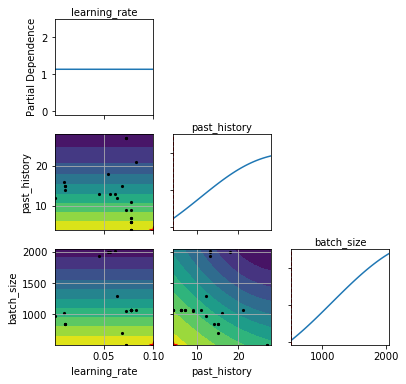

In [13]:
# extract and plot optimization results
dim_names = [
    'learning_rate',
    'past_history',
    'batch_size'
#     'class_0_weight',
#     'class_1_weight'
]

fig, ax = plot_objective(result=search_result, dimension_names=dim_names)
plt.savefig('../project_info/figures/single_LSTM_first_round_GPO.png', bbox_inches='tight')

### Re-train and evaluate winning model

Next: take the winning hyperparameters and conduct a long training run. This is our 'Cassandra' model. It represents the upper bound - how well can the output be modeled from the input?

In [14]:
# winning hyperparameters
space = search_result.space
winning_hyperparams = space.point_to_dict(search_result.x)
winning_hyperparams

{'learning_rate': 0.1, 'past_history': 4, 'batch_size': 512}

In [15]:
# set up training run with winning values
learning_rate = winning_hyperparams['learning_rate']
past_history = winning_hyperparams['past_history']

dataset_len = len(training_data)
ignition_count = sum(training_data['ignition'])
no_ignition_count = dataset_len - ignition_count

weight_for_0 = (1 / no_ignition_count)*(dataset_len)/2.0 
weight_for_1 = (1 / ignition_count)*(dataset_len)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

EPOCHS = 350 # train longer than in optimization phase
batch_size = int((len(training_data) * 0.99) // past_history)
steps_per_epoch = int((len(training_data) * 0.99) // batch_size)
validation_steps = int((len(validation_data) * 0.99) // batch_size)

In [16]:
# reprep data with winning past history length
x_train, y_train = data_functions.multivariate_data(
    training_data,
    past_history,
    future_target, 
    step
)

start_index = (x_train.shape[0] - (x_train.shape[0] % batch_size))
end_index = x_train.shape[0]
x_train = np.delete(x_train, range(start_index, end_index), axis=0)
y_train = np.delete(y_train, range(start_index, end_index), axis=0)

print(f'Training data shape: {x_train.shape}')
print(f'Training label shape: {x_train.shape}')
print()

x_validation, y_validation = data_functions.multivariate_data(
    validation_data,
    past_history,
    future_target, 
    step
)

start_index = (x_validation.shape[0] - (x_validation.shape[0] % batch_size))
end_index = x_validation.shape[0]
x_validation = np.delete(x_validation, range(start_index, end_index), axis=0)
y_validation = np.delete(y_validation, range(start_index, end_index), axis=0)

print(f'Validation data shape: {x_validation.shape}')
print(f'Validation label shape: {x_validation.shape}')
print()

x_test, y_test = data_functions.multivariate_data(
    test_data,
    past_history,
    future_target, 
    step
)

start_index = (x_test.shape[0] - (x_test.shape[0] % batch_size))
end_index = x_test.shape[0]
x_test = np.delete(x_test, range(start_index, end_index), axis=0)
y_test = np.delete(y_test, range(start_index, end_index), axis=0)

print(f'Test data shape: {x_test.shape}')
print(f'Test label shape: {x_test.shape}')

input_dim = x_test.shape[-2:]
input_shape = (batch_size, input_dim[0], input_dim[1])

Training data shape: (3252, 4, 18)
Training label shape: (3252, 4, 18)

Validation data shape: (3252, 4, 18)
Validation label shape: (3252, 4, 18)

Test data shape: (1626, 4, 18)
Test label shape: (1626, 4, 18)


In [17]:
# rebuild model with winning hyperparameters
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.GRU(
    100,
    stateful = False,
    dropout = 0.2
))

model.add(tf.keras.layers.Dense(
    1,
    activation = 'sigmoid',
    bias_initializer = output_bias)
)

model.compile(
    optimizer = tf.keras.optimizers.Adam(lr = learning_rate), 
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = metrics
)

In [18]:
%%time

# train
log_dir = f'./LSTM_logs/single_statefull_optimization_round1/'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(
    x_train,
    y_train,
    epochs = EPOCHS,
    batch_size = batch_size,
    steps_per_epoch = steps_per_epoch,
    callbacks = [tensorboard_callback],
    validation_data = (x_validation, y_validation),
    validation_steps = validation_steps,
    class_weight = class_weight,
    workers = 8,
    verbose = 0
)

CPU times: user 1min 11s, sys: 5.34 s, total: 1min 16s
Wall time: 47.3 s


Total observations: 3287


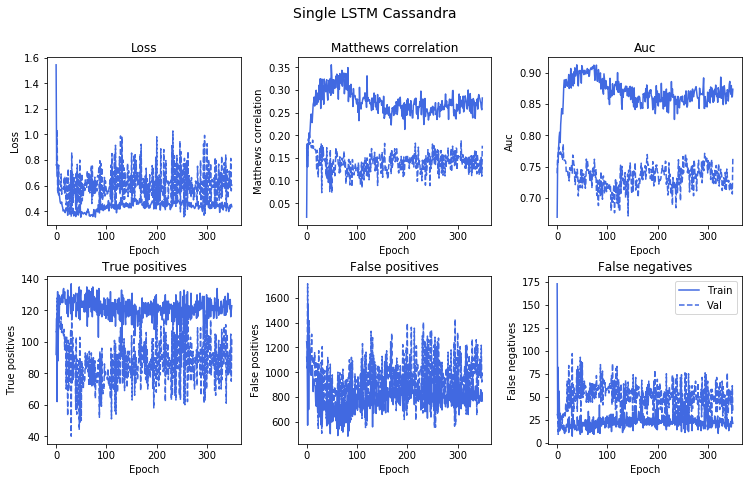

In [19]:
# plot learning curves
metric_names =  ['loss', 'matthews_correlation', 'auc', 'true_positives', 'false_positives', 'false_negatives']
filename = '../project_info/figures/single_LSTM_cassandra_learning_curves.png'
print(f"Total observations: {len(training_data)}")

plotting_functions.plot_metrics('Single LSTM Cassandra', history, metric_names, filename)

As expected, the training curves look pretty bad - the model is clearly over fit. But it does look like it was able to drive the loss to near zero.

In [20]:
# use trained model to make predictions from training, validation and testing data
train_predictions = model.predict(x_train, batch_size = batch_size)
validation_predictions = model.predict(x_validation, batch_size = batch_size)
test_predictions = model.predict(x_test, batch_size = batch_size)

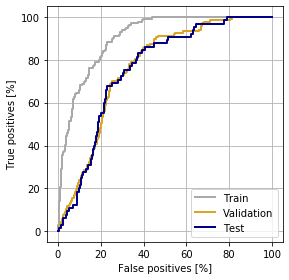

In [21]:
# plot ROC for all three datasets
plotting_functions.plot_roc("Train", y_train, train_predictions, color='darkgray')
plotting_functions.plot_roc("Validation", y_validation, validation_predictions, color='goldenrod')
plotting_functions.plot_roc("Test", y_test, test_predictions, color='darkblue')
plt.legend(loc='lower right')
plt.savefig('../project_info/figures/single_LSTM_cassandra_ROC.png', bbox_inches='tight')
plt.show()

Not surprisingly, the ROC curve also indicates extreme over fitting. The area under the training curve is almost 1, but is much less for the validation and test sets.

Now, for fun, let's take a look at some specific predictions and see what the actual output from the model looks like.

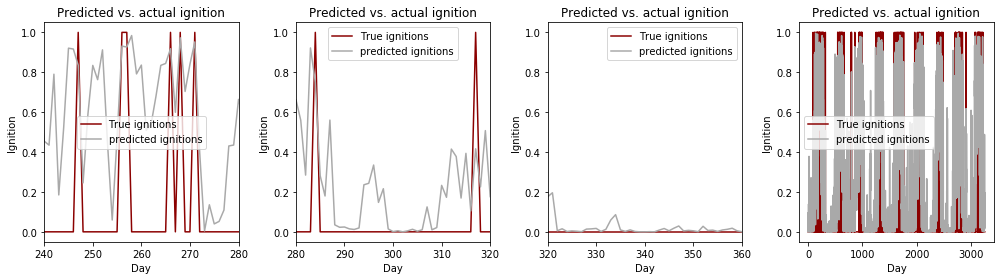

In [22]:
# plot training predictions vs actual ignitions
filename = '../project_info/figures/single_LSTM_cassandra_training_predictions.png'
plotting_functions.plot_ignition_predictions(train_predictions, y_train, filename)

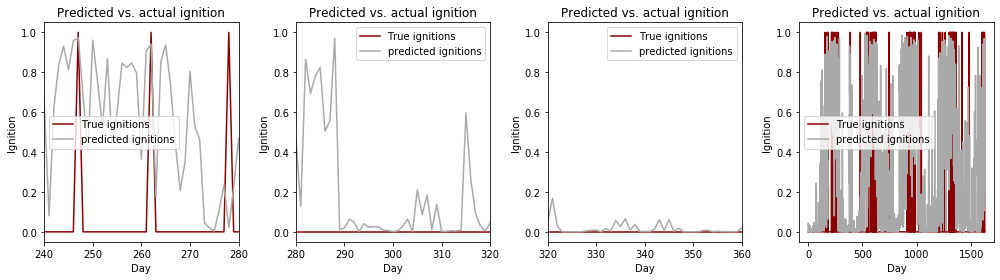

In [23]:
# plot test data predictions vs actual ignitions
filename = '../project_info/figures/single_LSTM_cassandra_test_predictions.png'
plotting_functions.plot_ignition_predictions(test_predictions, y_test, filename)

Last thing to take a look at are the confusion matrices for the training and test sets:


Training data prediction results
No fire (True Negatives):  2307
False alarms (False Positives):  801
Fires missed (False Negatives):  15
Fires detected (True Positives):  129
Total fires:  144

Test data prediction results
No fire (True Negatives):  1101
False alarms (False Positives):  460
Fires missed (False Negatives):  18
Fires detected (True Positives):  47
Total fires:  65


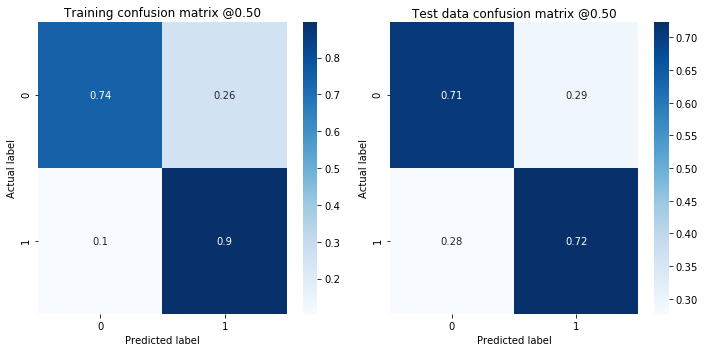

In [24]:
# results = model.evaluate(
#     x_train,
#     y_train,
#     batch_size = batch_size,
#     verbose=0
# )

# for name, value in zip(model.metrics_names, results):
#     print(name, ': ', value)
    
filename = '../project_info/figures/single_LSTM_cassandra_confusion_matrices.png'
plotting_functions.plot_cm(y_train, train_predictions, y_test, test_predictions, filename)

Results look great - despite the over fitting. Remember, over fitting was the goal. We have seen conclusively that their is enough information in the data and enough power in a LSTM to memorize the training set. This was not possible with gradient boosting decision trees or even deep neural networks. Now the task its to regularize the model so that it generalizes well.

# 3. LSTM optimization - regularize model & generalizability

Now that we know a LSTM can learn the training data, let's see how well we can get it to generalize to unseen test data. To do this we will run a second GPO round with the following changes:

1. Number of LSTM units will be added as a tunable parameter, and capped at 5 to reduce model complexity (this is also helpful for scaling the model)
2. Variational dropout will be added to the LSTM layer as a tunable parameter
3. Gaussian optimization and early stopping will use Matthews correlation on the validation set rather than the training set

At the same time, we will reoptimize the learning rate, class weights and past history, in case the optimum setting for those hyperparamters depend on the others.

### Set up gaussian process optimization

In [25]:
path_best_model = './trained_models/second_round_single_LSTM_optimization.keras'
best_val_matthews_correlation = -1.0

dim_learning_rate = Real(
    low=0.0001,
    high=0.1, 
    name='learning_rate'
)

dim_past_history = Integer(
    low=1,
    high=5, 
    name='past_history'
)

# dim_class_0_weight = Real(
#     low=0.001, 
#     high=10,
#     name='class_0_weight'
# )

# dim_class_1_weight = Real(
#     low=0.01, 
#     high=100,
#     name='class_1_weight'
# )

dim_lstm_units = Integer(
    low=1, 
    high=10,
    name='lstm_units'
)

dim_variational_dropout = Real(
    low=0.01, 
    high=0.5,
    name='variational_dropout'
)

default_parameters = [learning_rate, past_history, 1, 0.1]

dimensions = [
    dim_learning_rate,
    dim_past_history,
#     dim_class_0_weight,
#     dim_class_1_weight,
    dim_lstm_units,
    dim_variational_dropout
]

# Use early stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_matthews_correlation', 
    patience = 10,
    mode = 'max',
    restore_best_weights = True
)


future_target = 1
step = 1
EPOCHS = 100

# also set initial value for output bias based on fire frequency
raw_output_bias = np.log([num_fires/(total_observations - num_fires)])
output_bias = tf.keras.initializers.Constant(raw_output_bias)

path_best_model = './trained_models/first_round_single_LSTM_optimization.keras'
best_matthews_correlation = -1.0

run_num = 1

NameError: name 'num_fires' is not defined

In [ ]:
def make_model(
        input_shape,
        learning_rate,
        lstm_units,
        variational_dropout,
):    
    
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.LSTM(
        lstm_units,
        batch_input_shape = input_shape,
        dropout = variational_dropout,
        stateful = True
    ))
    
    model.add(tf.keras.layers.Dense(
        1,
        activation = 'sigmoid',
        bias_initializer = output_bias)
    )

    model.compile(
        optimizer = tf.keras.optimizers.Adam(lr = learning_rate), 
        loss = keras.losses.BinaryCrossentropy(),
        metrics = metrics
    )

    return model

@use_named_args(dimensions=dimensions)
def fitness(
    learning_rate,
    past_history,
#     class_0_weight,
#     class_1_weight,
    lstm_units,
    variational_dropout
):
    # calculate batch and steps from past history size
    batch_size = int((len(training_data) * 0.99) // past_history)
    steps_per_epoch = int((len(training_data) * 0.99) // batch_size)
    validation_steps = int((len(validation_data) * 0.99) // batch_size)
    
    dataset_len = len(training_data)
    ignition_count = sum(training_data['ignition'])
    no_ignition_count = dataset_len - ignition_count
    
    weight_for_0 = (1 / no_ignition_count)*(dataset_len)/2.0 
    weight_for_1 = (1 / ignition_count)*(dataset_len)/2.0

    class_weight = {0: weight_for_0, 1: weight_for_1}
    
    # create data sets
    x_train, y_train = data_functions.multivariate_data(
        training_data,
        past_history,
        future_target, 
        step
    )
    
    x_validation, y_validation = data_functions.multivariate_data(
        validation_data,
        past_history,
        future_target, 
        step
    )
    
    # trim datasets so they are a whole number factor of the batch size
    start_index = (x_train.shape[0] - (x_train.shape[0] % batch_size))
    end_index = x_train.shape[0]
    
    x_train = np.delete(x_train, range(start_index, end_index), axis=0)
    y_train = np.delete(y_train, range(start_index, end_index), axis=0)
    
    start_index = (x_validation.shape[0] - (x_validation.shape[0] % batch_size))
    end_index = x_validation.shape[0]
    
    x_validation = np.delete(x_validation, range(start_index, end_index), axis=0)
    y_validation = np.delete(y_validation, range(start_index, end_index), axis=0)
    
    input_dim = x_train.shape[-2:]
    input_shape = (batch_size, input_dim[0], input_dim[1])
    
    # Create the neural network with these hyper-parameters.
    model = make_model(
        input_shape = input_shape,
        learning_rate = learning_rate,
        lstm_units = lstm_units,
        variational_dropout = variational_dropout,
    )
    
    # Create a callback-function for Keras which will be
    # run after each epoch has ended during training.
    # This saves the log-files for TensorBoard.
    # Note that there are complications when histogram_freq=1.
    # It might give strange errors and it also does not properly
    # support Keras data-generators for the validation-set.
    global run_num
    
    log_dir = f'./LSTM_logs/single_statefull_gp_min_run{run_num}/'
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
   
    # Use Keras to train the model.
    history = model.fit(
        x_train,
        y_train,
        epochs = EPOCHS,
        batch_size = batch_size,
        steps_per_epoch = steps_per_epoch,
        callbacks = [early_stopping_callback],
        validation_data = (x_validation, y_validation),
        validation_steps = validation_steps,
        class_weight = class_weight,
        workers = 8,
        verbose = 0
    )

    # Get MCC for training run
    matthews_correlation = history.history['val_matthews_correlation'][-1]

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_matthews_correlation

    # If the MCC of the saved model is improved ...
    if matthews_correlation > best_matthews_correlation:
        # Save the new model to harddisk.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_matthews_correlation = matthews_correlation
        
    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    
    run_num += 1
    
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST MCC, we need to 
    # negate this number so it can be minimized.
    return -matthews_correlation

### Run gaussian process optimization

In [ ]:
%%time

# do GPO
search_result = gp_minimize(
    func = fitness,
    dimensions = dimensions,
    acq_func = 'EI', # Expected Improvement.
    n_calls = 50,
    x0 = default_parameters
)

In [ ]:
# extract winning hyperparameters
dim_names = [
    'learning_rate',
    'past_history',
#     'class_0_weight',
#     'class_1_weight',
    'lstm_units',
    'variational_dropout'
]

fig, ax = plot_objective(result = search_result, dimension_names = dim_names)
plt.savefig('../project_info/figures/single_LSTM_second_round_GPM.png', bbox_inches='tight')

### Re-train and evaluate winning model

In [ ]:
space = search_result.space
winning_hyperparams = space.point_to_dict(search_result.x)
winning_hyperparams

In [ ]:
# hyperparameters
# learning_rate = winning_hyperparams['learning_rate']
# lstm_units = winning_hyperparams['lstm_units']

# learning_rate = 0.001
# past_history = 5
# class_0_weight = 6.3720941191248395
# class_1_weight = 94.18261239534365
# lstm_units = 1
# variational_dropout = 0.4

learning_rate = winning_hyperparams['learning_rate']
past_history = winning_hyperparams['past_history']
# class_0_weight = winning_hyperparams['class_0_weight']
# class_1_weight = winning_hyperparams['class_1_weight']
lstm_units = winning_hyperparams['lstm_units']
variational_dropout = winning_hyperparams['variational_dropout']

# class_weight = {0: class_0_weight, 1: class_1_weight}

EPOCHS = 500
batch_size = int((len(test_data) * 0.99) // past_history)
steps_per_epoch = int((len(training_data) * 0.99) // batch_size)
validation_steps = int((len(validation_data) * 0.99) // batch_size)

In [ ]:
print(f'Past history {past_history}')
print(f'Batch size: {batch_size}')
print(f'Steps per epoch: {steps_per_epoch}')

In [ ]:
x_train, y_train = data_functions.multivariate_data(
    training_data,
    past_history,
    future_target, 
    step
)

start_index = (x_train.shape[0] - (x_train.shape[0] % batch_size))
end_index = x_train.shape[0]
x_train = np.delete(x_train, range(start_index, end_index), axis=0)
y_train = np.delete(y_train, range(start_index, end_index), axis=0)

x_validation, y_validation = data_functions.multivariate_data(
    validation_data,
    past_history,
    future_target, 
    step
)

start_index = (x_validation.shape[0] - (x_validation.shape[0] % batch_size))
end_index = x_validation.shape[0]
x_validation = np.delete(x_validation, range(start_index, end_index), axis=0)
y_validation = np.delete(y_validation, range(start_index, end_index), axis=0)

x_test, y_test = data_functions.multivariate_data(
    test_data,
    past_history,
    future_target, 
    step
)

start_index = (x_test.shape[0] - (x_test.shape[0] % batch_size))
end_index = x_test.shape[0]
x_testing = np.delete(x_test, range(start_index, end_index), axis=0)
y_testing = np.delete(y_test, range(start_index, end_index), axis=0)

input_dim = x_testing.shape[-2:]
input_shape = (batch_size, input_dim[0], input_dim[1])

In [ ]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.LSTM(
    lstm_units,
    batch_input_shape = input_shape,
    dropout = variational_dropout,
    stateful = True
))

model.add(tf.keras.layers.Dense(
    1,
    activation = 'sigmoid',
    bias_initializer = output_bias)
)

model.compile(
    optimizer = tf.keras.optimizers.Adam(lr = learning_rate), 
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = metrics
)

In [ ]:
%%time

history = model.fit(
    x_train,
    y_train,
    epochs = EPOCHS,
    batch_size = batch_size,
    steps_per_epoch = steps_per_epoch,
    #callbacks = [early_stopping_callback],
    validation_data = (x_validation, y_validation),
    validation_steps = validation_steps,
    class_weight = class_weight,
    workers = 8,
    verbose = 0
)

In [ ]:
# plot learning curves
metric_names =  ['loss', 'matthews_correlation', 'auc', 'true_positives', 'false_positives', 'false_negatives']
filename = '../project_info/figures/single_LSTM_optimized_learning_curves.png'
print(f"Total observations: {len(training_data)}")

plotting_functions.plot_metrics('Single LSTM Cassandra', history, metric_names, filename)

In [ ]:
train_predictions = model.predict(x_train, batch_size = batch_size)
validation_predictions = model.predict(x_validation, batch_size = batch_size)
test_predictions = model.predict(x_testing, batch_size = batch_size)

In [ ]:
plotting_functions.plot_roc("Train", y_train, train_predictions, color='darkgray')
plotting_functions.plot_roc("Validation", y_validation, validation_predictions, color='goldenrod')
plotting_functions.plot_roc("Test", y_testing, test_predictions, color='darkblue')
plt.legend(loc='lower right')
plt.show()

In [ ]:
filename = '../project_info/figures/single_LSTM_optimized_training_predictions.png'
plotting_functions.plot_ignition_predictions(train_predictions, y_train, filename)

In [ ]:
filename = '../project_info/figures/single_LSTM_optimized_testing_predictions.png'
plotting_functions.plot_ignition_predictions(test_predictions, y_testing, filename)

In [ ]:
# results = model.evaluate(
#     x_train,
#     y_train, 
#     verbose=0
# )

# for name, value in zip(model.metrics_names, results):
#     print(name, ': ', value)
    
filename = '../project_info/figures/single_LSTM_optimizedweather_confusion_matrices.png'
plotting_functions.plot_cm(y_train, train_predictions, y_testing, test_predictions, filename)